In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vietnamese-word-list/Viet74K.txt
/kaggle/input/idoms-slangs/idoms_slangs.txt
/kaggle/input/vietnamese-stopwords/vietnamese-stopwords.txt
/kaggle/input/vsec-dataset-for-vietnammese-correction-words/VSEC.jsonl


In [2]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.2 MB/s eta 0:00:00


In [3]:
!pip install regex

In [4]:
import json
import pandas as pd
import numpy as np
import scipy.stats as st
import re
import regex as re
import io
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from pyvi import ViTokenizer
from collections import Counter
from wordcloud import WordCloud
import requests
import math
import time

In [5]:
# Load the dataset
file_path = '/kaggle/input/vsec-dataset-for-vietnammese-correction-words/VSEC.jsonl'
data = []

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                record = json.loads(line.strip())  # Parse từng dòng thành JSON
                data.append(record)
            except json.JSONDecodeError:
                print(f"Lỗi: Dòng không phải JSON hợp lệ: {line[:50]}...")  # Log lỗi nếu có
                continue
    
    print(f"Đã tải thành công {len(data)} bản ghi từ {file_path}")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {file_path}")
    data = None
except Exception as e:
    print(f"Lỗi không xác định khi đọc file: {e}")
    data = None

Đã tải thành công 9341 bản ghi từ /kaggle/input/vsec-dataset-for-vietnammese-correction-words/VSEC.jsonl


# Phân loại lỗi

In [6]:
# Define Vietnamese keyboard layouts for TELEX and VNI
# Note: This is a simplified representation focusing on common errors.
# TELEX: s -> s, x -> x, f -> dấu huyền, r -> dấu hỏi, x -> dấu ngã, j -> dấu nặng, z -> remove tone, w -> ă, [ -> ư, [[ -> ơ
# VNI: 1 -> sắc, 2 -> huyền, 3 -> hỏi, 4 -> ngã, 5 -> nặng, 6 -> â, 7 -> ê, 8 -> ô, 9 -> ư, 0 -> đ
# Common confusions: s/x, tr/ch, gi/d/r, n/ng/nh, c/q/k, dấu hỏi/ngã, i/y, o/ô/ơ, a/ă/â, u/ư

# Common typing error pairs (approximation) based on phonetics and keyboard layout
# Focus on pairs often confused
common_typo_pairs = [
    ('s', 'x'), ('x', 's'),
    ('tr', 'ch'), ('ch', 'tr'),
    ('d', 'gi'), ('gi', 'd'),
    ('d', 'r'), ('r', 'd'),
    ('gi', 'r'), ('r', 'gi'),
    ('n', 'l'), ('l', 'n'),
    ('i', 'y'), ('y', 'i'), # Particularly at the end of syllables
    # Tone mark errors (simplified - actual mechanism is complex)
    ('huyền', 'nặng'), ('nặng', 'huyền'),
    ('hỏi', 'ngã'), ('ngã', 'hỏi'),
    ('sắc', 'nặng'), ('nặng', 'sắc'),
    ('không dấu', 'huyền'), ('huyền', 'không dấu'),
    ('không dấu', 'sắc'), ('sắc', 'không dấu'),
    ('không dấu', 'hỏi'), ('hỏi', 'không dấu'),
    ('không dấu', 'ngã'), ('ngã', 'không dấu'),
    ('không dấu', 'nặng'), ('nặng', 'không dấu'),
    # Vowel group errors
    ('ă', 'â'), ('â', 'ă'),
    ('o', 'ô'), ('ô', 'o'),
    ('ơ', 'ô'), ('ô', 'ơ'),
    ('u', 'ư'), ('ư', 'u'),
    ('ê', 'e'), ('e', 'ê'),
    ('đ', 'd'), ('d', 'đ') # VNI specific key difference
]

# Helper function to get tone mark from a Vietnamese syllable (simplified)
def get_tone(syllable):
    tones = {
        'á': 'sắc', 'à': 'huyền', 'ả': 'hỏi', 'ã': 'ngã', 'ạ': 'nặng',
        'ấ': 'sắc', 'ầ': 'huyền', 'ẩ': 'hỏi', 'ẫ': 'ngã', 'ậ': 'nặng',
        'ắ': 'sắc', 'ằ': 'huyền', 'ẳ': 'hỏi', 'ẵ': 'ngã', 'ặ': 'nặng',
        'é': 'sắc', 'è': 'huyền', 'ẻ': 'hỏi', 'ẽ': 'ngã', 'ẹ': 'nặng',
        'ế': 'sắc', 'ề': 'huyền', 'ể': 'hỏi', 'ễ': 'ngã', 'ệ': 'nặng',
        'í': 'sắc', 'ì': 'huyền', 'ỉ': 'hỏi', 'ĩ': 'ngã', 'ị': 'nặng',
        'ó': 'sắc', 'ò': 'huyền', 'ỏ': 'hỏi', 'õ': 'ngã', 'ọ': 'nặng',
        'ố': 'sắc', 'ồ': 'huyền', 'ổ': 'hỏi', 'ỗ': 'ngã', 'ộ': 'nặng',
        'ớ': 'sắc', 'ờ': 'huyền', 'ở': 'hỏi', 'ỡ': 'ngã', 'ợ': 'nặng',
        'ú': 'sắc', 'ù': 'huyền', 'ủ': 'hỏi', 'ũ': 'ngã', 'ụ': 'nặng',
        'ứ': 'sắc', 'ừ': 'huyền', 'ử': 'hỏi', 'ữ': 'ngã', 'ự': 'nặng',
        'ý': 'sắc', 'ỳ': 'huyền', 'ỷ': 'hỏi', 'ỹ': 'ngã', 'ỵ': 'nặng'
    }
    for char, tone in tones.items():
        if char in syllable:
            return tone
    return 'không dấu'

# Helper function to remove tone marks (for consonant/vowel comparison)
def remove_tone(syllable):
    no_tone_map = {
        'á': 'a', 'à': 'a', 'ả': 'a', 'ã': 'a', 'ạ': 'a',
        'ấ': 'â', 'ầ': 'â', 'ẩ': 'â', 'ẫ': 'â', 'ậ': 'â',
        'ắ': 'ă', 'ằ': 'ă', 'ẳ': 'ă', 'ẵ': 'ă', 'ặ': 'ă',
        'é': 'e', 'è': 'e', 'ẻ': 'e', 'ẽ': 'e', 'ẹ': 'e',
        'ế': 'ê', 'ề': 'ê', 'ể': 'ê', 'ễ': 'ê', 'ệ': 'ê',
        'í': 'i', 'ì': 'i', 'ỉ': 'i', 'ĩ': 'i', 'ị': 'i',
        'ó': 'o', 'ò': 'o', 'ỏ': 'o', 'õ': 'o', 'ọ': 'o',
        'ố': 'ô', 'ồ': 'ô', 'ổ': 'ô', 'ỗ': 'ô', 'ộ': 'ô',
        'ớ': 'ơ', 'ờ': 'ơ', 'ở': 'ơ', 'ỡ': 'ơ', 'ợ': 'ơ',
        'ú': 'u', 'ù': 'u', 'ủ': 'u', 'ũ': 'u', 'ụ': 'u',
        'ứ': 'ư', 'ừ': 'ư', 'ử': 'ư', 'ữ': 'ư', 'ự': 'ư',
        'ý': 'y', 'ỳ': 'y', 'ỷ': 'y', 'ỹ': 'y', 'ỵ': 'y'
    }
    # Normalize to lowercase first
    syllable = syllable.lower()
    new_syllable = ""
    for char in syllable:
        new_syllable += no_tone_map.get(char, char)
    return new_syllable

In [7]:
errors = []
total_syllables = 0
keyboard_errors = Counter() # To store counts of common typo pairs

if data:
    for entry in data:
        text = entry['text']
        annotations = entry['annotations']
        syllables = [ann['current_syllable'] for ann in annotations]

        # 1a. Misspelling (Incorrect Syllable)
        for i, ann in enumerate(annotations):
            total_syllables += 1
            if not ann['is_correct']:
                error_type = 'Misspelling'
                incorrect_syl = ann['current_syllable']
                # Use the first alternative as the suggested correction
                correct_syl = ann['alternative_syllables'][0] if ann['alternative_syllables'] else incorrect_syl

                # Simple classification (can be expanded)
                details = {
                    'incorrect': incorrect_syl,
                    'correct': correct_syl,
                    'length': len(incorrect_syl.strip('.,!?;:')), # Length without punctuation
                    'context': ' '.join(syllables[max(0, i-2):min(len(syllables), i+3)]) # 5-syllable window
                }

                # Check for common keyboard/phonetic errors
                incorrect_norm = remove_tone(incorrect_syl.strip('.,!?;:').lower())
                correct_norm = remove_tone(correct_syl.strip('.,!?;:').lower())
                incorrect_tone = get_tone(incorrect_syl.lower())
                correct_tone = get_tone(correct_syl.lower())

                found_pair = False
                # Check character-level pairs first
                for pair in common_typo_pairs:
                    # Check direct substitution (simplistic)
                    if (pair[0] in incorrect_norm and pair[1] in correct_norm and len(incorrect_norm) == len(correct_norm)) or \
                       (pair[1] in incorrect_norm and pair[0] in correct_norm and len(incorrect_norm) == len(correct_norm)):
                         # Avoid matching subset like 'n' in 'ng' if pair is ('n', 'l')
                         # This heuristic is basic. A better approach would use phonetics/edit distance.
                         # Let's simplify: if the core non-tone part differs by one of the common pairs.
                         if incorrect_norm.replace(pair[0], pair[1]) == correct_norm or \
                            incorrect_norm.replace(pair[1], pair[0]) == correct_norm:
                             keyboard_errors[tuple(sorted(pair))] += 1
                             found_pair = True
                             break # Count first match

                # Check tone errors if core is the same
                if not found_pair and incorrect_norm == correct_norm and incorrect_tone != correct_tone:
                    tone_pair = tuple(sorted((incorrect_tone, correct_tone)))
                    # Only count if it's in our predefined likely confusions
                    if tone_pair in [(p[0], p[1]) for p in common_typo_pairs if 'dấu' in p[0] or 'dấu' in p[1]]:
                         keyboard_errors[tone_pair] += 1
                         found_pair = True
                    elif ('không dấu', incorrect_tone) in common_typo_pairs or \
                         ('không dấu', correct_tone) in common_typo_pairs :
                         keyboard_errors[tone_pair] += 1
                         found_pair = True


                errors.append({'type': error_type, 'details': details})

        # 1b. Punctuation Spacing Errors (Approximate Detection)
        # Look for space before common punctuation or missing space after
        # This requires analyzing the raw text, not just syllable annotations.
        # Regex for common punctuation spacing errors
        # Error: space before comma/period/etc. OR no space after (if not end of string)
        punctuation_errors = re.findall(r'\s+([.,!?;:])|([.,!?;:])(?!\s|$)', text)
        for err in punctuation_errors:
            # err is a tuple like ('!', '') or ('', ',')
            offending_char = err[0] if err[0] else err[1]
            context_start = max(0, text.find(offending_char) - 10)
            context_end = min(len(text), text.find(offending_char) + 10)
            context_snippet = text[context_start:context_end]
            errors.append({
                'type': 'Punctuation',
                'details': {
                    'error': f"Spacing near '{offending_char}'",
                    'context': context_snippet
                }
             })


print(f"Tổng số âm tiết được phân tích: {total_syllables}")
print(f"Tổng số lỗi được phát hiện (ước tính): {len(errors)}")

# Create DataFrame for analysis
df_errors = pd.DataFrame(errors)

Tổng số âm tiết được phân tích: 282459
Tổng số lỗi được phát hiện (ước tính): 12475


In [8]:
if not df_errors.empty:
    # Calculate error type percentages
    error_counts = df_errors['type'].value_counts()
    total_errors_found = len(df_errors)
    error_percentages = (error_counts / total_errors_found) * 100

    # Calculate 95% Confidence Intervals for percentages
    # Using Wilson score interval for proportions
    confidence_intervals = {}
    z = st.norm.ppf(0.975) # Z-score for 95% CI
    n = total_errors_found # Sample size (number of errors found) - Alternatively use total_syllables? Let's use total_errors for % distribution among error types.
                          # If we want % of *all* syllables that are errors, n = total_syllables. Let's do both.

    print("\nTỷ lệ % các loại lỗi (trong tổng số lỗi phát hiện):")
    n_err = total_errors_found
    for error_type, count in error_counts.items():
        p = count / n_err
        denominator = 1 + z**2 / n_err
        center = p + z**2 / (2 * n_err)
        term = z * np.sqrt((p * (1 - p) / n_err) + (z**2 / (4 * n_err**2)))
        ci_low = (center - term) / denominator * 100
        ci_high = (center + term) / denominator * 100
        confidence_intervals[error_type] = (ci_low, ci_high)
        print(f"- {error_type}: {error_percentages[error_type]:.2f}% (CI 95%: [{ci_low:.2f}%, {ci_high:.2f}%])")

    print(f"\nTỷ lệ lỗi trên tổng số âm tiết:")
    n_syl = total_syllables
    for error_type, count in error_counts.items():
        p = count / n_syl
        denominator = 1 + z**2 / n_syl
        center = p + z**2 / (2 * n_syl)
        term = z * np.sqrt((p * (1 - p) / n_syl) + (z**2 / (4 * n_syl**2)))
        ci_low_syl = (center - term) / denominator * 100
        ci_high_syl = (center + term) / denominator * 100
        print(f"- {error_type}: {(p*100):.2f}% (CI 95%: [{ci_low_syl:.2f}%, {ci_high_syl:.2f}%])")


    # Distribution of misspelling errors by syllable length
    misspelling_errors = df_errors[df_errors['type'] == 'Misspelling'].copy() # Use .copy()
    # Safely extract 'length' using .loc and handle potential errors
    misspelling_errors['length'] = misspelling_errors['details'].apply(lambda x: x.get('length') if isinstance(x, dict) else None)
    # Drop rows where length could not be extracted
    misspelling_errors.dropna(subset=['length'], inplace=True)
    # Ensure length is integer
    misspelling_errors['length'] = misspelling_errors['length'].astype(int)

    print("\nPhân phối lỗi 'Misspelling' theo độ dài âm tiết:")
    length_distribution = misspelling_errors['length'].value_counts().sort_index()
    print(length_distribution)

else:
    print("\nKhông tìm thấy lỗi nào hoặc dữ liệu rỗng.")
    error_percentages = pd.Series(dtype=float)
    length_distribution = pd.Series(dtype=int)
    keyboard_errors = Counter()


Tỷ lệ % các loại lỗi (trong tổng số lỗi phát hiện):
- Misspelling: 89.80% (CI 95%: [89.25%, 90.31%])
- Punctuation: 10.20% (CI 95%: [9.69%, 10.75%])

Tỷ lệ lỗi trên tổng số âm tiết:
- Misspelling: 3.97% (CI 95%: [3.89%, 4.04%])
- Punctuation: 0.45% (CI 95%: [0.43%, 0.48%])

Phân phối lỗi 'Misspelling' theo độ dài âm tiết:
length
1      147
2     1827
3     3774
4     3655
5     1359
6      347
7       57
8       24
9       10
10       1
12       1
Name: count, dtype: int64


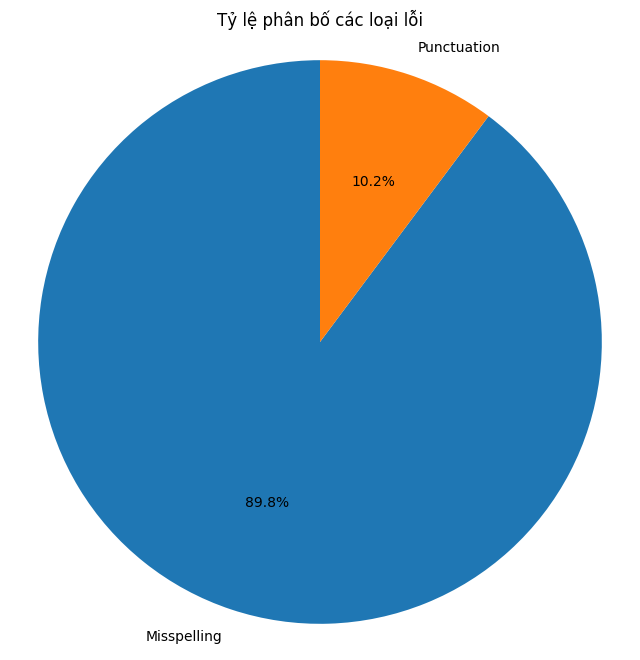

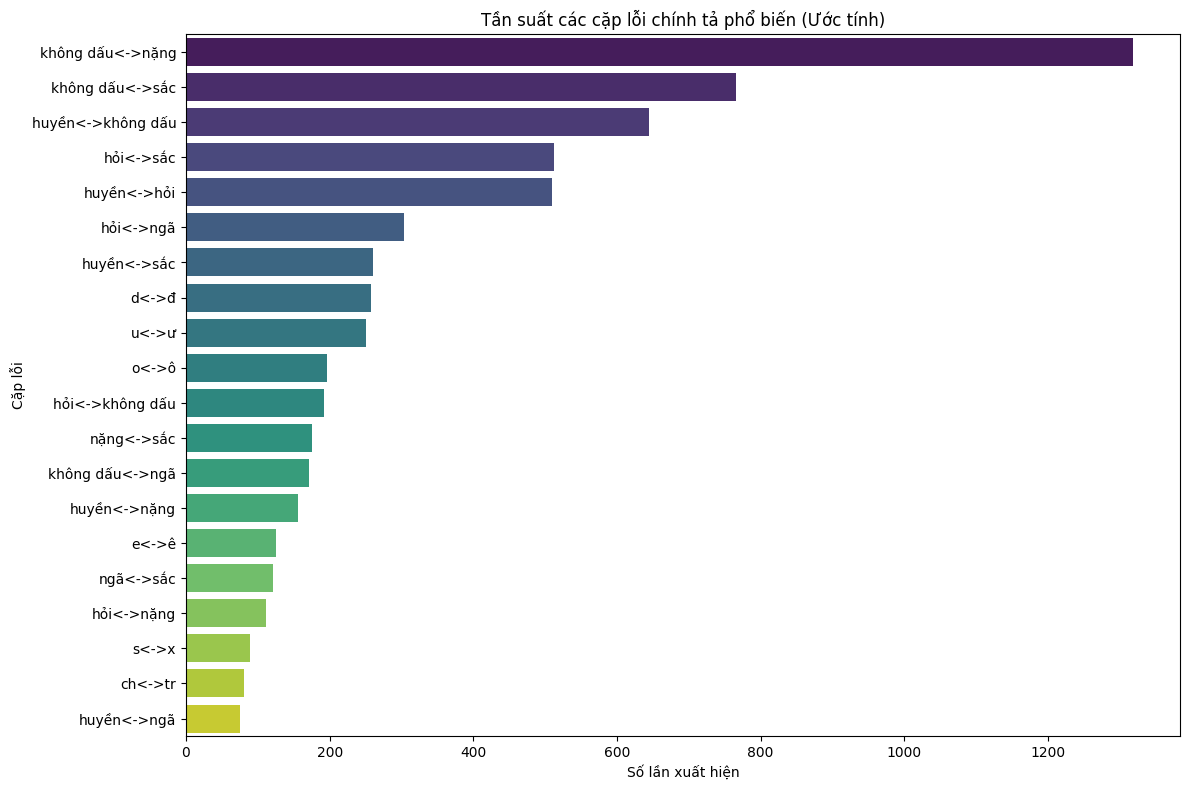


Một số ví dụ về lỗi được phát hiện:
              type                                                                                            details
717    Misspelling       {'incorrect': 'dộng,', 'correct': 'động,', 'length': 4, 'context': 'thoai di dộng, TV, như'}
4900   Misspelling        {'incorrect': 'nhiêt', 'correct': 'nhiệt', 'length': 5, 'context': 'cảm biến nhiêt độ khí'}
6726   Misspelling                {'incorrect': 'la', 'correct': 'là', 'length': 2, 'context': 'vật liệu la giúp ta'}
3837   Misspelling          {'incorrect': 'chiến', 'correct': 'chiếc', 'length': 5, 'context': 'nhanh hơn chiến lá.'}
5008   Misspelling          {'incorrect': 'tam', 'correct': 'tâm', 'length': 3, 'context': 'đến Trung tam ngoại ngữ'}
3322   Misspelling  {'incorrect': 'chỉnh:', 'correct': 'chính', 'length': 5, 'context': 'sản phẩm chỉnh: nghiên cứu'}
10573  Misspelling                {'incorrect': 'nă', 'correct': '', 'length': 2, 'context': 'nhiên, tính nă ng kết'}
8148   Misspelling 

In [9]:
# Set font for Vietnamese characters
plt.rcParams['font.family'] = 'DejaVu Sans' # Or another font that supports Vietnamese like 'Arial Unicode MS' if available

# a) Pie chart for error type distribution
if not error_percentages.empty:
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.pie(error_percentages, labels=error_percentages.index, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Tỷ lệ phân bố các loại lỗi')
    plt.show()
else:
    print("Không có dữ liệu lỗi để vẽ biểu đồ tròn.")


# b) Heatmap for keyboard/phonetic errors
if keyboard_errors:
    # Prepare data for heatmap
    heatmap_data = Counter({f"{p[0]}<->{p[1]}": count for p, count in keyboard_errors.items()})
    df_heatmap = pd.DataFrame(heatmap_data.most_common(20), columns=['Error Pair', 'Count']) # Limit to top 20

    # Since heatmap typically needs a 2D matrix, let's visualize the counts directly
    # A bar chart might be more appropriate here than a standard heatmap unless we create a matrix of char pairs
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    sns.barplot(x='Count', y='Error Pair', data=df_heatmap, ax=ax2, palette='viridis')
    plt.title('Tần suất các cặp lỗi chính tả phổ biến (Ước tính)')
    plt.xlabel('Số lần xuất hiện')
    plt.ylabel('Cặp lỗi')
    plt.tight_layout()
    plt.show()

    # Optional: Attempt a true heatmap if we can structure the data
    # Example: Create a matrix of initial vs corrected sounds/chars (complex)
    # For simplicity, the bar chart above is more direct for this counter data.

else:
    print("Không có đủ dữ liệu về lỗi gõ phím/âm vị để vẽ biểu đồ.")

# Display some examples of errors found
if not df_errors.empty:
    print("\nMột số ví dụ về lỗi được phát hiện:")
    print(df_errors.sample(min(10, len(df_errors))).to_string())
else:
    print("Không tìm thấy ví dụ lỗi.")

# Độ khó ngữ liệu

In [10]:
VIET74K_LOCAL_PATH = '/kaggle/input/vietnamese-word-list/Viet74K.txt'

# Thresholds and Settings
SENTENCE_LENGTH_THRESHOLD = 15
RARE_WORD_DEFINITION = "OOV (Not in Viet74K)"

In [11]:
def load_viet74k_wordlist(filepath):
    """Loads the Viet74K word list from the provided file."""
    word_set = set()
    if not os.path.exists(filepath):
        print(f"ERROR: Viet74K file not found at: {filepath}")
        return None
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip().lower()
                if word:
                    word_set.add(word)
        print(f"Loaded {len(word_set):,} words from {filepath}")
        if not word_set:
             print("Warning: Viet74K word list is empty after loading.")
        return word_set
    except Exception as e:
        print(f"Error loading Viet74K file: {e}")
        return None

viet74k_vocab = load_viet74k_wordlist(VIET74K_LOCAL_PATH)

Loaded 72,535 words from /kaggle/input/vietnamese-word-list/Viet74K.txt


In [12]:
def process_vsec_jsonl(filepath):
    """Loads and processes the VSEC JSONL data into a pandas DataFrame."""
    processed_data = []
    if not os.path.exists(filepath):
        print(f"ERROR: VSEC JSONL file not found at: {filepath}")
        return None
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        print(f"Loaded {len(lines)} entries from {filepath}")

        for entry_index, line in enumerate(lines):
            line = line.strip()
            if not line:
                continue  # Bỏ qua dòng trống
            try:
                entry = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Warning: Skipping invalid JSON at line {entry_index}: {e}")
                continue

            annotations = entry.get('annotations', [])
            original_text = entry.get('text', '')

            correct_syllables = []
            error_count = 0
            incorrect_words_at_error_pos = []

            for ann in annotations:
                syllable = ann.get('current_syllable', '')
                is_correct = ann.get('is_correct', True)

                syllable_clean_for_sentence = syllable.strip()
                syllable_clean_for_word_check = syllable.strip().lower()

                if syllable_clean_for_sentence:
                    correct_syllables.append(syllable_clean_for_sentence)
                    if not is_correct:
                        error_count += 1
                        cleaned_error_word = re.sub(r'[^\w\s]', '', syllable_clean_for_word_check, flags=re.UNICODE).strip()
                        if cleaned_error_word:
                            incorrect_words_at_error_pos.append(cleaned_error_word)

            raw_reconstructed = " ".join(correct_syllables)
            try:
                tokenized_sentence = ViTokenizer.tokenize(raw_reconstructed)
                correct_sentence = tokenized_sentence
            except Exception as e:
                print(f"Warning: Error tokenizing reconstructed sentence at index {entry_index}. Using raw join. Error: {e}")
                correct_sentence = raw_reconstructed

            processed_data.append({
                'original_text': original_text,
                'correct_sentence': correct_sentence,
                'error_count': error_count,
                'incorrect_words_at_error_pos': incorrect_words_at_error_pos
            })

        df = pd.DataFrame(processed_data)
        print(f"Processed into DataFrame with {len(df)} rows.")
        print("Sample reconstructed correct sentences (tokenized):")
        print(df['correct_sentence'].head())
        print(f"\nEntries with errors: {len(df[df['error_count'] > 0])}")
        print(f"Total errors identified (by syllable annotation): {df['error_count'].sum()}")
        return df

    except Exception as e:
        print(f"Error processing VSEC JSONL file: {e}")
        return None

vsec_df = process_vsec_jsonl(file_path)

Loaded 9341 entries from /kaggle/input/vsec-dataset-for-vietnammese-correction-words/VSEC.jsonl
Processed into DataFrame with 9341 rows.
Sample reconstructed correct sentences (tokenized):
0    Thông_qua công_tác tuyên_truyền , vận_động này...
1    Do đó , doanh_nghiệp cần chú_trọng đến yếu_tố ...
2    Giữ được chỉ_số này không giam mà còn tăng thê...
3    Đúng trước thực_tế này đòi_hỏi chúng_ta cần ph...
4    Trình_độ học_vấn của nhân_viên được tuyển_dụng...
Name: correct_sentence, dtype: object

Entries with errors: 9341
Total errors identified (by syllable annotation): 11202


In [13]:
def preprocess_text_for_analysis(text):
    """Cleans text for analysis: lowercase, remove punctuation, normalize space."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s_]', '', text, flags=re.UNICODE) # Keep underscore
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_sentence_lengths_from_series(text_series):
    """Calculates word count for each text entry in a pandas Series."""
    sentence_lengths = []
    processed_count = 0
    for text in text_series:
        if not isinstance(text, str) or not text:
            sentence_lengths.append(0)
            continue
        processed_text = preprocess_text_for_analysis(text)
        tokens = processed_text.split()
        sentence_lengths.append(len(tokens))
        processed_count += 1
    print(f"Calculated lengths for {processed_count} entries.")
    return sentence_lengths

vsec_df['sentence_length'] = get_sentence_lengths_from_series(vsec_df['correct_sentence'])
print(vsec_df[['correct_sentence', 'sentence_length']].head())

Calculated lengths for 9341 entries.
                                    correct_sentence  sentence_length
0  Thông_qua công_tác tuyên_truyền , vận_động này...               38
1  Do đó , doanh_nghiệp cần chú_trọng đến yếu_tố ...               16
2  Giữ được chỉ_số này không giam mà còn tăng thê...               19
3  Đúng trước thực_tế này đòi_hỏi chúng_ta cần ph...               29
4  Trình_độ học_vấn của nhân_viên được tuyển_dụng...               17


In [14]:
def analyze_vocabulary_wordlist(text_series, word_list_vocab):
    """Analyzes vocabulary: TTR, OOV Rate, OOV Words Counter."""
    all_tokens = []
    print("Analyzing vocabulary...")
    total_entries = len(text_series)
    for i, text in enumerate(text_series):
        if (i + 1) % 2000 == 0: # Progress indicator
            print(f"  Processed {i+1}/{total_entries} entries for vocabulary analysis...")
        if not isinstance(text, str) or not text:
            continue
        processed_text = preprocess_text_for_analysis(text)
        tokens = processed_text.split()
        all_tokens.extend(tokens)

    if not all_tokens:
        print("No tokens found for vocabulary analysis.")
        return {"total_tokens": 0, "unique_tokens": 0, "ttr": 0, "oov_rate": 0, "oov_words_counter": Counter()}

    print("Counting tokens...")
    total_tokens = len(all_tokens)
    token_counts = Counter(all_tokens)
    unique_tokens = len(token_counts)
    print("Token counting complete.")

    ttr = unique_tokens / total_tokens if total_tokens > 0 else 0

    oov_token_count = 0
    oov_words_counter = Counter()
    oov_rate = -1 # Default if vocab is missing

    if word_list_vocab is not None:
        print("Calculating OOV rate...")
        missing_count = 0
        for token, count in token_counts.items():
            if token not in word_list_vocab:
                 oov_token_count += count
                 oov_words_counter[token] = count
                 missing_count += 1
        oov_rate = oov_token_count / total_tokens if total_tokens > 0 else 0
        print(f"OOV calculation complete. Found {missing_count} unique OOV word types.")
    else:
        print("Warning: Viet74K word list vocabulary is missing. Cannot calculate OOV rate.")

    return {
        "total_tokens": total_tokens,
        "unique_tokens": unique_tokens,
        "ttr": ttr,
        "oov_rate": oov_rate,
        "oov_words_counter": oov_words_counter
    }

vocab_analysis = analyze_vocabulary_wordlist(vsec_df['correct_sentence'], viet74k_vocab)
print("\nVocabulary Analysis Results:")
print(f"Total tokens: {vocab_analysis['total_tokens']}")
print(f"Unique tokens: {vocab_analysis['unique_tokens']}")
print(f"Type-Token Ratio (TTR): {vocab_analysis['ttr']:.4f}")
if vocab_analysis['oov_rate'] >= 0:
    print(f"OOV Rate (w.r.t Viet74K): {vocab_analysis['oov_rate']:.4f}")
else:
    print("OOV Rate could not be calculated (Viet74K missing).")

Analyzing vocabulary...
  Processed 2000/9341 entries for vocabulary analysis...
  Processed 4000/9341 entries for vocabulary analysis...
  Processed 6000/9341 entries for vocabulary analysis...
  Processed 8000/9341 entries for vocabulary analysis...
Counting tokens...
Token counting complete.
Calculating OOV rate...
OOV calculation complete. Found 10056 unique OOV word types.

Vocabulary Analysis Results:
Total tokens: 205298
Unique tokens: 12997
Type-Token Ratio (TTR): 0.0633
OOV Rate (w.r.t Viet74K): 0.4147


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved sentence_length_histogram.png


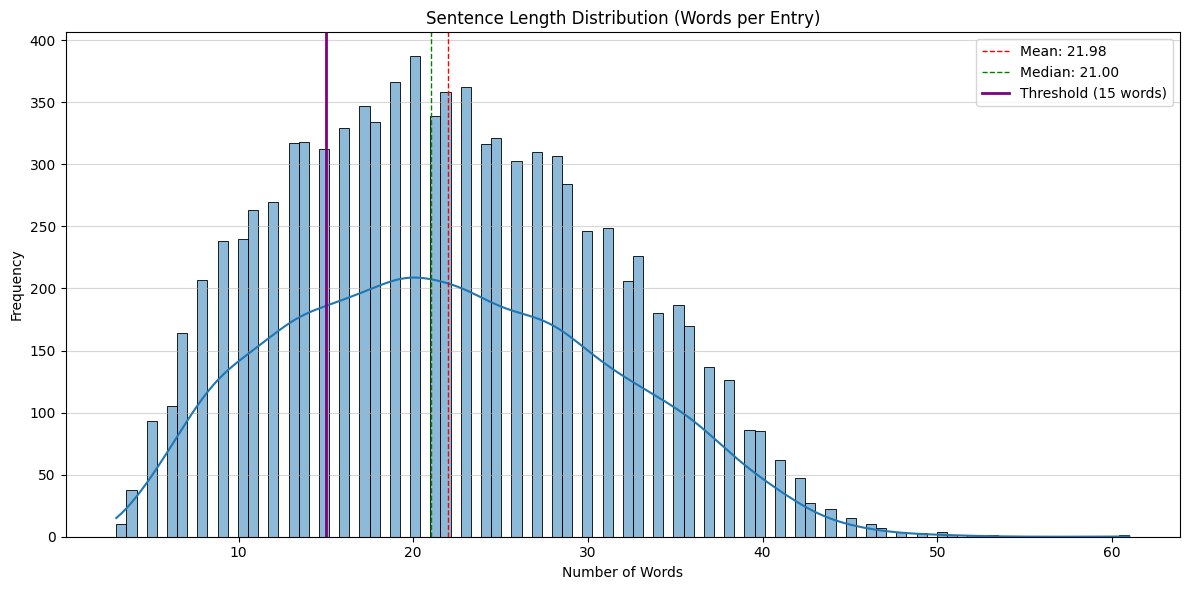


--- Sentence Length Comments ---
Average Sentence Length: 21.98 words
Median Sentence Length: 21.00 words
Standard Deviation: 9.25
Percentage of entries longer than 15 words: 72.43%
Observation: A notable portion (72.43%) of entries are longer than 15 words, potentially indicating higher complexity for correction.


In [15]:
def plot_sentence_length_histogram(sentence_lengths, threshold):
    """Plots histogram of sentence lengths."""
    plot_lengths = [l for l in sentence_lengths if l > 0]
    if not plot_lengths:
        print("No sentences with length > 0 found for histogram.")
        return
    plt.figure(figsize=(12, 6))
    sns.histplot(plot_lengths, bins=min(100, max(30, int(len(plot_lengths)/50))), kde=True)
    mean_len = np.mean(plot_lengths)
    median_len = np.median(plot_lengths)
    plt.axvline(mean_len, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_len:.2f}')
    plt.axvline(median_len, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_len:.2f}')
    plt.axvline(threshold, color='purple', linestyle='solid', linewidth=2, label=f'Threshold ({threshold} words)')
    plt.title('Sentence Length Distribution (Words per Entry)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.savefig("sentence_length_histogram.png")
    print("Saved sentence_length_histogram.png")
    plt.show()

    pct_long_sentences = (sum(1 for length in plot_lengths if length > threshold) / len(plot_lengths)) * 100
    print("\n--- Sentence Length Comments ---")
    print(f"Average Sentence Length: {mean_len:.2f} words")
    print(f"Median Sentence Length: {median_len:.2f} words")
    print(f"Standard Deviation: {np.std(plot_lengths):.2f}")
    print(f"Percentage of entries longer than {threshold} words: {pct_long_sentences:.2f}%")
    if pct_long_sentences > 10:
        print(f"Observation: A notable portion ({pct_long_sentences:.2f}%) of entries are longer than {threshold} words, potentially indicating higher complexity for correction.")
    else:
        print(f"Observation: Most entries are relatively short (below {threshold} words).")


plot_sentence_length_histogram(vsec_df['sentence_length'], SENTENCE_LENGTH_THRESHOLD)


Data points per error group for boxplot:
error_group
0        0
1     7853
2     1224
3      191
4+      73
Name: count, dtype: int64
Saved sentence_length_boxplot_by_error.png


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


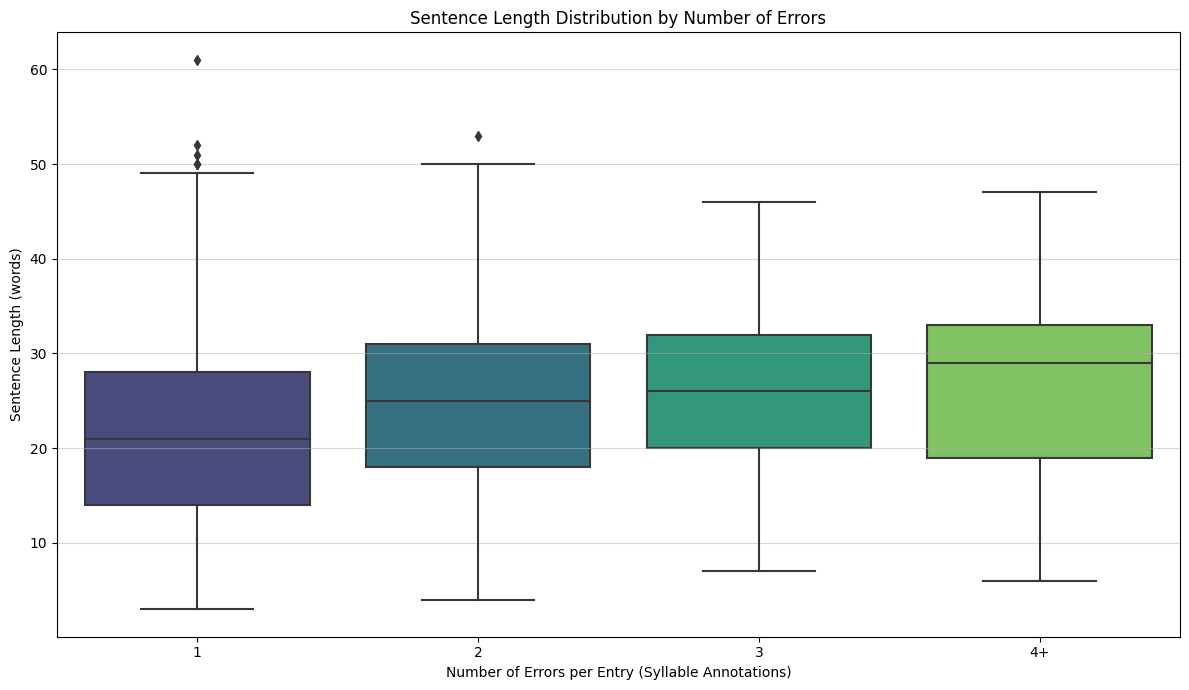


--- Sentence Length Stats by Error Group ---
              count       mean       std  min   25%   50%   75%   max
error_group                                                          
0               0.0        NaN       NaN  NaN   NaN   NaN   NaN   NaN
1            7853.0  21.391061  9.195076  3.0  14.0  21.0  28.0  61.0
2            1224.0  24.780229  8.937408  4.0  18.0  25.0  31.0  53.0
3             191.0  26.083770  8.334033  7.0  20.0  26.0  32.0  46.0
4+             73.0  27.410959  9.837338  6.0  19.0  29.0  33.0  47.0


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [16]:
def plot_sentence_length_boxplot_by_error_count(df):
    """Plots boxplot of sentence length grouped by error count."""
    if 'sentence_length' not in df.columns or 'error_count' not in df.columns:
        print("Required columns not found for boxplot. Skipping.")
        return

    plot_data = df[df['sentence_length'] > 0].copy()
    if plot_data.empty:
         print("No valid data for boxplot after filtering zero lengths.")
         return

    max_errors_to_show = 4 # Group 4+ errors
    plot_data['error_group'] = plot_data['error_count'].apply(
        lambda x: str(x) if x < max_errors_to_show else f'{max_errors_to_show}+'
    )
    error_order = [str(i) for i in range(max_errors_to_show)] + [f'{max_errors_to_show}+']
    plot_data['error_group'] = pd.Categorical(plot_data['error_group'], categories=error_order, ordered=True)

    group_counts = plot_data['error_group'].value_counts().sort_index()
    print("\nData points per error group for boxplot:")
    print(group_counts)
    valid_groups = group_counts[group_counts > 0].index

    if len(valid_groups) < 1 :
         print("Not enough distinct error groups with data to create a boxplot.")
         return

    plt.figure(figsize=(12, 7))
    sns.boxplot(data=plot_data[plot_data['error_group'].isin(valid_groups)],
                x='error_group', y='sentence_length', palette='viridis', order=valid_groups)
    plt.title('Sentence Length Distribution by Number of Errors')
    plt.xlabel('Number of Errors per Entry (Syllable Annotations)')
    plt.ylabel('Sentence Length (words)')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.savefig("sentence_length_boxplot_by_error.png")
    print("Saved sentence_length_boxplot_by_error.png")
    plt.show()

    print("\n--- Sentence Length Stats by Error Group ---")
    # Ensure we group by the categorical column for correct ordering
    print(plot_data.groupby('error_group', observed=False)['sentence_length'].describe())

plot_sentence_length_boxplot_by_error_count(vsec_df)

Saved oov_word_cloud.png


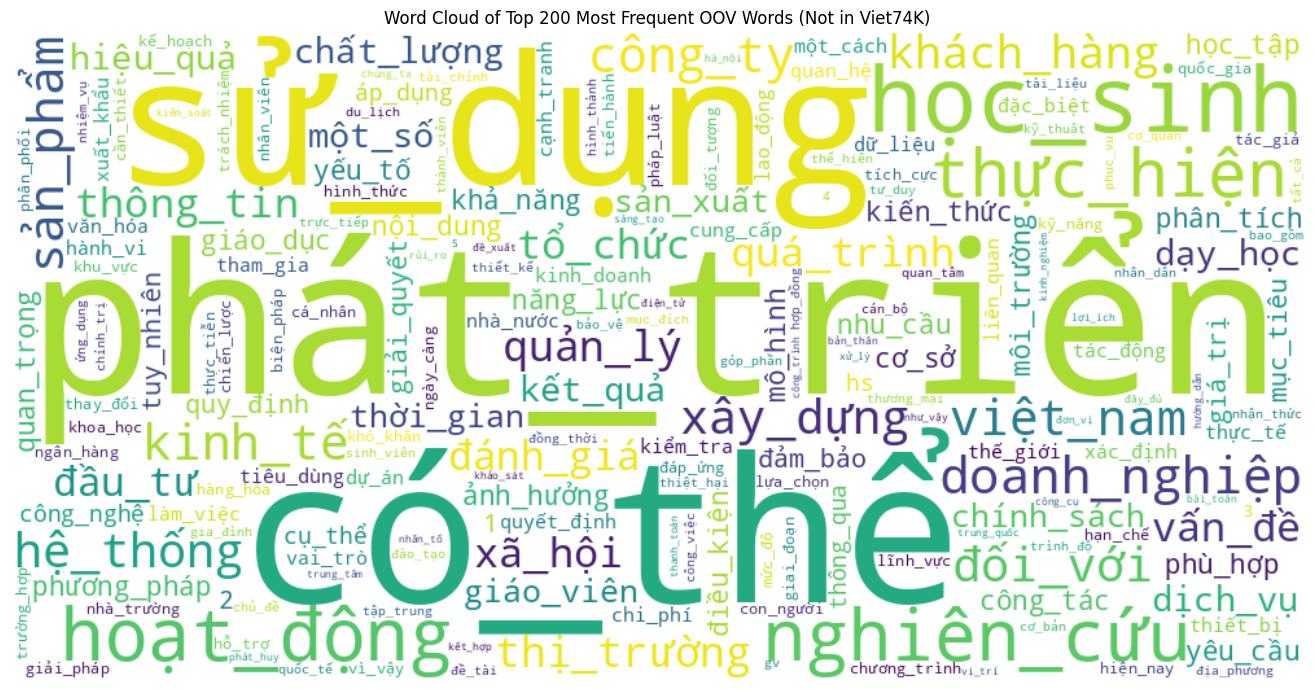

In [17]:
VIETNAMESE_FONT_PATH = None

def plot_oov_word_cloud(oov_words_counter):
    """Plots a word cloud for OOV words."""
    if not oov_words_counter:
        print("No OOV words found to plot word cloud.")
        return

    font = VIETNAMESE_FONT_PATH # Can be None

    try:
        # Get the top N most frequent OOV words for the cloud
        top_oov_words = dict(oov_words_counter.most_common(200))

        wordcloud = WordCloud(
            width=1000, height=500,
            background_color='white',
            font_path=font,
            collocations=False,
            max_words=len(top_oov_words), # Use the actual number of top words
            prefer_horizontal=0.9
        ).generate_from_frequencies(top_oov_words) # Generate from top words

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Top 200 Most Frequent OOV Words (Not in Viet74K)')
        plt.tight_layout()
        plt.savefig("oov_word_cloud.png")
        print("Saved oov_word_cloud.png")
        plt.show()

    except IOError as e:
         print(f"ERROR generating word cloud: {e}")
         if font: print(f"Check font path: '{font}'")
         print("Word cloud generation failed. Ensure a suitable font is available or leave VIETNAMESE_FONT_PATH = None.")
    except Exception as e:
        print(f"An unexpected error occurred during word cloud generation: {e}")
        print("Word cloud generation failed.")

if viet74k_vocab is not None and vocab_analysis['oov_words_counter']:
         plot_oov_word_cloud(vocab_analysis['oov_words_counter'])
elif viet74k_vocab is None:
        print("Skipping OOV word cloud because Viet74K data is unavailable.")
else:
        print("Skipping OOV word cloud as no OOV words were found.")

# Vị trí lỗi trong câu

In [18]:
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except ImportError:
    print("Warning: scipy library not found. ANOVA test will be skipped.")
    SCIPY_AVAILABLE = False

In [19]:
def calculate_error_densities(annotations):
    """
    Calculates error counts and syllable counts for start, middle, and end sections.
    """
    n_syllables = len(annotations)
    if n_syllables == 0:
        return None

    split1_idx = math.floor(0.25 * n_syllables)
    split2_idx = math.floor(0.75 * n_syllables)

    counts = {
        'start': {'errors': 0, 'syllables': 0},
        'middle': {'errors': 0, 'syllables': 0},
        'end': {'errors': 0, 'syllables': 0}
    }

    for i, ann in enumerate(annotations):
        is_correct = ann.get('is_correct', True)
        if i < split1_idx:
            section = 'start'
        elif i < split2_idx:
            section = 'middle'
        else:
            section = 'end'

        counts[section]['syllables'] += 1
        if not is_correct:
            counts[section]['errors'] += 1

    return counts

In [20]:
error_densities = {'start': [], 'middle': [], 'end': []}
processed_entries = 0
entries_with_errors = 0

print("Analyzing error positions in each entry...")
for entry in data:
    annotations = entry.get('annotations', [])
    if not annotations:
        continue

    if any(not ann.get('is_correct', True) for ann in annotations):
        entries_with_errors += 1

    section_counts = calculate_error_densities(annotations)
    if section_counts:
        processed_entries += 1
        for section in ['start', 'middle', 'end']:
            errors = section_counts[section]['errors']
            syllables = section_counts[section]['syllables']
            density = errors / syllables if syllables > 0 else 0
            error_densities[section].append(density)

print(f"Processed {processed_entries} entries.")
print(f"Found {entries_with_errors} entries with at least one error.")

if processed_entries == 0:
    print("No valid entries found to analyze.")
    exit()

Analyzing error positions in each entry...
Processed 9341 entries.
Found 9341 entries with at least one error.


In [21]:
avg_densities = {
    section: np.mean(densities) if densities else 0
    for section, densities in error_densities.items()
}

print("\n--- Average Error Density by Position ---")
for section in ['start', 'middle', 'end']:
    print(f"{section.capitalize()}: {avg_densities[section]:.4f} (errors per syllable)")


--- Average Error Density by Position ---
Start: 0.0488 (errors per syllable)
Middle: 0.0534 (errors per syllable)
End: 0.0424 (errors per syllable)


In [22]:
significant_difference = False
anova_result = None

if SCIPY_AVAILABLE:
    print("\n--- ANOVA Test for Difference in Error Densities ---")
    if all(len(d) > 1 for d in error_densities.values()):
        try:
            f_statistic, p_value = stats.f_oneway(
                error_densities['start'],
                error_densities['middle'],
                error_densities['end']
            )
            anova_result = {"f": f_statistic, "p": p_value}
            print(f"F-statistic: {f_statistic:.4f}")
            print(f"P-value: {p_value:.4f}")

            alpha = 0.05
            if p_value < alpha:
                significant_difference = True
                print("Conclusion: Statistically significant difference exists.")
            else:
                print("Conclusion: No statistically significant difference found.")
        except Exception as e:
            print(f"An error occurred during ANOVA test: {e}")
    else:
        print("Skipping ANOVA test: Not enough data points.")
else:
    print("\nANOVA test skipped as SciPy library is not available.")


--- ANOVA Test for Difference in Error Densities ---
F-statistic: 37.2439
P-value: 0.0000
Conclusion: Statistically significant difference exists.


Saved plot to error_density_by_position.png


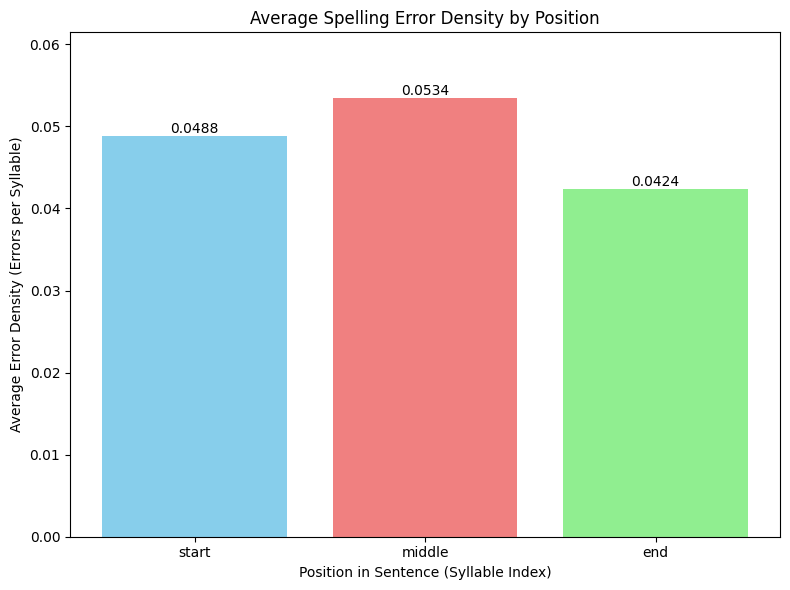

In [23]:
sections = list(avg_densities.keys())
avg_values = list(avg_densities.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(sections, avg_values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('Average Error Density (Errors per Syllable)')
plt.xlabel('Position in Sentence (Syllable Index)')
plt.title('Average Spelling Error Density by Position')
plt.ylim(0, max(avg_values) * 1.15 if max(avg_values) > 0 else 0.1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.tight_layout()
plt.savefig("error_density_by_position.png")
print("Saved plot to error_density_by_position.png")
plt.show()

In [24]:
print("\n--- Interpretation and Suggestion ---")
if avg_densities:
    max_section = max(avg_densities, key=avg_densities.get)
    max_density = avg_densities[max_section]

    if max_density == 0:
        print("No errors found or analyzed.")
    elif significant_difference:
        print(f"Errors concentrated significantly in '{max_section}' section (Avg. Density: {max_density:.4f}).")
        if max_section == 'middle':
            print("Model Suggestion: Boost attention in the middle of sequences.")
        elif max_section == 'start':
            print("Model Suggestion: Focus more on beginning of sequences.")
        elif max_section == 'end':
            print("Model Suggestion: Enhance modeling for sequence endings.")
    else:
        print(f"Highest density observed at '{max_section}' ({max_density:.4f}), but not statistically significant.")
        print("Model Suggestion: Standard sequence models (e.g., Transformer, LSTM) are sufficient.")

print("\nAnalysis complete.")


--- Interpretation and Suggestion ---
Errors concentrated significantly in 'middle' section (Avg. Density: 0.0534).
Model Suggestion: Boost attention in the middle of sequences.

Analysis complete.


# Khoảng cách giữa các lỗi

In [25]:
DISTANCE_THRESHOLDS = {'close': 3, 'medium': 10} # Syllable counts

In [26]:
print(f"Using preloaded data: {len(data)} entries.")

all_distances = []
sentence_lengths_with_errors = [] # Store length of sentences where distances were calculated
avg_distance_per_sentence = [] # Store average distance for correlation
consecutive_error_syllable_pairs = []
relative_error_positions = [] # For heatmap

print("Processing entries to calculate distances...")
processed_entries_count = 0
entries_with_ge2_errors = 0

for entry in data:
    annotations = entry.get('annotations', [])
    if not annotations:
        continue

    processed_entries_count += 1
    error_indices = [i for i, ann in enumerate(annotations) if not ann.get('is_correct', True)]
    num_errors = len(error_indices)
    sentence_syllable_length = len(annotations)

    # Store relative positions of all errors
    if sentence_syllable_length > 0:
        for idx in error_indices:
            relative_error_positions.append(idx / sentence_syllable_length)

    # 1. Preprocessing: Only consider sentences with >= 2 errors
    if num_errors >= 2:
        entries_with_ge2_errors += 1
        distances_in_sentence = []
        sentence_lengths_with_errors.append(sentence_syllable_length)

        for i in range(num_errors - 1):
            idx1 = error_indices[i]
            idx2 = error_indices[i+1]

            # Calculate distance as number of *syllables between* the two errors
            distance = idx2 - idx1 - 1
            all_distances.append(distance)
            distances_in_sentence.append(distance)

            # Store the pair of incorrect syllables
            syllable1 = annotations[idx1].get('current_syllable', '?').strip().lower()
            syllable2 = annotations[idx2].get('current_syllable', '?').strip().lower()
            # Basic cleaning of syllables for pairing
            syllable1 = ''.join(filter(str.isalnum, syllable1))
            syllable2 = ''.join(filter(str.isalnum, syllable2))
            if syllable1 and syllable2: # Only add pair if both syllables are valid
                consecutive_error_syllable_pairs.append((syllable1, syllable2))

        if distances_in_sentence:
            avg_distance_per_sentence.append(np.mean(distances_in_sentence))
        else:
            avg_distance_per_sentence.append(0)

print(f"Total entries processed: {processed_entries_count}")
print(f"Entries with >= 2 errors: {entries_with_ge2_errors}")
print(f"Total consecutive error distances calculated: {len(all_distances)}")

if not all_distances:
    print("\nNo entries with 2 or more errors found. Cannot perform distance analysis.")
    exit()

Using preloaded data: 9341 entries.
Processing entries to calculate distances...
Total entries processed: 9341
Entries with >= 2 errors: 1488
Total consecutive error distances calculated: 1861


In [27]:
min_dist = np.min(all_distances)
max_dist = np.max(all_distances)
mean_dist = np.mean(all_distances)
median_dist = np.median(all_distances)

print(f"Minimum Distance: {min_dist} syllables")
print(f"Maximum Distance: {max_dist} syllables")
print(f"Mean Distance:    {mean_dist:.2f} syllables")
print(f"Median Distance:  {median_dist:.2f} syllables")

Minimum Distance: 0 syllables
Maximum Distance: 52 syllables
Mean Distance:    8.38 syllables
Median Distance:  6.00 syllables


In [28]:
n_total_distances = len(all_distances)
close_count = sum(1 for d in all_distances if d <= DISTANCE_THRESHOLDS['close'])
medium_count = sum(1 for d in all_distances if DISTANCE_THRESHOLDS['close'] < d <= DISTANCE_THRESHOLDS['medium'])
far_count = sum(1 for d in all_distances if d > DISTANCE_THRESHOLDS['medium'])

close_pct = (close_count / n_total_distances) * 100
medium_pct = (medium_count / n_total_distances) * 100
far_pct = (far_count / n_total_distances) * 100

print("\n--- Distribution of Distances ---")
print(f"Close (<= {DISTANCE_THRESHOLDS['close']} syllables): {close_count} ({close_pct:.1f}%)")
print(f"Medium ({DISTANCE_THRESHOLDS['close']+1}-{DISTANCE_THRESHOLDS['medium']} syllables): {medium_count} ({medium_pct:.1f}%)")
print(f"Far (> {DISTANCE_THRESHOLDS['medium']} syllables):  {far_count} ({far_pct:.1f}%)")


--- Distribution of Distances ---
Close (<= 3 syllables): 710 (38.2%)
Medium (4-10 syllables): 571 (30.7%)
Far (> 10 syllables):  580 (31.2%)


In [29]:
print("\n--- Pattern Detection ---")
pair_counts = Counter(consecutive_error_syllable_pairs)
print("Most Common Consecutive Incorrect Syllable Pairs (Top 15):")
if pair_counts:
    for pair, count in pair_counts.most_common(15):
        print(f"- {pair}: {count} times")
else:
    print("No consecutive error pairs found.")


--- Pattern Detection ---
Most Common Consecutive Incorrect Syllable Pairs (Top 15):
- ('v', 'ới'): 14 times
- ('t', 'uy'): 13 times
- ('bô', 'hôị'): 7 times
- ('ạn', 'ạn'): 5 times
- ('toà', 'toà'): 4 times
- ('v', 'ai'): 3 times
- ('ảng', 'ạn'): 3 times
- ('hôị', 'hôị'): 3 times
- ('uỷ', 'uỷ'): 3 times
- ('hang', 'hang'): 3 times
- ('an', 'ạn'): 2 times
- ('lỷ', 'đìa'): 2 times
- ('t', 'rường'): 2 times
- ('cua', 'sô'): 2 times
- ('lich', 'đươc'): 2 times


In [30]:
correlation = None
correlation_p_value = None
if SCIPY_AVAILABLE:
    if len(avg_distance_per_sentence) > 1 and len(sentence_lengths_with_errors) == len(avg_distance_per_sentence):
        try:
            correlation, correlation_p_value = stats.pearsonr(sentence_lengths_with_errors, avg_distance_per_sentence)
            print(f"\nCorrelation between Sentence Length (syllables) and Average Error Distance:")
            print(f"  Pearson Correlation Coefficient: {correlation:.3f}")
            print(f"  P-value: {correlation_p_value:.3f}")
            if correlation_p_value < 0.05:
                print("  Interpretation: There is a statistically significant correlation.")
                if correlation > 0:
                    print("     -> Longer sentences tend to have larger average distances between errors.")
                elif correlation < 0:
                    print("     -> Longer sentences tend to have smaller average distances between errors.")
                else:
                    print("     -> Correlation is near zero.")
            else:
                print("  Interpretation: The correlation is not statistically significant (p >= 0.05).")
        except Exception as e:
            print(f"  Could not calculate correlation: {e}")
    else:
        print("\nNot enough data points to calculate correlation between sentence length and average error distance.")
else:
    print("\nCorrelation analysis skipped (scipy not available).")


Correlation between Sentence Length (syllables) and Average Error Distance:
  Pearson Correlation Coefficient: 0.421
  P-value: 0.000
  Interpretation: There is a statistically significant correlation.
     -> Longer sentences tend to have larger average distances between errors.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved error_distance_kde.png


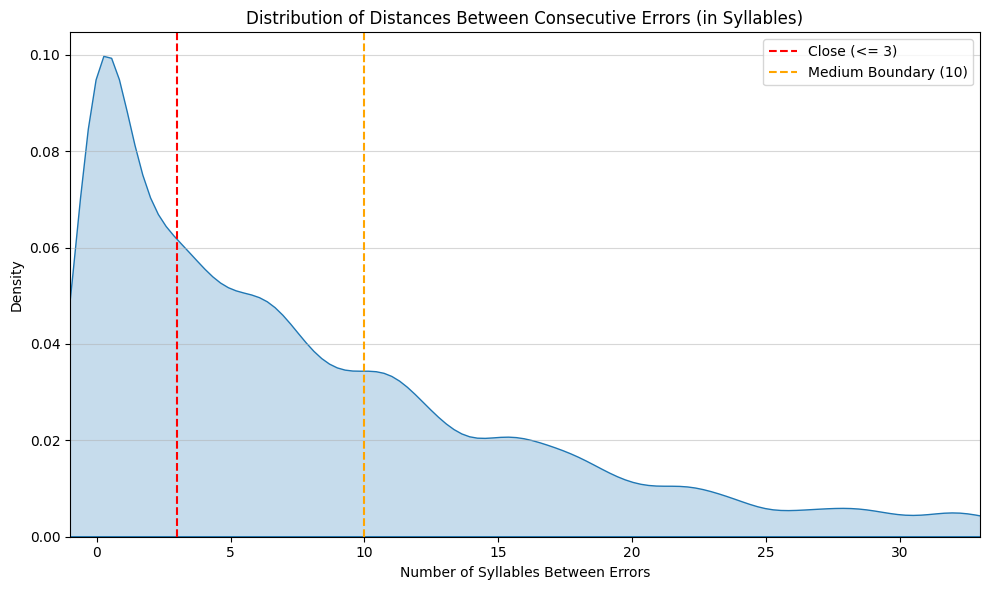

In [31]:
plt.figure(figsize=(10, 6))
sns.kdeplot(all_distances, fill=True, bw_adjust=0.5)
plt.axvline(DISTANCE_THRESHOLDS['close'], color='red', linestyle='--', label=f'Close (<= {DISTANCE_THRESHOLDS["close"]})')
plt.axvline(DISTANCE_THRESHOLDS['medium'], color='orange', linestyle='--', label=f'Medium Boundary ({DISTANCE_THRESHOLDS["medium"]})')
plt.title('Distribution of Distances Between Consecutive Errors (in Syllables)')
plt.xlabel('Number of Syllables Between Errors')
plt.ylabel('Density')
plt.xlim(left=-1, right=min(max_dist + 5, np.percentile(all_distances, 98) if all_distances else 50))
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig("error_distance_kde.png")
print("Saved error_distance_kde.png")
plt.show()

Saved error_distance_distribution_bar.png


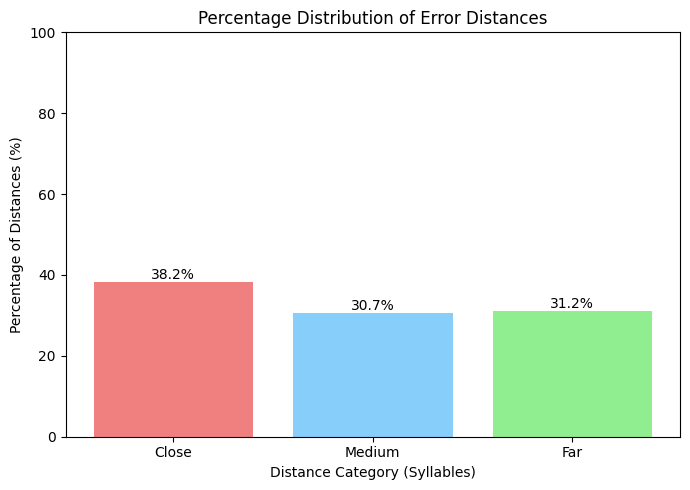

In [32]:
dist_categories = ['Close', 'Medium', 'Far']
dist_percentages = [close_pct, medium_pct, far_pct]

plt.figure(figsize=(7, 5))
bars = plt.bar(dist_categories, dist_percentages, color=['lightcoral', 'lightskyblue', 'lightgreen'])
plt.ylabel('Percentage of Distances (%)')
plt.xlabel('Distance Category (Syllables)')
plt.title('Percentage Distribution of Error Distances')
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', va='bottom', ha='center')

plt.tight_layout()
plt.savefig("error_distance_distribution_bar.png")
print("Saved error_distance_distribution_bar.png")
plt.show()

Saved error_position_heatmap.png


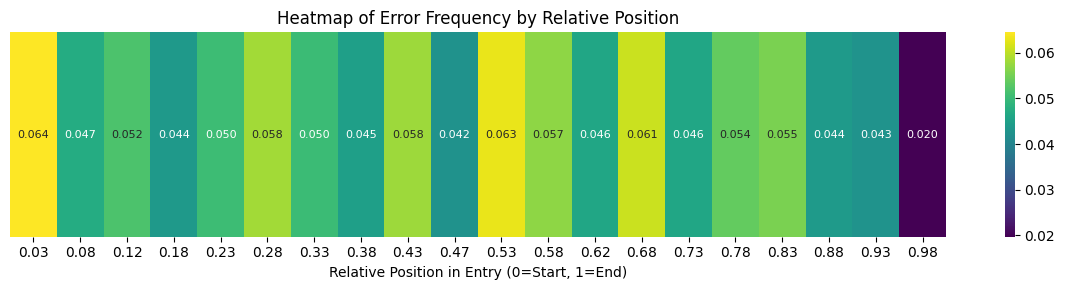

In [33]:
if relative_error_positions:
    plt.figure(figsize=(12, 3))
    num_bins = 20
    hist_data, bin_edges = np.histogram(relative_error_positions, bins=num_bins, range=(0, 1))
    hist_density = hist_data / len(relative_error_positions)

    heatmap_data = hist_density.reshape(1, -1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    x_labels = [f"{center:.2f}" for center in bin_centers]

    sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".3f",
                xticklabels=x_labels, yticklabels=False, cbar=True,
                annot_kws={"size": 8})
    plt.xlabel("Relative Position in Entry (0=Start, 1=End)")
    plt.title("Heatmap of Error Frequency by Relative Position")
    plt.yticks([])
    plt.tight_layout()
    plt.savefig("error_position_heatmap.png")
    print("Saved error_position_heatmap.png")
    plt.show()

else:
    print("No relative error positions found to generate heatmap.")

# Độ phức tạp ngôn ngữ

In [34]:
!pip install underthesea thefuzz plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.6 MB/s eta 0:00:00


In [35]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 22.1 MB/s eta 0:00:00


In [36]:
from collections import defaultdict
from underthesea import sent_tokenize, word_tokenize, pos_tag
from thefuzz import fuzz, process
import plotly.express as px
import plotly.graph_objects as go

In [37]:
IDIOMS_SLANGS_FILE_PATH = '/kaggle/input/idoms-slangs/idoms_slangs.txt'  
VIETNAMESE_FONT_PATH = None 
MIN_SENT_LEN_WORDS = 5 # Ngưỡng bỏ qua câu quá ngắn
FUZZY_MATCH_THRESHOLD = 80 # Ngưỡng cho fuzzy matching (0-100)
PLOT_DIR = "plots" 

# Regex for complex/compound sentences (checking presence)
REGEX_COMPOUND_CONJ = re.compile(r'\b(và|hoặc|hay|nhưng|mà|rồi|thì)\b', re.IGNORECASE | re.UNICODE)
REGEX_COMPLEX_CONJ_PAIR = re.compile(r'\b(nếu|tuy|dù|mặc dù|hễ|giá|miễn là|để|vì|do|bởi|tại|khi|lúc|vừa|không những|càng|bao nhiêu)\b.*?\b(thì|nên|cho nên|mà|vẫn|cũng|vừa|mà còn|càng|bấy nhiêu)\b', re.IGNORECASE | re.UNICODE | re.DOTALL)
REGEX_SUBORD_CONJ_SINGLE = re.compile(r'\b(rằng|là|mà|để|cho)\b', re.IGNORECASE | re.UNICODE)

# Regex for sentence types (C)
REGEX_C_QUESTION = re.compile(r'.*\?$|(\b(không|nào|ai|đâu|sao|gì|bao giờ|bao lâu|bao nhiêu|vì sao)\b.*$)', re.IGNORECASE | re.UNICODE | re.DOTALL)
REGEX_C_COMMAND = re.compile(r'^\s*(hãy|đừng|phải|nên|yêu cầu|khuyên)\b.*?[.!]?$', re.IGNORECASE | re.UNICODE | re.DOTALL)
REGEX_C_SHORT = re.compile(r'^\s*([^\s,.?!]+[.?!]?|[A-ZĐ][a-zàáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]+[.?!]?)\s*$', re.UNICODE)

# Ensure plot directory exists
os.makedirs(PLOT_DIR, exist_ok=True)

In [38]:
def load_idioms_slang(filepath):
    """Loads idioms and slang, skipping comments, returns set and list."""
    terms_set = set()
    terms_list = []
    line_num = 0
    if not os.path.exists(filepath):
        print(f"ERROR: Idioms/Slang file not found at: {filepath}")
        return None, None
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f):
                cleaned_line = line.strip()
                if cleaned_line and not cleaned_line.startswith('#'):
                    term = re.sub(r'\s+', ' ', cleaned_line).lower()
                    if term and term not in terms_set:
                        terms_set.add(term)
                        terms_list.append(term)
        print(f"Loaded {len(terms_set)} unique idioms/slang terms from {filepath}")
        if not terms_set: print("Warning: No terms loaded from idioms/slang file.")
        return terms_set, terms_list
    except Exception as e:
        print(f"Error loading idioms/slang file at line {line_num+1}: {e}")
        return None, None

In [39]:
def reconstruct_text_with_error_map(annotations):
    """Reconstructs text and creates a map from syllable index to error status and char span."""
    if not annotations: return "", {}, 0, 0
    text = ""; syllable_map = {}; current_char_index = 0; error_count = 0
    for i, ann in enumerate(annotations):
        syllable = ann.get('current_syllable', ''); is_correct = ann.get('is_correct', True)
        syllable_strip = syllable.strip()
        if not is_correct: error_count += 1
        start_char = current_char_index; end_char = start_char + len(syllable)
        syllable_map[i] = {'text': syllable_strip, 'is_correct': is_correct, 'start_char': start_char, 'end_char': end_char}
        # Add space intelligently
        if i > 0 and not text.endswith(' ') and syllable and not re.match(r'^[\s,.!?]+', syllable):
            text += " "; current_char_index += 1
        text += syllable; current_char_index += len(syllable)
    # Final cleanup
    text_clean = re.sub(r'\s+', ' ', text).strip()
    text_clean = re.sub(r'\s+([,.!?])', r'\1', text_clean); text_clean = re.sub(r'([({[])\s+', r'\1', text_clean); text_clean = re.sub(r'\s+([)}\]])', r'\1', text_clean)
    return text_clean, syllable_map, error_count, len(annotations)

def count_clauses_heuristic_pos(sentence):
    """Heuristic clause counting using POS tags from underthesea."""
    try:
        tagged_words = pos_tag(sentence)
        verb_count = sum(1 for _, tag in tagged_words if tag in ['V', 'AUX'])
        sub_conj_count = sum(1 for word, tag in tagged_words if tag in ['C', 'SCONJ'] or word.lower() in ["rằng", "là", "mà"])
        estimated_clauses = max(1, verb_count)
        if sub_conj_count > 0 and verb_count > 0 :
             estimated_clauses = max(2, estimated_clauses)
        estimated_clauses = min(estimated_clauses, verb_count + sub_conj_count + 1)
        return estimated_clauses
    except Exception as e:
        # print(f"POS tagging/clause counting failed: {e}") # Optional debug
        return 1 # Fallback

def classify_sentence_structure(sentence, clause_count):
    """Classifies sentence structure based on clause count and regex conjunction checks."""
    if clause_count <= 1:
        if REGEX_COMPOUND_CONJ.search(sentence) or REGEX_COMPLEX_CONJ_PAIR.search(sentence) or REGEX_SUBORD_CONJ_SINGLE.search(sentence):
             return 'compound/complex_unsure'
        else: return 'simple'
    is_complex_pattern = REGEX_COMPLEX_CONJ_PAIR.search(sentence) or REGEX_SUBORD_CONJ_SINGLE.search(sentence)
    is_compound_pattern = REGEX_COMPOUND_CONJ.search(sentence)
    if is_complex_pattern: return 'complex'
    elif is_compound_pattern: return 'compound'
    else: return 'compound/complex_unsure'

def map_char_span_to_syllable_indices(char_start, char_end, syllable_map):
    """Approximate mapping from character span to syllable indices."""
    syllable_indices = []
    if not syllable_map: return []
    last_syllable_idx = max(syllable_map.keys()) if syllable_map else -1
    for i in range(last_syllable_idx + 1):
         if i in syllable_map:
             syl_start = syllable_map[i]['start_char']
             syl_end = syllable_map[i]['end_char']
             if syl_start < char_end and syl_end > char_start: # Overlap check
                 syllable_indices.append(i)
    return syllable_indices

def classify_text_block_type_regex(text_block):
    """Classifies text block type using enhanced regex."""
    text_strip = text_block.strip()
    text_lower = text_strip.lower()
    approx_word_count = len(text_strip.split())
    # Order matters
    if REGEX_C_SHORT.match(text_strip) and approx_word_count <= 5: return 'short'
    elif REGEX_C_QUESTION.search(text_strip): return 'question'
    elif REGEX_C_COMMAND.match(text_strip): return 'command'
    else: return 'declarative/other'

In [40]:
idioms_slang_list = load_idioms_slang(IDIOMS_SLANGS_FILE_PATH)

analysis_results = []
all_sentences_data = [] # Lưu data từng câu sau khi tách
all_found_idioms_freq = Counter()
all_found_variants = defaultdict(list)
idiom_error_analysis = [] # List of {'term': term, 'has_error': bool}

start_time = time.time()
processed_sentence_count = 0
skipped_short_sentences = 0

Loaded 299 unique idioms/slang terms from /kaggle/input/idoms-slangs/idoms_slangs.txt


In [41]:
for i, entry in enumerate(data):
    annotations = entry.get('annotations', [])
    if not annotations: continue

    text_block, syllable_map, block_error_count, block_syllable_count = reconstruct_text_with_error_map(annotations)
    if not text_block: continue

    # A.1 Tách câu
    sentences = []
    try:
        sentences = sent_tokenize(text_block)
    except Exception as e:
        # Fallback if sentence tokenization fails unexpectedly
        print(f"Warning: Sentence tokenization failed for entry {i}. Using full block. Error: {e}")
        sentences = [text_block]

    current_char_offset_in_block = 0
    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence: continue

        sentence_word_tokens = []
        sentence_len_words = 0
        try:
             sentence_word_tokens = word_tokenize(sentence)
             sentence_len_words = len(sentence_word_tokens)
        except Exception as e:
             # Fallback if word tokenization fails
             print(f"Warning: Word tokenization failed for sentence. Using split(). Error: {e}")
             sentence_word_tokens = sentence.split()
             sentence_len_words = len(sentence_word_tokens)

        # A.1 Bỏ qua câu ngắn
        if sentence_len_words < MIN_SENT_LEN_WORDS:
            skipped_short_sentences += 1
            current_char_offset_in_block += len(sentence) + 1
            continue

        processed_sentence_count += 1

        # --- A: Phân tích câu phức/ghép (Heuristic) ---
        clause_count = count_clauses_heuristic_pos(sentence)
        sentence_structure_type = classify_sentence_structure(sentence, clause_count)

        # --- B: Thành ngữ/Tiếng lóng ---
        found_idioms_in_sent = []
        found_terms_data = []
        sentence_lower = sentence.lower()
        sentence_contains_idiom = False

        # B.2.a: Exact Matching
        for term in idioms_slang_list:
            try:
                for match in re.finditer(r'\b' + re.escape(term) + r'\b', sentence_lower):
                     found_idioms_in_sent.append(term)
                     all_found_idioms_freq[term] += 1
                     found_terms_data.append({'term': term, 'start': match.start(), 'end': match.end()})
                     sentence_contains_idiom = True
            except Exception: continue

        # B.2.b: Phân tích lỗi BÊN TRONG thành ngữ
        errors_in_idiom_instances_sent = 0
        syllables_in_idiom_instances_sent = 0
        processed_syllable_indices_in_idioms = set()
        if sentence_contains_idiom:
             for term_match in found_terms_data:
                 term = term_match['term']
                 term_instance_has_error_flag = False
                 block_start_char = current_char_offset_in_block + term_match['start']
                 block_end_char = current_char_offset_in_block + term_match['end']
                 mapped_syllable_indices = map_char_span_to_syllable_indices(block_start_char, block_end_char, syllable_map)
                 instance_syllable_count_term = 0
                 if mapped_syllable_indices:
                     for syl_idx in mapped_syllable_indices:
                         if syl_idx not in processed_syllable_indices_in_idioms and syl_idx in syllable_map:
                             instance_syllable_count_term += 1
                             processed_syllable_indices_in_idioms.add(syl_idx)
                             if not syllable_map[syl_idx]['is_correct']:
                                 errors_in_idiom_instances_sent += 1
                                 term_instance_has_error_flag = True
                     syllables_in_idiom_instances_sent += instance_syllable_count_term
                 idiom_error_analysis.append({'term': term, 'has_error': term_instance_has_error_flag})

        # B.3: Fuzzy Matching (Variant Detection)
        variants_found_in_sent = []
        if idioms_slang_list and sentence_word_tokens:
            processed_ngrams_sent = set()
            ngram_range = range(2, max(4, min(len(sentence_word_tokens), 8)))
            for n in ngram_range:
                 for k in range(len(sentence_word_tokens) - n + 1):
                     ngram = " ".join(sentence_word_tokens[k : k+n]).lower()
                     if ngram in processed_ngrams_sent or len(ngram) < 5: continue
                     processed_ngrams_sent.add(ngram)
                     relevant_idioms = idioms_slang_list
                     if not relevant_idioms: continue
                     best_matches = process.extract(ngram, relevant_idioms, scorer=fuzz.token_set_ratio, limit=1)
                     if best_matches:
                         best_match, score = best_matches[0]
                         if score >= FUZZY_MATCH_THRESHOLD and best_match != ngram:
                             is_submatch = any(exact_term in ngram or ngram in exact_term for exact_term in found_idioms_in_sent)
                             if not is_submatch:
                                  variant_info = {'original': best_match, 'variant': ngram, 'score': score}
                                  variants_found_in_sent.append(variant_info)
                                  if isinstance(best_match, set):
                                      best_match = " ".join(best_match)
                                      
                                      
                                  all_found_variants[best_match].append(ngram)

        # --- C: Kiểu câu ---
        sentence_type = classify_text_block_type_regex(sentence)

        # --- Lỗi tổng thể của câu ---
        error_count_in_sentence = 0
        syllable_count_in_sentence = 0
        sentence_char_start = current_char_offset_in_block
        sentence_char_end = sentence_char_start + len(sentence)
        sentence_syllable_indices = map_char_span_to_syllable_indices(sentence_char_start, sentence_char_end, syllable_map)
        if sentence_syllable_indices:
             syllable_count_in_sentence = len(sentence_syllable_indices)
             for syl_idx in sentence_syllable_indices:
                 if syl_idx in syllable_map and not syllable_map[syl_idx]['is_correct']:
                     error_count_in_sentence += 1
        approx_error_rate = error_count_in_sentence / syllable_count_in_sentence if syllable_count_in_sentence > 0 else 0

        # Lưu kết quả
        analysis_results.append({
            'entry_index': i, 'sentence': sentence, 'sentence_len_words': sentence_len_words,
            'sentence_len_syllables': syllable_count_in_sentence,
            'clause_count_heuristic': clause_count, 'sentence_structure_type': sentence_structure_type,
            'contains_idiom_slang': sentence_contains_idiom, 'found_idioms': found_idioms_in_sent,
            'found_variants': variants_found_in_sent, 'sentence_type_regex': sentence_type,
            'error_count': error_count_in_sentence, 'error_rate': approx_error_rate,
            'errors_in_idioms_instance': errors_in_idiom_instances_sent,
            'syllables_in_idioms_instance': syllables_in_idiom_instances_sent
        })
        current_char_offset_in_block += len(sentence) + 1

    if (i + 1) % 500 == 0:
        elapsed = time.time() - start_time
        print(f"  Processed {i+1}/{len(data)} entries. Time elapsed: {elapsed:.2f}s")


# --- Create DataFrame and Summarize ---
df_analysis = pd.DataFrame(analysis_results)
print(f"\n--- Finished Analysis ({time.time() - start_time:.2f} seconds) ---")
print(f"Total sentences analyzed (>= {MIN_SENT_LEN_WORDS} words): {processed_sentence_count}")
print(f"Total sentences skipped (< {MIN_SENT_LEN_WORDS} words): {skipped_short_sentences}")
if df_analysis.empty: print("WARNING: Analysis DataFrame is empty! Check input data and filters."); exit()
print(f"Final DataFrame shape: {df_analysis.shape}")

  Processed 500/9341 entries. Time elapsed: 80.65s
  Processed 1000/9341 entries. Time elapsed: 161.41s
  Processed 1500/9341 entries. Time elapsed: 245.11s
  Processed 2000/9341 entries. Time elapsed: 325.87s
  Processed 2500/9341 entries. Time elapsed: 408.90s
  Processed 3000/9341 entries. Time elapsed: 492.93s
  Processed 3500/9341 entries. Time elapsed: 579.68s
  Processed 4000/9341 entries. Time elapsed: 663.02s
  Processed 4500/9341 entries. Time elapsed: 747.04s
  Processed 5000/9341 entries. Time elapsed: 830.07s
  Processed 5500/9341 entries. Time elapsed: 913.35s
  Processed 6000/9341 entries. Time elapsed: 997.71s
  Processed 6500/9341 entries. Time elapsed: 1077.29s
  Processed 7000/9341 entries. Time elapsed: 1159.26s
  Processed 7500/9341 entries. Time elapsed: 1239.73s
  Processed 8000/9341 entries. Time elapsed: 1323.86s
  Processed 8500/9341 entries. Time elapsed: 1405.30s
  Processed 9000/9341 entries. Time elapsed: 1494.81s

--- Finished Analysis (1563.40 seconds) -

In [42]:
print("\n--- Sentence Structure Analysis (Heuristic/Underthesea) ---")
structure_dist = df_analysis['sentence_structure_type'].value_counts(normalize=True).map("{:.1%}".format)
print("- Distribution of Sentence Structure Types:")
print(structure_dist)
complex_compound_rate = df_analysis['sentence_structure_type'].isin(['complex', 'compound', 'compound/complex_unsure']).mean() * 100
print(f"- Approx. Rate of Complex/Compound Sentences: {complex_compound_rate:.2f}%")
print("- Avg Length (words) by Sentence Structure:")
print(df_analysis.groupby('sentence_structure_type')['sentence_len_words'].agg(['mean', 'median', 'count']))


--- Sentence Structure Analysis (Heuristic/Underthesea) ---
- Distribution of Sentence Structure Types:
sentence_structure_type
complex                    52.5%
compound/complex_unsure    23.6%
compound                   20.6%
simple                      3.4%
Name: proportion, dtype: object
- Approx. Rate of Complex/Compound Sentences: 96.59%
- Avg Length (words) by Sentence Structure:
                              mean  median  count
sentence_structure_type                          
complex                  27.480989    27.0   4892
compound                 23.992179    23.0   1918
compound/complex_unsure  18.461994    17.0   2197
simple                    9.946541     9.0    318


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved plots/clause_distribution_histogram.png


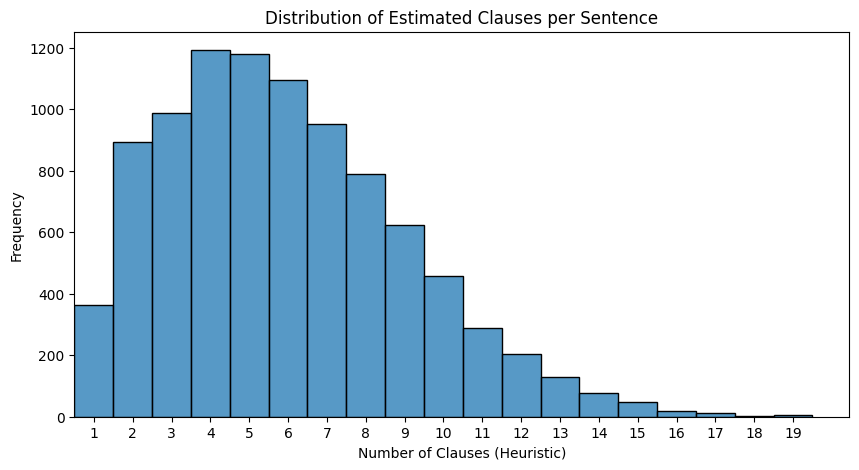

In [43]:
plt.figure(figsize=(10, 5))
clause_data = df_analysis['clause_count_heuristic'].dropna().astype(int)
if not clause_data.empty and clause_data.max() > 0:
    bins = range(1, clause_data.max() + 2)
    sns.histplot(clause_data, bins=bins, kde=False, discrete=True)
    plt.title('Distribution of Estimated Clauses per Sentence')
    plt.xlabel('Number of Clauses (Heuristic)'); plt.ylabel('Frequency')
    plt.xticks(bins[:-1]); plt.xlim(left=0.5)
    plt.savefig(os.path.join(PLOT_DIR, "clause_distribution_histogram.png"))
    print(f"Saved {PLOT_DIR}/clause_distribution_histogram.png")
    plt.show() # Uncomment in interactive environment
else: print("- No clause count data for histogram.")

Saved plots/boxplot_length_by_structure.png


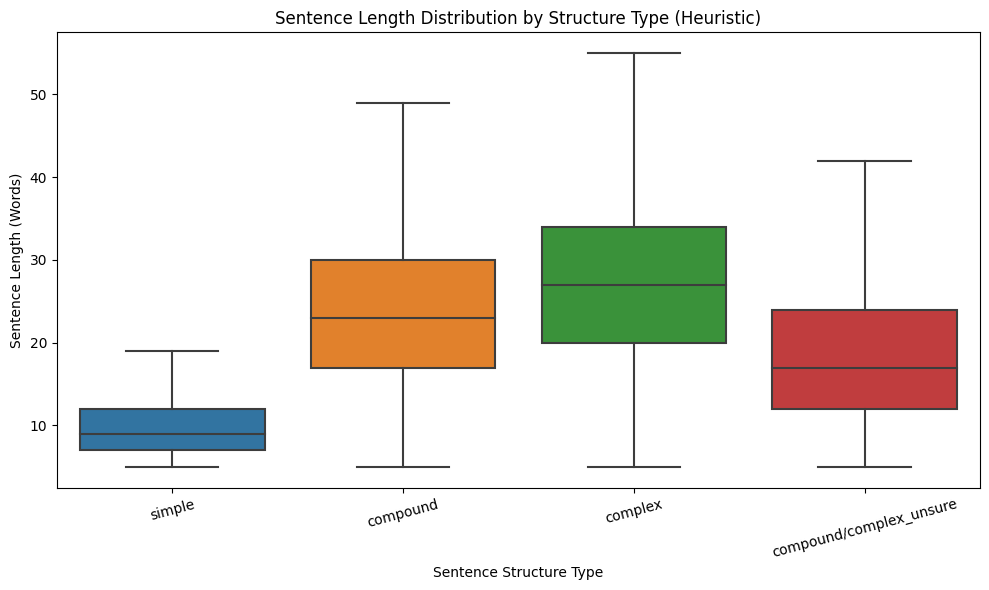

In [44]:
plt.figure(figsize=(10, 6))
struct_order = ['simple', 'compound', 'complex', 'compound-complex', 'compound/complex_unsure', 'unknown'] # Add 'unknown' if needed
plot_order = [s for s in struct_order if s in df_analysis['sentence_structure_type'].unique()]
sns.boxplot(data=df_analysis, x='sentence_structure_type', y='sentence_len_words', showfliers=False, order=plot_order)
plt.title('Sentence Length Distribution by Structure Type (Heuristic)')
plt.xlabel('Sentence Structure Type'); plt.ylabel('Sentence Length (Words)')
plt.xticks(rotation=15); plt.tight_layout(); plt.savefig(os.path.join(PLOT_DIR, "boxplot_length_by_structure.png"))
print(f"Saved {PLOT_DIR}/boxplot_length_by_structure.png")
plt.show()

In [45]:
df_analysis['error_rate_category'] = pd.cut(df_analysis['error_rate'], bins=[-0.01, 0.001, 0.05, 0.1, 1.1], labels=['No Error', 'Low (<=5%)', 'Medium (5-10%)', 'High (>10%)'], right=True)
sunburst_data = df_analysis.dropna(subset=['sentence_structure_type', 'error_rate_category']).copy()
sunburst_data['sentence_structure_type'] = sunburst_data['sentence_structure_type'].replace('compound/complex_unsure', 'Unsure')
sunburst_data['root'] = 'Total'
sunburst_agg = sunburst_data.groupby(['root','sentence_structure_type', 'error_rate_category'], observed=False).size().reset_index(name='count')

if not sunburst_agg.empty:
    try:
        fig_sunburst = px.sunburst(sunburst_agg, path=['root','sentence_structure_type', 'error_rate_category'], values='count',
                                   title='Sentence Structure vs. Error Rate Distribution', color='error_rate_category',
                                   color_discrete_map={'No Error':'#2ECC71', 'Low (<=5%)':'#F1C40F', 'Medium (5-10%)':'#E67E22', 'High (>10%)':'#E74C3C', '?':'grey'})
        fig_sunburst.update_layout(margin=dict(t=50, l=10, r=10, b=10))
        fig_sunburst.update_traces(hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Parent: %{parent}')  # Tooltip info
        fig_sunburst.show()  # For interactive view in the notebook
    except Exception as e:
        print(f"Failed to generate Sunburst: {e}")
else:
    print("No data for Sunburst chart.")

/usr/local/lib/python3.11/dist-packages/plotly/express/_core.py:1727: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df.groupby(path[i:]).agg(agg_f)


In [46]:
print("\n--- Idioms and Slang Analysis ---")
print(f"- Top 10 Most Frequent Idioms/Slang Found ({len(all_found_idioms_freq)} total unique):")
if all_found_idioms_freq:
    for term, count in all_found_idioms_freq.most_common(10): print(f"  - {term}: {count}")
else: print("  - None found.")
avg_len_matched_overall = np.mean([len(term.split()) for term in all_found_idioms_freq.elements()]) if all_found_idioms_freq else 0
print(f"- Average Length (words/syllables approx.) of found idioms/slang: {avg_len_matched_overall:.2f}")
avg_error_rate_with_idiom = df_analysis[df_analysis['contains_idiom_slang']]['error_rate'].mean()
avg_error_rate_without_idiom = df_analysis[~df_analysis['contains_idiom_slang']]['error_rate'].mean()
print(f"- Average Error Rate in sentences WITH idioms/slang: {avg_error_rate_with_idiom:.4f}")
print(f"- Average Error Rate in sentences WITHOUT idioms/slang: {avg_error_rate_without_idiom:.4f}")


--- Idioms and Slang Analysis ---
- Top 10 Most Frequent Idioms/Slang Found (0 total unique):
  - None found.
- Average Length (words/syllables approx.) of found idioms/slang: 0.00
- Average Error Rate in sentences WITH idioms/slang: nan
- Average Error Rate in sentences WITHOUT idioms/slang: 0.0489


In [47]:
term_error_df = pd.DataFrame(idiom_error_analysis)
if not term_error_df.empty:
    term_error_rate_summary = term_error_df.groupby('term')['has_error'].agg(['mean', 'count'])
    term_error_rate_summary.columns = ['error_rate_in_instance', 'instance_count']
    term_error_rate_summary = term_error_rate_summary[term_error_rate_summary['instance_count'] > 1] # Filter for terms appearing > once
    term_error_rate_summary = term_error_rate_summary.sort_values(by='error_rate_in_instance', ascending=False)
    print("- Approx. Error Rate within Idiom Instances (term appears > 1 time):")
    print(term_error_rate_summary.head(10).to_string(float_format='{:.2%}'.format))
    overall_idiom_error_rate = term_error_df['has_error'].mean()
    print(f"- Overall rate of idiom instances containing errors: {overall_idiom_error_rate:.2%}")

    # B.4 Bar chart top 10 error rate
    if not term_error_rate_summary.empty:
        top_error_terms = term_error_rate_summary.head(10)
        plt.figure(figsize=(12, 6)); sns.barplot(x=top_error_terms.index, y=top_error_terms['error_rate_in_instance'], palette='Reds_r')
        plt.title('Top 10 Idioms/Slang by Instance Error Rate (Approx.)'); plt.xlabel('Idiom/Slang Term'); plt.ylabel('Error Rate within Instances (%)')
        plt.xticks(rotation=45, ha='right'); plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        plt.tight_layout(); plt.savefig(os.path.join(PLOT_DIR, "top_idioms_by_error_rate.png"))
        print(f"Saved {PLOT_DIR}/top_idioms_by_error_rate.png")
        plt.show()
    else: print("- No terms appeared > 1 time to rank error rates.")
else: print("- No idiom instances found to calculate error rates.")

- No idiom instances found to calculate error rates.


In [48]:
print("- Top Variant Analysis (Fuzzy Match):")
variant_counts = Counter(var for term_vars in all_found_variants.values() for var in term_vars)
print("  - Top 10 most common variants found:")
if variant_counts:
    for variant, count in variant_counts.most_common(10): print(f"    - '{variant}': {count} times")
else: print("    - No significant variants found.")
print("  - Top variants with errors: Skipped (requires complex error mapping).")

- Top Variant Analysis (Fuzzy Match):
  - Top 10 most common variants found:
    - 'của các': 323 times
    - 'là một': 307 times
    - ', các': 268 times
    - 'và các': 198 times
    - 'của mình': 179 times
    - 'cho các': 169 times
    - 'của người': 166 times
    - 'cũng như': 164 times
    - 'khác nhau': 151 times
    - 'các em': 143 times
  - Top variants with errors: Skipped (requires complex error mapping).


In [49]:
print("Generating Idiom/Slang Word Cloud...")
if all_found_idioms_freq:
    try:
        error_term_set_b4 = set(term_error_df[term_error_df['has_error']]['term']) if not term_error_df.empty else set()
        def color_func_simple_b4(word, **kwargs): return "#E74C3C" if word in error_term_set_b4 else "#3498DB"
        wordcloud = WordCloud(width=1000, height=500, background_color='white', font_path=VIETNAMESE_FONT_PATH, collocations=False, max_words=150, color_func=color_func_simple_b4).generate_from_frequencies(all_found_idioms_freq)
        plt.figure(figsize=(15, 7)); plt.imshow(wordcloud, interpolation='bilinear'); plt.axis('off')
        plt.title('Word Cloud of Found Idioms & Slang (Color: Instance had error?)'); plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "idiom_slang_wordcloud_error_color.png"))
        print(f"Saved {PLOT_DIR}/idiom_slang_wordcloud_error_color.png")
        plt.show()
    except Exception as e: print(f"ERROR generating word cloud: {e}")
else: print("Skipping Idiom/Slang Word Cloud: No terms found.")

Generating Idiom/Slang Word Cloud...
Skipping Idiom/Slang Word Cloud: No terms found.


In [50]:
print("\n--- Sentence Type Analysis (Regex based) ---")
type_dist_c = df_analysis['sentence_type_regex'].value_counts(normalize=True).map("{:.1%}".format)
print("- Distribution of Sentence Types:")
print(type_dist_c.to_string())
print("- Avg Length (words) by Sentence Type:")
print(df_analysis.groupby('sentence_type_regex')['sentence_len_words'].agg(['mean', 'median', 'count']))
error_stats_by_type_c = df_analysis.groupby('sentence_type_regex')['error_rate'].agg(['mean', 'median', 'count'])
print("- Error Rate Stats by Sentence Type:")
print(error_stats_by_type_c)


--- Sentence Type Analysis (Regex based) ---
- Distribution of Sentence Types:
sentence_type_regex
declarative/other    84.0%
question             15.7%
command               0.3%
- Avg Length (words) by Sentence Type:
                          mean  median  count
sentence_type_regex                          
command              18.413793    18.0     29
declarative/other    23.330993    23.0   7834
question             27.954172    28.0   1462
- Error Rate Stats by Sentence Type:
                         mean    median  count
sentence_type_regex                           
command              0.058510  0.055556     29
declarative/other    0.050232  0.040000   7834
question             0.041342  0.033333   1462


In [51]:
print("- ANOVA Test on Error Rates by Sentence Type:")
if not df_analysis.empty:
    groups_c = [df_analysis[df_analysis['sentence_type_regex'] == type_name]['error_rate'].dropna() for type_name in error_stats_by_type_c.index]
    groups_c = [g for g in groups_c if len(g) > 1]
    if len(groups_c) >= 2:
        try:
            f_stat_c, p_value_c = stats.f_oneway(*groups_c)
            print(f"  - F-statistic: {f_stat_c:.4f}, P-value: {p_value_c:.4f}")
            if p_value_c < 0.05: print("  - Conclusion: Significant difference in mean error rates found.")
            else: print("  - Conclusion: No significant difference found.")
        except ValueError as ve: print(f"  - ANOVA failed: Check if groups have variance. {ve}")
        except Exception as e: print(f"  - ANOVA test failed: {e}")
    else: print("  - Skipping ANOVA: Not enough groups (>1 sample per group needed).")
else: print("  - Skipping ANOVA: DataFrame empty.")

- ANOVA Test on Error Rates by Sentence Type:
  - F-statistic: 46.2491, P-value: 0.0000
  - Conclusion: Significant difference in mean error rates found.


Generating Pie Chart for Sentence Type Distribution...
Saved plots/sentence_type_piechart.png


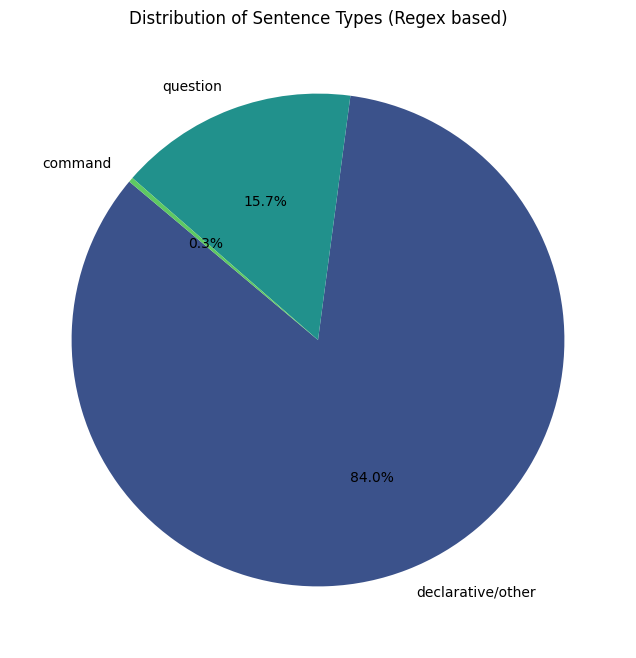

In [52]:
print("Generating Pie Chart for Sentence Type Distribution...")
pie_data = df_analysis['sentence_type_regex'].value_counts()
if not pie_data.empty:
     plt.figure(figsize=(8, 8))
     plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(pie_data)))
     plt.title('Distribution of Sentence Types (Regex based)')
     plt.savefig(os.path.join(PLOT_DIR, "sentence_type_piechart.png"))
     print(f"Saved {PLOT_DIR}/sentence_type_piechart.png")
     plt.show()
else: print("Skipping Pie Chart: No sentence type data.")

Generating Heatmap (Sentence Type vs Error Rate Category)...
Saved plots/heatmap_type_vs_error_rate_prop.png


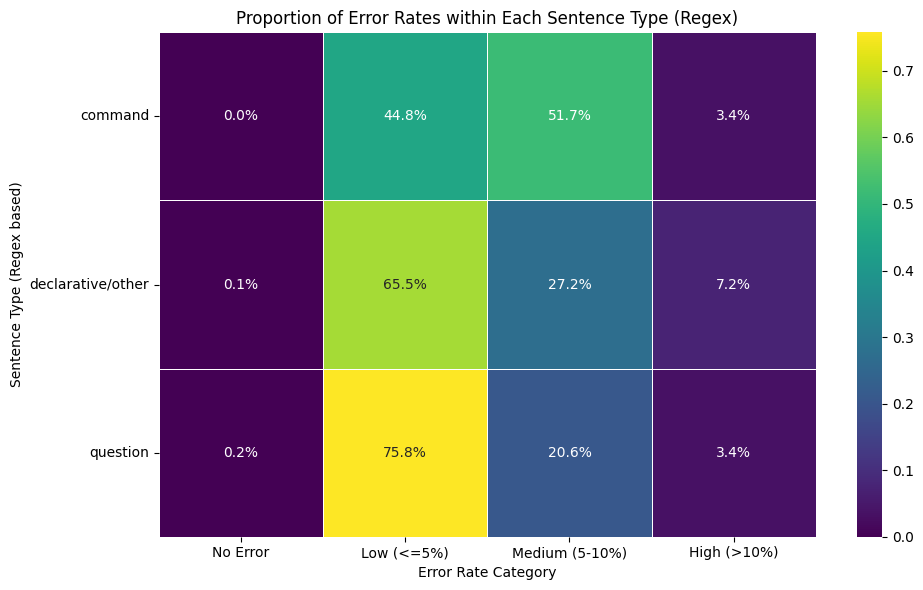

In [53]:
print("Generating Heatmap (Sentence Type vs Error Rate Category)...")
if not df_analysis.empty and 'error_rate_category' in df_analysis.columns:
     heatmap_data_c = df_analysis.groupby(['sentence_type_regex', 'error_rate_category'], observed=False).size().unstack(fill_value=0)
     heatmap_data_c_norm = heatmap_data_c.apply(lambda x: x / x.sum() if x.sum() > 0 else x, axis=1) # Normalize by row
     if not heatmap_data_c_norm.empty:
         plt.figure(figsize=(10, 6))
         sns.heatmap(heatmap_data_c_norm, annot=True, fmt=".1%", cmap="viridis", linewidths=.5, annot_kws={"size": 10})
         plt.title('Proportion of Error Rates within Each Sentence Type (Regex)')
         plt.xlabel('Error Rate Category'); plt.ylabel('Sentence Type (Regex based)')
         plt.xticks(rotation=0); plt.yticks(rotation=0); plt.tight_layout()
         plt.savefig(os.path.join(PLOT_DIR, "heatmap_type_vs_error_rate_prop.png"))
         print(f"Saved {PLOT_DIR}/heatmap_type_vs_error_rate_prop.png")
         plt.show()
     else: print("Skipping Heatmap: No data after grouping.")
else: print("Skipping Heatmap: Analysis DataFrame empty or missing error categories.")   

In [54]:
print("Code includes generation for individual plots (Sunburst requires Plotly).")
print("Creating a fully interactive dashboard with tooltips and filters typically requires frameworks like Dash or Streamlit.")
print(f"Plots saved in '{PLOT_DIR}/' directory.")

total_time = time.time() - start_time
print(f"\n Total Time: {total_time:.2f} seconds ---")

Code includes generation for individual plots (Sunburst requires Plotly).
Creating a fully interactive dashboard with tooltips and filters typically requires frameworks like Dash or Streamlit.
Plots saved in 'plots/' directory.

 Total Time: 1569.10 seconds ---


# Phân bố lỗi theo chủ đề

In [55]:
import unicodedata
# ML/NLP Libs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE 

# Stats Libs
from scipy.stats import ttest_ind, f_oneway
from scipy.spatial.distance import jensenshannon 
from math import log2 

# Visualization Libs
import matplotlib.cm as cm 
import networkx as nx 
import plotly.graph_objects as go

In [56]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore KMeans memory leak warning on Windows

In [57]:
STOPWORDS_PATH = '/kaggle/input/vietnamese-stopwords/vietnamese-stopwords.txt'
PLOT_DIR = "plots_domain_analysis"
DEFAULT_K = 6 # !!! ADJUST K BASED ON ELBOW/SILHOUETTE PLOTS !!!
N_TOP_WORDS_PER_CLUSTER = 15
KL_DIVERGENCE_THRESHOLD = 0.7 # For JS Distance, might need adjustment (e.g., 0.4)
ERROR_FREQ_THRESHOLD = 0.15
ERROR_RATE_DIFF_THRESHOLD = 0.20
MIN_SENT_LEN_WORDS = 5        # Min words per sentence for analysis A
FUZZY_MATCH_THRESHOLD = 80    # Threshold for fuzzy matching (0-100)
VIETNAMESE_FONT_PATH = None   # Specify path to .ttf font if wordcloud fails

In [58]:
REGEX_COMPOUND_CONJ = re.compile(r'\b(và|hoặc|hay|nhưng|mà|rồi|thì)\b', re.IGNORECASE | re.UNICODE)
REGEX_COMPLEX_CONJ_PAIR = re.compile(r'\b(nếu|tuy|dù|mặc dù|hễ|giá|miễn là|để|vì|do|bởi|tại|khi|lúc|vừa|không những|càng|bao nhiêu)\b.*?\b(thì|nên|cho nên|mà|vẫn|cũng|vừa|mà còn|càng|bấy nhiêu)\b', re.IGNORECASE | re.UNICODE | re.DOTALL)
REGEX_SUBORD_CONJ_SINGLE = re.compile(r'\b(rằng|là|mà|để|cho)\b', re.IGNORECASE | re.UNICODE)
REGEX_C_QUESTION = re.compile(r'.*\?$|(\b(không|nào|ai|đâu|sao|gì|bao giờ|bao lâu|bao nhiêu|vì sao)\b.*$)', re.IGNORECASE | re.UNICODE | re.DOTALL)
REGEX_C_COMMAND = re.compile(r'^\s*(hãy|đừng|phải|nên|yêu cầu|khuyên)\b.*?[.!]?$', re.IGNORECASE | re.UNICODE | re.DOTALL)
REGEX_C_SHORT = re.compile(r'^\s*([^\s,.?!]+[.?!]?|[A-ZĐ][a-zàáảãạăằắẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵ]+[.?!]?)\s*$', re.UNICODE)

# Ensure plot directory exists
os.makedirs(PLOT_DIR, exist_ok=True)

In [59]:
def load_stopwords(filepath):
    """Loads stopwords from the specified file."""
    stopwords = set()
    if not os.path.exists(filepath):
        print(f"ERROR: Stopwords file not found at: {filepath}. Stopword removal will be skipped.")
        return stopwords # Return empty set
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Read lines, strip whitespace, convert to lowercase, filter empty lines
            custom_stopwords = {line.strip().lower() for line in f if line.strip()}
            stopwords.update(custom_stopwords)
        print(f"OK: Loaded {len(stopwords)} stopwords from {filepath}.")
    except Exception as e:
        print(f"ERROR: Could not load stopwords file '{filepath}': {e}. Stopword removal might be incomplete.")
    return stopwords

In [60]:
def preprocess_text(text, stopwords_set):
    """Basic text preprocessing: normalize unicode, lowercase, remove punctuation/numbers, remove stopwords."""
    if not isinstance(text, str): return ""
    # Normalize Unicode
    text = unicodedata.normalize('NFC', text)
    text = text.lower()
    # Remove punctuation and numbers, keep letters and spaces
    text = re.sub(r'[^\p{L}\s]', ' ', text, flags=re.UNICODE)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize (simple split) and remove stopwords
    if not stopwords_set: # Check if stopwords set is empty
         tokens = [word for word in text.split() if len(word) > 1]
    else:
         tokens = [word for word in text.split() if word not in stopwords_set and len(word) > 1]
    return " ".join(tokens)

def reconstruct_text_with_error_map(annotations):
    """Reconstructs text and creates a map from syllable index to error status and char span."""
    if not annotations: return "", {}, 0, 0
    text = ""; syllable_map = {}; current_char_index = 0; error_count = 0
    for i, ann in enumerate(annotations):
        syllable = ann.get('current_syllable', ''); is_correct = ann.get('is_correct', True)
        syllable_strip = syllable.strip()
        if not is_correct: error_count += 1
        start_char = current_char_index; end_char = start_char + len(syllable)
        syllable_map[i] = {'text': syllable_strip, 'is_correct': is_correct, 'start_char': start_char, 'end_char': end_char, 'original_syllable': syllable}
        if i > 0 and text and not text.endswith(' ') and syllable and not re.match(r'^[\s,.!?]+', syllable):
            text += " "; current_char_index += 1
        text += syllable; current_char_index += len(syllable)
    text_clean = re.sub(r'\s+', ' ', text).strip()
    text_clean = re.sub(r'\s+([,.!?])', r'\1', text_clean); text_clean = re.sub(r'([({[])\s+', r'\1', text_clean); text_clean = re.sub(r'\s+([)}\]])', r'\1', text_clean)
    return text_clean, syllable_map, error_count, len(annotations)

def find_top_tfidf_words(tfidf_matrix, feature_names, n_top=10):
    """Finds top N TF-IDF words for each row (document/cluster centroid)."""
    top_words = []
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i]
        # Efficiently get top indices from sparse row
        if hasattr(row, 'indices') and hasattr(row, 'data'):
            sorted_indices = np.argsort(row.data)[::-1]
            top_n_indices = row.indices[sorted_indices[:n_top]]
            top_n_scores = row.data[sorted_indices[:n_top]]
            # Check if feature_names is indexable directly or needs conversion
            if isinstance(feature_names, list):
                 top_n_words = [(feature_names[idx], score) for idx, score in zip(top_n_indices, top_n_scores) if score > 0]
            else: # Assuming numpy array
                 top_n_words = [(feature_names[idx], score) for idx, score in zip(top_n_indices, top_n_scores) if score > 0]

        else: # Fallback for dense or unexpected format
             row_array = row.toarray().flatten() if hasattr(row, 'toarray') else np.asarray(row).flatten()
             top_indices = np.argsort(row_array)[-n_top:][::-1]
             top_n_words = [(feature_names[idx], row_array[idx]) for idx in top_indices if row_array[idx] > 0]

        top_words.append(top_n_words)
    return top_words


def get_error_syllables(syllable_map):
    """Extracts incorrect original syllables from the map."""
    return [data['original_syllable'] for data in syllable_map.values() if not data['is_correct']]

def calculate_js_divergence(p_dist_counts, q_dist_counts, smoothing=1e-9):
     """Calculates Jensen-Shannon Divergence from count dictionaries."""
     p_total = sum(p_dist_counts.values())
     q_total = sum(q_dist_counts.values())
     if p_total == 0 or q_total == 0: return np.nan

     all_keys = sorted(list(set(p_dist_counts.keys()) | set(q_dist_counts.keys())))

     # Convert counts to probabilities with smoothing
     p = np.array([p_dist_counts.get(k, 0) / p_total for k in all_keys]) + smoothing
     q = np.array([q_dist_counts.get(k, 0) / q_total for k in all_keys]) + smoothing

     p /= p.sum()
     q /= q.sum()

     m = 0.5 * (p + q)

     kl_pm = np.sum(p * np.log2(p / m))
     kl_qm = np.sum(q * np.log2(q / m))

     jsd = 0.5 * (kl_pm + kl_qm)
     return np.sqrt(jsd) # Return JS Distance

# --- Load Stopwords ---
print("--- Loading Stopwords ---")
stopwords_set = load_stopwords(STOPWORDS_PATH)
print(f"Total stopwords loaded: {len(stopwords_set)}")

--- Loading Stopwords ---
OK: Loaded 1958 stopwords from /kaggle/input/vietnamese-stopwords/vietnamese-stopwords.txt.
Total stopwords loaded: 1958


In [61]:
print("--- Domain Labeling ---")
start_time_a = time.time()

# A.1 Preprocessing
print("Preprocessing text...")
processed_texts = []
syllable_maps = []
error_counts = []
original_texts = []
total_syllables_list = []
doc_indices = []

for i, entry in enumerate(data):
    annotations = entry.get('annotations', [])
    if not annotations: continue
    text_block, syllable_map, block_error_count, block_syllable_count = reconstruct_text_with_error_map(annotations)
    if not text_block: continue

    processed_text = preprocess_text(text_block, stopwords_set)
    if len(processed_text.split()) >= MIN_SENT_LEN_WORDS:
        original_texts.append(text_block)
        processed_texts.append(processed_text)
        syllable_maps.append(syllable_map)
        error_counts.append(block_error_count)
        total_syllables_list.append(block_syllable_count)
        doc_indices.append(i)

print(f"Preprocessing kept {len(processed_texts)} entries.")
if not processed_texts: print("FATAL ERROR: No text data left after preprocessing."); exit()

--- Domain Labeling ---
Preprocessing text...
Preprocessing kept 9154 entries.


In [62]:
print("\n Vectorizing text with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), min_df=5)
try:
    tfidf_matrix = vectorizer.fit_transform(processed_texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
except ValueError as ve: print(f"ERROR during TF-IDF: {ve}. Try adjusting parameters."); exit()


 Vectorizing text with TF-IDF...
TF-IDF matrix shape: (9154, 5000)



 Clustering with KMeans...
  Calculating Elbow Method scores...
Saved plots_domain_analysis/elbow_method.png


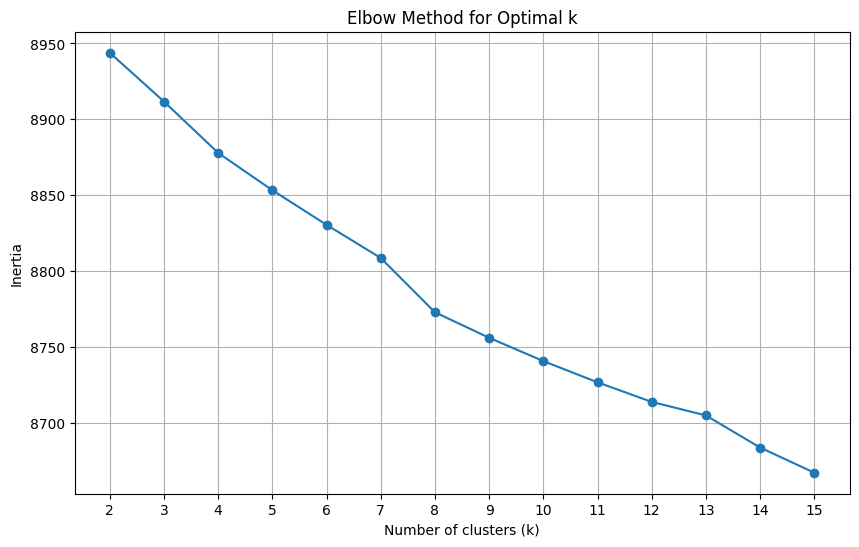

  Calculating Silhouette scores...
    k=2, Silhouette Score: 0.0042
    k=3, Silhouette Score: 0.0037
    k=4, Silhouette Score: 0.0047
    k=5, Silhouette Score: 0.0052
    k=6, Silhouette Score: 0.0057
    k=7, Silhouette Score: 0.0061
    k=8, Silhouette Score: 0.0074
    k=9, Silhouette Score: 0.0076
    k=10, Silhouette Score: 0.0077
    k=11, Silhouette Score: 0.0082
    k=12, Silhouette Score: 0.0085
    k=13, Silhouette Score: 0.0086
    k=14, Silhouette Score: 0.0092
    k=15, Silhouette Score: 0.0094
Saved plots_domain_analysis/silhouette_scores.png


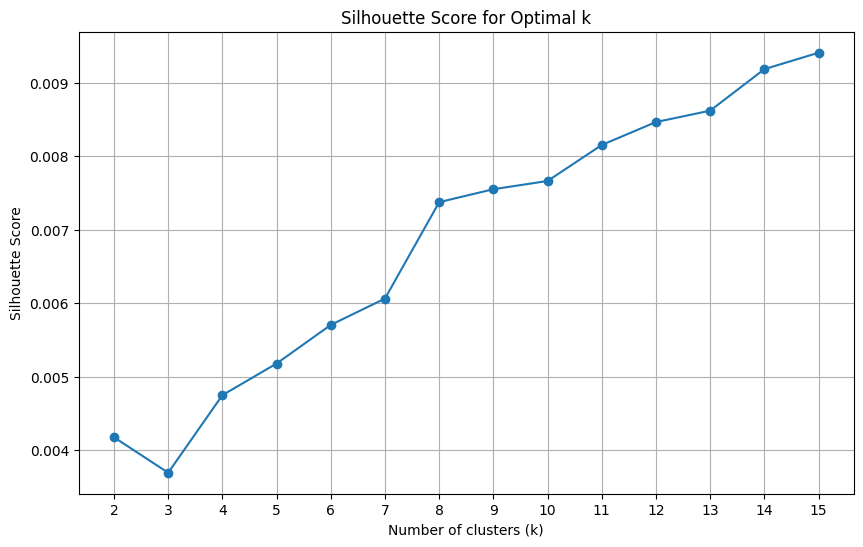

  Using k=6 for final clustering.
  Finding top keywords per cluster...

  Top Keywords per Cluster (Suggests Domain Names - PLEASE REVIEW AND RENAME):
    Cluster 0: phát triển(0.13), triển(0.13), phát(0.12), kinh(0.04), kinh tế(0.04), tế(0.03), hội(0.02), nam(0.02), xã(0.02), phát triển kinh(0.02) --> Tentative Name: Domain_0
    Cluster 1: học(0.17), sinh(0.08), học sinh(0.07), dạy(0.05), tập(0.04), dạy học(0.04), học tập(0.04), giáo(0.04), viên(0.03), thức(0.03) --> Tentative Name: Domain_1
    Cluster 2: sản(0.09), doanh(0.07), sản phẩm(0.06), nghiệp(0.06), phẩm(0.06), doanh nghiệp(0.06), xuất(0.05), thị(0.05), thị trường(0.04), hàng(0.04) --> Tentative Name: Domain_2
    Cluster 3: thể(0.02), định(0.02), động(0.02), dụng(0.01), thực(0.01), hiện(0.01), hợp(0.01), quan(0.01), hình(0.01), nhân(0.01) --> Tentative Name: Domain_3
    Cluster 4: công(0.15), ty(0.08), công ty(0.08), công tác(0.03), tác(0.03), hàng(0.02), công nghệ(0.02), nghệ(0.02), hiện(0.02), lý(0.02) --> Tentative Na

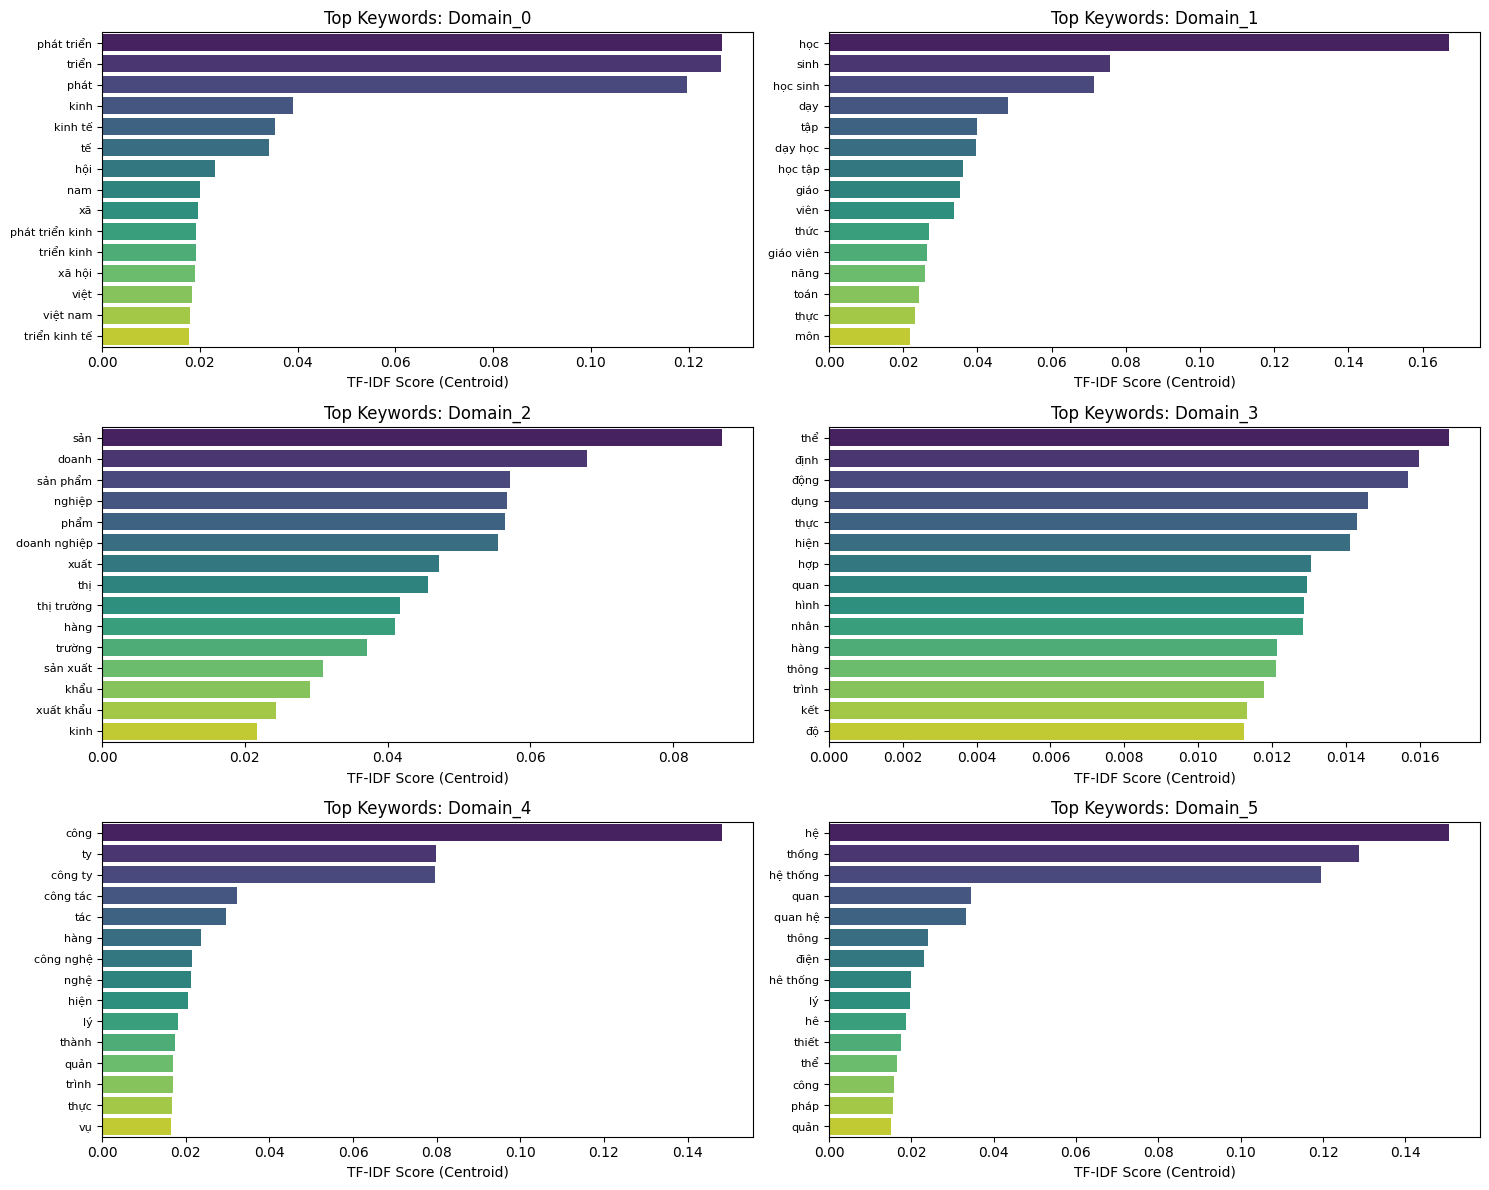

In [63]:
print("\n Clustering with KMeans...")
# Elbow Method
print("  Calculating Elbow Method scores...")
inertia = []
k_range = range(2, 16)
for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init='auto', verbose=0)
    kmeans_elbow.fit(tfidf_matrix)
    inertia.append(kmeans_elbow.inertia_)
plt.figure(figsize=(10, 6)); plt.plot(k_range, inertia, marker='o'); plt.xlabel('Number of clusters (k)'); plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k'); plt.xticks(k_range); plt.grid(True); plt.savefig(os.path.join(PLOT_DIR, "elbow_method.png"))
print(f"Saved {PLOT_DIR}/elbow_method.png")
plt.show()

# Silhouette Score
print("  Calculating Silhouette scores...")
silhouette_scores = []
valid_k_range_silhouette = [k for k in k_range if k >= 2]
for k in valid_k_range_silhouette:
    kmeans_sil = KMeans(n_clusters=k, random_state=42, n_init='auto', verbose=0)
    cluster_labels_temp = kmeans_sil.fit_predict(tfidf_matrix)
    if len(set(cluster_labels_temp)) > 1:
         try:
             # Sample data for silhouette score calculation if dataset is large
             sample_size = min(10000, tfidf_matrix.shape[0])
             score = silhouette_score(tfidf_matrix, cluster_labels_temp, sample_size=sample_size, random_state=42)
             silhouette_scores.append(score)
             print(f"    k={k}, Silhouette Score: {score:.4f}")
         except Exception as e_sil:
             print(f"    k={k}, Silhouette Score: Error ({e_sil})")
             silhouette_scores.append(-1)
    else:
         silhouette_scores.append(-1); print(f"    k={k}, Silhouette Score: N/A (1 cluster)")

plt.figure(figsize=(10, 6)); plt.plot(valid_k_range_silhouette, silhouette_scores, marker='o'); plt.xlabel('Number of clusters (k)'); plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k'); plt.xticks(valid_k_range_silhouette); plt.grid(True); plt.savefig(os.path.join(PLOT_DIR, "silhouette_scores.png"))
print(f"Saved {PLOT_DIR}/silhouette_scores.png")
plt.show()

# Final KMeans run
chosen_k = DEFAULT_K # !!! User should review plots and set this !!!
print(f"  Using k={chosen_k} for final clustering.")
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto', verbose=0)
cluster_labels = kmeans.fit_predict(tfidf_matrix)

# Store results in DataFrame
df_domains = pd.DataFrame({
    'doc_id': doc_indices, 'text_block': original_texts, 'processed_text': processed_texts,
    'syllable_map': syllable_maps, 'error_count': error_counts,
    'total_syllables': total_syllables_list, 'domain_label_id': cluster_labels
})
df_domains['error_rate'] = df_domains.apply(lambda row: row['error_count'] / row['total_syllables'] if row['total_syllables'] > 0 else 0, axis=1)

# Get top words and assign names (MANUAL ADJUSTMENT NEEDED FOR NAMES)
print("  Finding top keywords per cluster...")
cluster_centers = kmeans.cluster_centers_
top_words_per_cluster_list = find_top_tfidf_words(kmeans.cluster_centers_, feature_names, n_top=N_TOP_WORDS_PER_CLUSTER)
domain_names = {}
print("\n  Top Keywords per Cluster (Suggests Domain Names - PLEASE REVIEW AND RENAME):")
for i in range(chosen_k):
    keywords_str = ", ".join([f"{word}({score:.2f})" for word, score in top_words_per_cluster_list[i][:10]])
    heuristic_name = f"Domain_{i}" # !!! --- Assign meaningful name based on keywords --- !!!
    print(f"    Cluster {i}: {keywords_str} --> Tentative Name: {heuristic_name}")
    domain_names[i] = heuristic_name
df_domains['domain_name'] = df_domains['domain_label_id'].map(domain_names)

# Bar chart top keywords
fig_kw, axes_kw = plt.subplots(math.ceil(chosen_k / 2), 2, figsize=(15, 4 * math.ceil(chosen_k / 2)))
axes_kw = axes_kw.flatten()
for i in range(chosen_k):
    if i < len(axes_kw):
        words = [item[0] for item in top_words_per_cluster_list[i]]
        scores = [item[1] for item in top_words_per_cluster_list[i]]
        sns.barplot(x=scores, y=words, ax=axes_kw[i], palette='viridis')
        axes_kw[i].set_title(f"Top Keywords: {domain_names[i]}"); axes_kw[i].set_xlabel("TF-IDF Score (Centroid)")
        axes_kw[i].tick_params(axis='y', labelsize=8)
for j in range(i + 1, len(axes_kw)): fig_kw.delaxes(axes_kw[j]) # Remove unused subplots
plt.tight_layout(); plt.savefig(os.path.join(PLOT_DIR, "top_keywords_per_domain.png"))
print(f"Saved {PLOT_DIR}/top_keywords_per_domain.png")
plt.show()


 Visualizing clusters using t-SNE...
  Running t-SNE (may take time)...
Saved plots_domain_analysis/tsne_domain_clusters.png


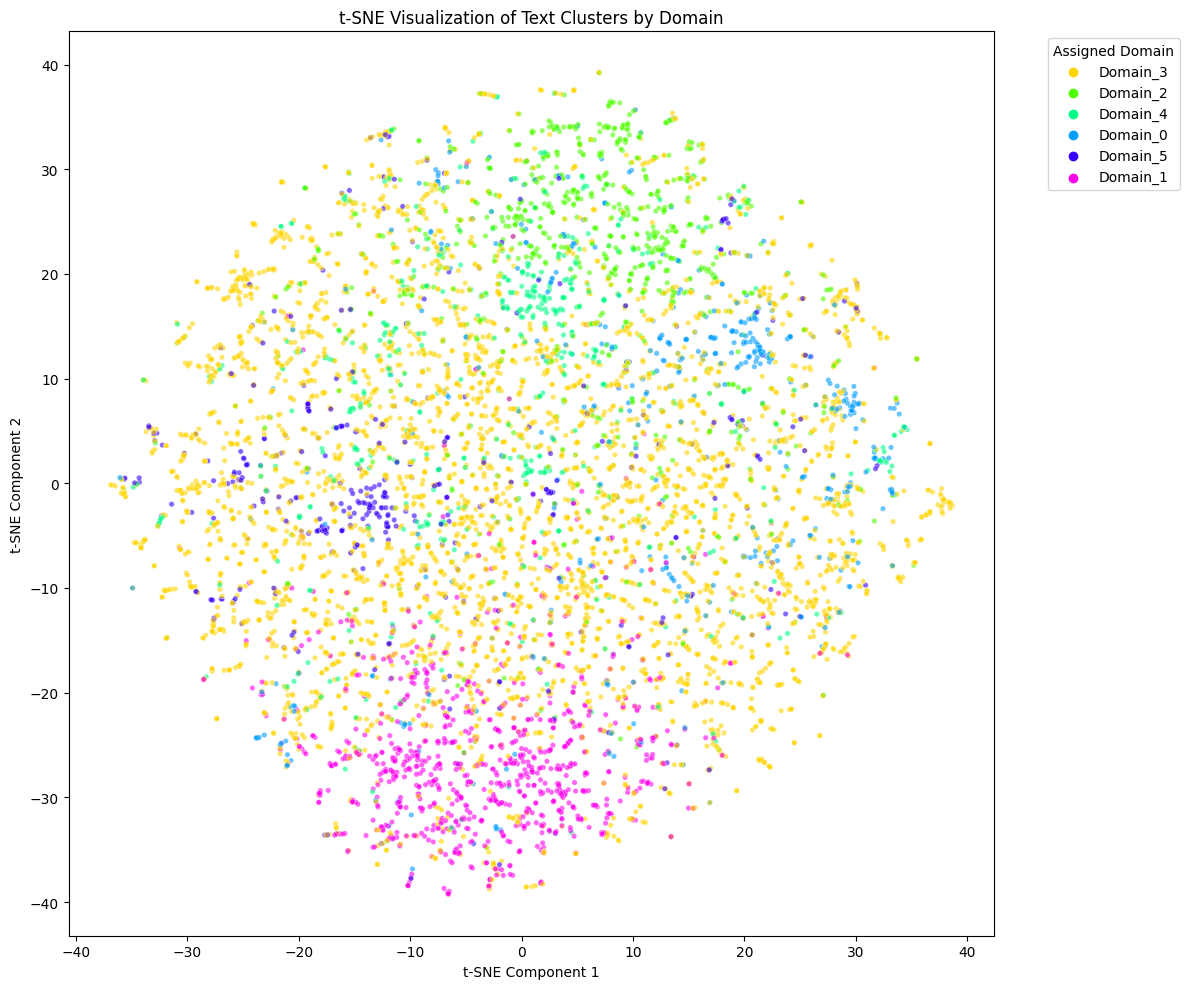

t-SNE finished (26.96s).
--- Domain Labeling Finished (71.48s) ---


In [64]:
print("\n Visualizing clusters using t-SNE...")
start_time_a4 = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, tfidf_matrix.shape[0]-1), n_iter=300, init='pca', learning_rate='auto')
try:
    # Use TruncatedSVD first for very large sparse matrices if memory is an issue
    # from sklearn.decomposition import TruncatedSVD
    # svd = TruncatedSVD(n_components=100, random_state=42)
    # reduced_tfidf_svd = svd.fit_transform(tfidf_matrix)
    # reduced_features = tsne.fit_transform(reduced_tfidf_svd)

    # Try direct t-SNE (might need dense, check memory)
    print("  Running t-SNE (may take time)...")
    reduced_features = tsne.fit_transform(tfidf_matrix.toarray()) # Convert to dense

    df_domains['tsne_1'] = reduced_features[:, 0]
    df_domains['tsne_2'] = reduced_features[:, 1]
    df_plot_data = df_domains # Plot all data

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x="tsne_1", y="tsne_2", hue="domain_name",
                    palette=sns.color_palette("hsv", chosen_k), data=df_plot_data,
                    legend="full", alpha=0.6, s=15) # Smaller points for large data
    plt.title('t-SNE Visualization of Text Clusters by Domain')
    plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
    plt.legend(title='Assigned Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(); plt.savefig(os.path.join(PLOT_DIR, "tsne_domain_clusters.png"))
    print(f"Saved {PLOT_DIR}/tsne_domain_clusters.png")
    plt.show()
    print(f"t-SNE finished ({time.time() - start_time_a4:.2f}s).")
except MemoryError: print("ERROR: MemoryError during t-SNE. Try dimensionality reduction (SVD) before t-SNE or sampling.")
except Exception as e: print(f"ERROR during t-SNE: {e}")

print(f"--- Domain Labeling Finished ({time.time() - start_time_a:.2f}s) ---")

In [65]:
print("\n--- Error Discrepancy Analysis ---")
start_time_b = time.time()

# B.1 Thống kê cơ bản
print(" Basic Statistics per Domain...")
domain_stats = df_domains.groupby('domain_name').agg(
    num_documents=('text_block', 'count'),
    avg_error_rate=('error_rate', 'mean'),
    median_error_rate=('error_rate', 'median'),
    total_errors=('error_count', 'sum'),
    total_syllables=('total_syllables', 'sum')
).reset_index()
# Calculate overall error rate accurately
domain_stats['overall_error_rate'] = domain_stats.apply(
    lambda row: row['total_errors'] / row['total_syllables'] if row['total_syllables'] > 0 else 0, axis=1
)
print("- Error Rate and Counts per Domain:")
print(domain_stats[['domain_name', 'num_documents', 'overall_error_rate', 'avg_error_rate', 'total_errors']].round(4).to_string())

# Top 5 lỗi phổ biến mỗi domain (incorrect syllables)
print("\n- Top 5 Incorrect Syllables per Domain:")
all_errors_by_domain = defaultdict(list)
for _, row in df_domains.iterrows():
    errors = get_error_syllables(row['syllable_map'])
    all_errors_by_domain[row['domain_name']].extend(errors)
top_errors_per_domain = {}
for domain, errors in all_errors_by_domain.items():
    if errors:
        error_counts_domain = Counter(errors)
        top_errors_per_domain[domain] = error_counts_domain.most_common(5)
        print(f"  Domain '{domain}': {top_errors_per_domain[domain]}")
    else: print(f"  Domain '{domain}': No errors.")


--- Error Discrepancy Analysis ---
 Basic Statistics per Domain...
- Error Rate and Counts per Domain:
  domain_name  num_documents  overall_error_rate  avg_error_rate  total_errors
0    Domain_0            569              0.0344          0.0401           686
1    Domain_1           1047              0.0364          0.0434          1236
2    Domain_2            916              0.0358          0.0416          1101
3    Domain_3           5459              0.0413          0.0508          6592
4    Domain_4            723              0.0379          0.0452           867
5    Domain_5            440              0.0392          0.0472           528

- Top 5 Incorrect Syllables per Domain:
  Domain 'Domain_3': [('thoả', 47), ('dung', 42), ('các', 40), ('thế', 38), ('Uỷ', 35)]
  Domain 'Domain_2': [('hang', 13), ('phầm', 12), ('thuỷ', 12), ('tang', 9), ('các', 8)]
  Domain 'Domain_4': [('nổ', 9), ('dung', 7), ('đông', 5), ('cũng', 5), ('động', 5)]
  Domain 'Domain_0': [('trong', 14), ('k

In [66]:
print("\n Statistical Tests...")
domain_error_rates_list = [df_domains[df_domains['domain_name'] == name]['error_rate'].dropna() for name in domain_names.values()]
valid_domain_error_rates = [rates for rates in domain_error_rates_list if len(rates) > 1]
if SCIPY_AVAILABLE and len(valid_domain_error_rates) >= 2:
    try: # ANOVA
        f_stat_b, p_value_b = f_oneway(*valid_domain_error_rates)
        print(f"  - ANOVA (Error Rates across Domains): F={f_stat_b:.4f}, p={p_value_b:.4g} -> {'Significant difference' if p_value_b < 0.05 else 'No significant difference'}")
    except Exception as e: print(f"    ANOVA failed: {e}")
    # T-tests (Example)
    try:
         if len(valid_domain_error_rates) >= 2:
              # Find corresponding domain names for the first two valid lists
              idx0 = domain_error_rates_list.index(valid_domain_error_rates[0])
              idx1 = domain_error_rates_list.index(valid_domain_error_rates[1])
              d1_name = list(domain_names.values())[idx0]
              d2_name = list(domain_names.values())[idx1]
              t_stat, p_t = ttest_ind(valid_domain_error_rates[0], valid_domain_error_rates[1], equal_var=False) # Welch's
              print(f"  - T-test ('{d1_name}' vs '{d2_name}'): t={t_stat:.4f}, p={p_t:.4g}")
    except Exception as e: print(f"    T-test failed: {e}")
else: print("  Skipping statistical tests (SciPy not available or not enough valid domain data).")


 Statistical Tests...
  - ANOVA (Error Rates across Domains): F=28.5140, p=8.614e-29 -> Significant difference
    T-test failed: Can only compare identically-labeled Series objects


In [67]:
print("\n Domain-Specific Error Detection...")
all_error_counts = Counter(err for errors in all_errors_by_domain.values() for err in errors)
domain_specific_errors = defaultdict(list)
# Calculate relative frequencies per domain
domain_error_freqs = {}
total_errors_per_domain = {domain: len(errors) for domain, errors in all_errors_by_domain.items()}
for domain, errors in all_errors_by_domain.items():
    if total_errors_per_domain[domain] > 0:
        domain_error_freqs[domain] = {err: count / total_errors_per_domain[domain] for err, count in Counter(errors).items()}
    else: domain_error_freqs[domain] = {}

# Find unique errors
unique_error_found = False
for domain, errors in all_errors_by_domain.items():
    domain_error_set = set(errors)
    other_errors_set = set().union(*(set(other_errors) for other_domain, other_errors in all_errors_by_domain.items() if other_domain != domain))
    specific_to_domain = list(domain_error_set - other_errors_set)
    if specific_to_domain:
         print(f"  - Errors potentially unique to '{domain}': {specific_to_domain[:10]}...")
         domain_specific_errors[domain].extend(specific_to_domain)
         unique_error_found = True
if not unique_error_found: print("  - No errors found unique to a single domain.")

# Find errors with large frequency differences
print("  - Errors with notable frequency differences:")
checked_errors = set()
diff_error_found = False
for err in sorted(all_error_counts.keys()): # Sort for consistent output
    if err in checked_errors: continue
    freqs = [domain_error_freqs.get(domain, {}).get(err, 0) for domain in domain_names.values()] # Safer get
    if len(freqs) > 1:
        min_freq, max_freq = min(freqs), max(freqs)
        if max_freq > 0.01 and ((max_freq - min_freq > 0.1) or (min_freq == 0 and max_freq > 0.05)):
             freq_str = ", ".join([f"{domain}({f:.1%})" for domain, f in zip(domain_names.values(), freqs)])
             print(f"    - Error '{err}': Freqs [{min_freq:.1%}-{max_freq:.1%}] across domains ({freq_str})")
             diff_error_found = True
    checked_errors.add(err)
if not diff_error_found: print("    - No errors with significant frequency differences found.")


 Domain-Specific Error Detection...
  - Errors potentially unique to 'Domain_3': ['naò', 'trân', 'Viêc', 'đoo', 'cácch', 'mất', 'nghàn', 'đaẩy', 'Luong', 'bệnhđang']...
  - Errors potentially unique to 'Domain_2': ['nhẳm', 'Hâụ', 'ách', 'khảu', 'cỉa', 'niềm', 'thuâtj', 'phârm,', 'híc', 'triền,']...
  - Errors potentially unique to 'Domain_4': ['Hưỡng', 'rẻ', 'thoã', 'khỉ', 'quóc', 'việcv', 'scahs', 'thuơng', 'cháp', 'rò']...
  - Errors potentially unique to 'Domain_0': ['Đinh', 'luât', 'chiển', 'nghiệ', 'thiếta', 'do.', 'tở', 'dô', 'hangg', 'nhừng']...
  - Errors potentially unique to 'Domain_5': ['đặ', 'việ.', 'lấp', 'Khai', 'đượt', 'dễ', 'ngạ', 'cế', 'ren', 'nầy']...
  - Errors potentially unique to 'Domain_1': ['trận', 'Nế', 'bàiatoán', 'huyatính', 'huốn', 'ôi', 'trinh.', 'để,', 'tháo', 'hợpliên']...
  - Errors with notable frequency differences:
    - No errors with significant frequency differences found.



 Generating Error Rate Heatmap...
Saved plots_domain_analysis/heatmap_error_rate_per_domain.png


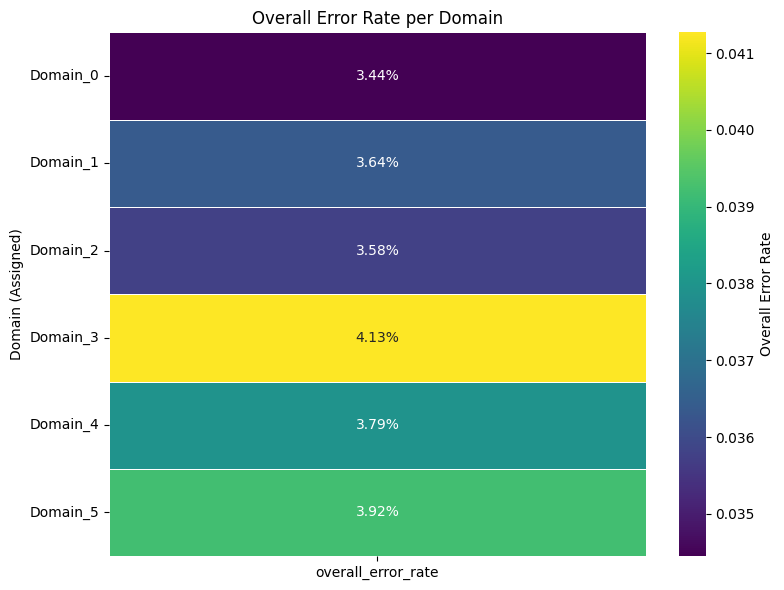

Skipping Radar Chart (requires error type classification data).
--- Error Discrepancy Analysis Finished (1.13s) ---


In [68]:
print("\n Generating Error Rate Heatmap...")
plt.figure(figsize=(max(8, chosen_k*1.1), max(6, chosen_k * 0.9)))
try:
    # Plot overall error rate per domain
    heatmap_plot_data = domain_stats.set_index('domain_name')[['overall_error_rate']]
    sns.heatmap(heatmap_plot_data, annot=True, fmt=".2%", cmap="viridis", linewidths=.5, cbar_kws={'label': 'Overall Error Rate'})
    plt.title('Overall Error Rate per Domain'); plt.xlabel(''); plt.ylabel('Domain (Assigned)')
    plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "heatmap_error_rate_per_domain.png"))
    print(f"Saved {PLOT_DIR}/heatmap_error_rate_per_domain.png")
    plt.show()
except Exception as e: print(f"  Failed to generate heatmap: {e}")

print("Skipping Radar Chart (requires error type classification data).")
print(f"--- Error Discrepancy Analysis Finished ({time.time() - start_time_b:.2f}s) ---")

In [69]:
print("\n--- Domain Difference Measurement (JS Divergence) ---")
start_time_c = time.time()
print("Calculating error distributions & pairwise JS Divergence...")
domain_names_list = list(domain_names.values())
js_distances = pd.DataFrame(index=domain_names_list, columns=domain_names_list, dtype=float)
domain_error_counts = {domain: Counter(errors) for domain, errors in all_errors_by_domain.items()}

for i in range(chosen_k):
    for j in range(i, chosen_k):
        d1_name = domain_names_list[i]; d2_name = domain_names_list[j]
        if i == j: js_distances.loc[d1_name, d2_name] = 0.0
        else:
             js_dist = calculate_js_divergence(domain_error_counts[d1_name], domain_error_counts[d2_name])
             js_distances.loc[d1_name, d2_name] = js_dist
             js_distances.loc[d2_name, d1_name] = js_dist

print("- Pairwise JS Distances (sqrt(JSD)):")
print(js_distances.round(4).to_string())


--- Domain Difference Measurement (JS Divergence) ---
Calculating error distributions & pairwise JS Divergence...
- Pairwise JS Distances (sqrt(JSD)):
          Domain_0  Domain_1  Domain_2  Domain_3  Domain_4  Domain_5
Domain_0    0.0000    0.8366    0.8192    0.7840    0.8438    0.8487
Domain_1    0.8366    0.0000    0.8227    0.7391    0.8219    0.8398
Domain_2    0.8192    0.8227    0.0000    0.7330    0.8047    0.8519
Domain_3    0.7840    0.7391    0.7330    0.0000    0.7552    0.7947
Domain_4    0.8438    0.8219    0.8047    0.7552    0.0000    0.8510
Domain_5    0.8487    0.8398    0.8519    0.7947    0.8510    0.0000



Generating Domain Similarity Graph (based on JS Distance)...
Saved plots_domain_analysis/domain_similarity_graph.png


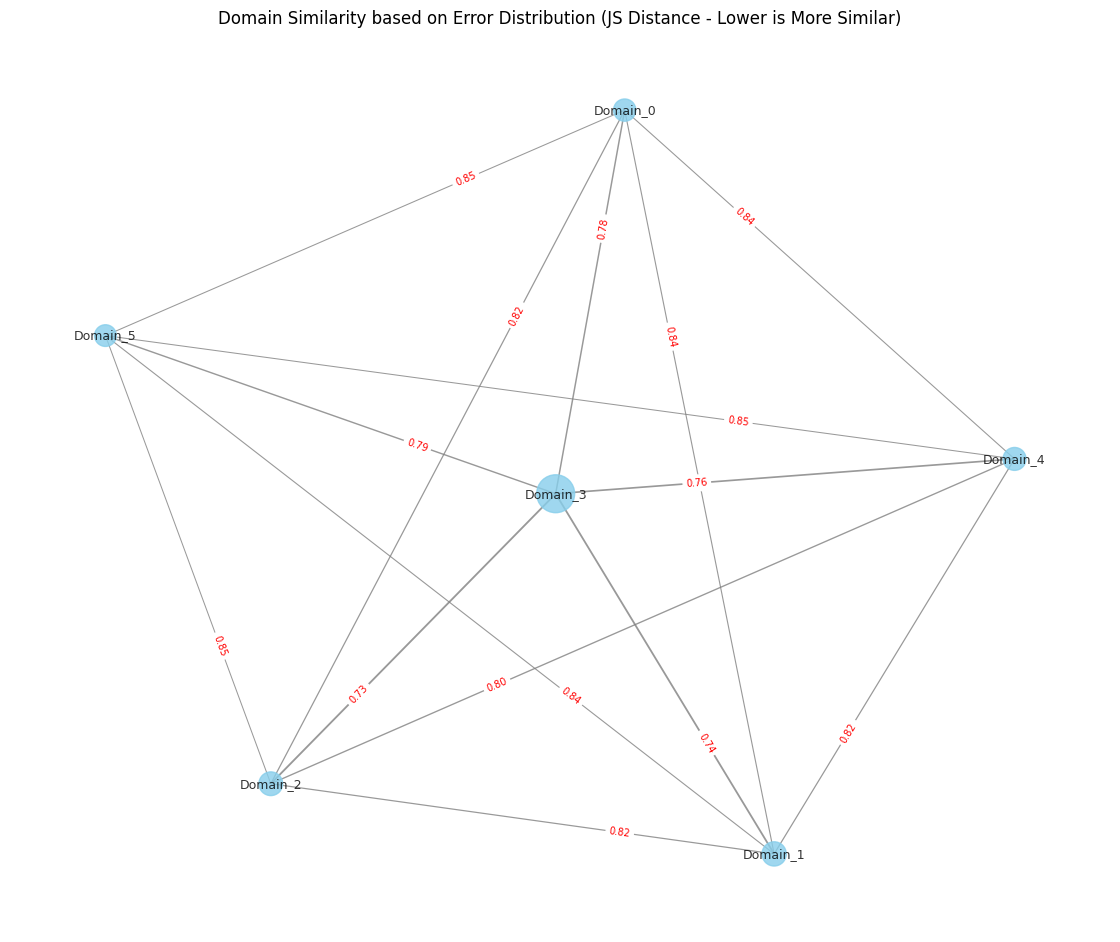

In [70]:
if nx is not None:
    print("\nGenerating Domain Similarity Graph (based on JS Distance)...")
    plt.figure(figsize=(11, 9)); G = nx.Graph()
    max_dist = js_distances.max().max() # Find max distance for edge weight scaling if needed
    for i in range(chosen_k): G.add_node(domain_names_list[i])
    for i in range(chosen_k):
        for j in range(i + 1, chosen_k):
            dist = js_distances.iloc[i, j]
            if pd.notna(dist) and dist > 1e-6:
                # Weight inversely proportional to distance (closer = thicker edge)
                weight = max(0.1, 1 - dist) * 5 # Simpler scaling for weight
                G.add_edge(domain_names_list[i], domain_names_list[j], weight=weight, distance=dist)
    pos = nx.spring_layout(G, k=0.7, iterations=50, weight='weight', seed=42) # Adjust layout params
    edges = G.edges(); weights = [G[u][v]['weight'] for u,v in edges]
    node_sizes_c = [(domain_stats.loc[domain_stats['domain_name']==node, 'num_documents'].iloc[0] / 10) + 200 for node in G.nodes()] # Adjust size scaling

    nx.draw(G, pos, with_labels=True, node_size=node_sizes_c, node_color='skyblue', font_size=9, width=weights, edge_color='gray', alpha=0.8)
    # Add distance labels on edges (optional)
    edge_labels = {(u,v): f"{G[u][v]['distance']:.2f}" for u,v in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color='red', label_pos=0.3)
    plt.title('Domain Similarity based on Error Distribution (JS Distance - Lower is More Similar)'); plt.savefig(os.path.join(PLOT_DIR, "domain_similarity_graph.png"))
    print(f"Saved {PLOT_DIR}/domain_similarity_graph.png")
    plt.show()
else: print("Skipping Domain Similarity Graph (networkx not installed).")


Generating Domain Cluster Map (based on JS Distance)...
Saved plots_domain_analysis/domain_clustermap_jsd.png


<Figure size 800x700 with 0 Axes>

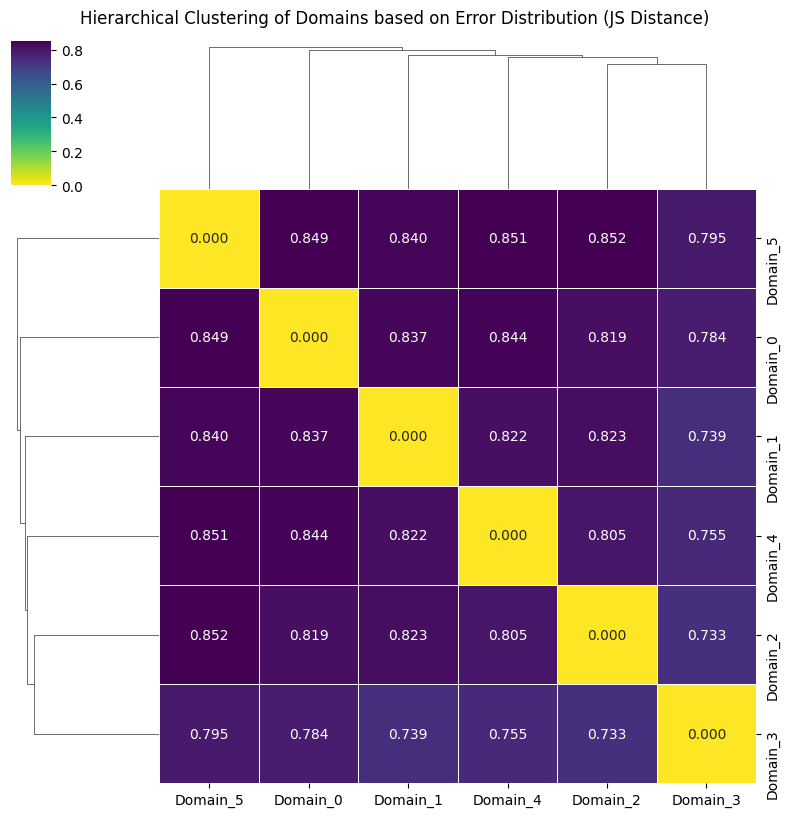

--- Domain Difference Measurement Finished (1.24s) ---


In [71]:
# Visualize using Cluster Map
if not js_distances.isnull().all().all():
    print("\nGenerating Domain Cluster Map (based on JS Distance)...")
    try:
        plt.figure(figsize=(max(8, chosen_k * 1.1), max(7, chosen_k * 0.9))) # Dynamic figsize
        sns.clustermap(js_distances.fillna(1.0), # Fill NaN with max distance (1.0 for sqrt(JSD))
                       cmap="viridis_r", annot=True, fmt=".3f", linewidths=.5, figsize=(max(8, chosen_k), max(8, chosen_k)))
        plt.suptitle('Hierarchical Clustering of Domains based on Error Distribution (JS Distance)', y=1.02)
        plt.savefig(os.path.join(PLOT_DIR, "domain_clustermap_jsd.png"))
        print(f"Saved {PLOT_DIR}/domain_clustermap_jsd.png")
        plt.show()
    except Exception as e: print(f"  Clustermap failed: {e}")
else: print("Skipping Cluster Map: Not enough valid JS distance data.")
print(f"--- Domain Difference Measurement Finished ({time.time() - start_time_c:.2f}s) ---")

In [72]:
print("\n--- Domain Adaptation Assessment ---")
start_time_d = time.time()
needs_adaptation = False; reasons = []

# 1. Check JS Divergence
js_dist_threshold = 0.4 # ADJUSTABLE: Threshold for significant difference (sqrt(JSD))
if not js_distances.isnull().all().all():
    high_js_pairs_df = js_distances[js_distances > js_dist_threshold].unstack().dropna()
    high_js_pairs_df = high_js_pairs_df[high_js_pairs_df.index.get_level_values(0) < high_js_pairs_df.index.get_level_values(1)] # Unique pairs
    if not high_js_pairs_df.empty:
        needs_adaptation = True; reason = f"High JS Distance (> {js_dist_threshold}) found between domain pairs."
        print(f"- {reason}"); reasons.append(reason)
        # print(f"  Pairs: {list(high_js_pairs_df.index)}")
    else: print("- JS Distances between domains are below threshold.")
else: print("- JS Distance check skipped.")

# 2. Check Domain-Specific Errors (Frequency > Threshold)
high_freq_specific_errors = False
for domain, specific_errors_list in domain_specific_errors.items():
    if specific_errors_list:
        domain_total_errs = total_errors_per_domain.get(domain, 0)
        if domain_total_errs > 0:
            error_counts_dom = Counter(all_errors_by_domain[domain])
            for err in specific_errors_list:
                freq = error_counts_dom[err] / domain_total_errs
                if freq > ERROR_FREQ_THRESHOLD:
                    reason = f"Domain '{domain}' has unique error '{err}' with high frequency ({freq:.1%})"
                    print(f"- {reason}"); reasons.append(reason); high_freq_specific_errors = True; needs_adaptation = True
            # if high_freq_specific_errors: break # Stop after finding one example per domain? Or list all? Let's list all.
if not high_freq_specific_errors and any(domain_specific_errors.values()): print("- Found unique errors, but none exceeded frequency threshold.")
elif not any(domain_specific_errors.values()): print("- No strictly unique errors identified.")

# 3. Check Error Rate Difference
if not domain_stats.empty and domain_stats['overall_error_rate'].count() > 1:
    min_rate = domain_stats['overall_error_rate'].min(); max_rate = domain_stats['overall_error_rate'].max()
    if max_rate > 1e-6 and (max_rate - min_rate) / max_rate > ERROR_RATE_DIFF_THRESHOLD:
        needs_adaptation = True; reason = f"Significant relative error rate difference across domains (Min: {min_rate:.2%}, Max: {max_rate:.2%})"
        print(f"- {reason}"); reasons.append(reason)
    else: print("- Error rate difference across domains is below threshold.")
else: print("- Error rate difference check skipped.")

# Conclusion
print("\n- Overall Assessment:")
if needs_adaptation:
    print("  --> Domain adaptation is LIKELY BENEFICIAL based on:"); [print(f"    * {r}") for r in reasons]
    print("\n- Recommended Actions:\n    * Consider Multi-domain modeling (e.g., domain embeddings).\n    * Fine-tuning models separately for divergent domains.\n    * Augment training data for specific domains.\n    * Develop domain-specific dictionaries/rules.")
else:
    print("  --> Domain adaptation might NOT be strictly necessary based on these criteria. A general model could suffice, but minor adaptations might still help.")
print("- Visualization: Flowchart/Comparison chart skipped.")
print(f"--- Domain Adaptation Assessment Finished ({time.time() - start_time_d:.2f}s) ---")


--- Domain Adaptation Assessment ---
- High JS Distance (> 0.4) found between domain pairs.
- Found unique errors, but none exceeded frequency threshold.
- Error rate difference across domains is below threshold.

- Overall Assessment:
  --> Domain adaptation is LIKELY BENEFICIAL based on:
    * High JS Distance (> 0.4) found between domain pairs.

- Recommended Actions:
    * Consider Multi-domain modeling (e.g., domain embeddings).
    * Fine-tuning models separately for divergent domains.
    * Augment training data for specific domains.
    * Develop domain-specific dictionaries/rules.
- Visualization: Flowchart/Comparison chart skipped.
--- Domain Adaptation Assessment Finished (0.01s) ---


In [73]:
total_time_script = time.time() - start_time
print(f"\n Total Time: {total_time_script:.2f} seconds ---")


 Total Time: 1645.93 seconds ---


# Phân tích từ/câu phổ biến

In [74]:
!pip install rapidfuzz

In [75]:
import itertools
from rapidfuzz import fuzz, process
from sklearn.metrics.pairwise import pairwise_distances
import plotly.io as pio

In [76]:
PLOT_DIR = "plots_error_patterns"
LEVENSHTEIN_SIMILARITY_THRESHOLD = 80 # Ngưỡng gom nhóm (e.g., 80%)
NGRAM_SIZE = 5 # Kích thước cửa sổ trượt (syllable level)
TOP_N_ERRORS = 10
TOP_N_PATTERNS = 15 # Show more patterns
NEGATIVE_SAMPLE_COUNT = 7
MIN_CLUSTER_SIZE_FOR_STATS = 2 # Min variants needed in cluster for length comparison

VIETNAMESE_FONT_PATH = None # Optional: Path to a .ttf font for Word Cloud

# Ensure plot directory exists
os.makedirs(PLOT_DIR, exist_ok=True)

In [77]:
def reconstruct_text_and_errors(annotations):
    """Reconstructs text and identifies error positions and syllables."""
    if not annotations: return "", [], []
    text = ""; current_char_index = 0
    error_info = [] # List of {'index': syl_idx, 'syllable': incorrect_syl, 'start': char_idx, 'end': char_idx}
    all_syllables = [] # List of {'text': syllable, 'is_correct': bool}
    for i, ann in enumerate(annotations):
        syllable = ann.get('current_syllable', ''); is_correct = ann.get('is_correct', True)
        syllable_strip = syllable.strip()
        start_char = current_char_index; end_char = start_char + len(syllable)
        all_syllables.append({'text': syllable_strip, 'is_correct': is_correct})
        if not is_correct and syllable_strip:
            error_info.append({'index': i, 'syllable': syllable_strip, 'start_char': start_char, 'end_char': end_char})
        # Append to text with intelligent spacing
        if i > 0 and text and not text.endswith(' ') and syllable and not re.match(r'^[\s,.!?]+', syllable):
            text += " "; current_char_index += 1
        text += syllable; current_char_index += len(syllable)
    text_clean = re.sub(r'\s+', ' ', text).strip()
    text_clean = re.sub(r'\s+([,.!?])', r'\1', text_clean); text_clean = re.sub(r'([({[])\s+', r'\1', text_clean); text_clean = re.sub(r'\s+([)}\]])', r'\1', text_clean)
    return text_clean, error_info, all_syllables

def group_similar_errors_optimized(error_counter, threshold=80, min_freq_for_root=2):
    """Groups similar error syllables using fuzzy matching, optimized approach."""
    print(f"Grouping {len(error_counter)} unique errors with threshold {threshold}...")
    start_time_group = time.time()
    if not error_counter: return {}

    clusters = {} # root_word -> list of members (including root)
    processed_errors = set() # Track errors already assigned to a cluster
    cluster_id_map = {} # error_word -> cluster_id (root_word)

    # Consider only relatively frequent errors as potential cluster roots initially
    potential_roots = [err for err, count in error_counter.items() if count >= min_freq_for_root]
    # Sort potential roots by frequency (descending) - process common errors first
    potential_roots.sort(key=lambda x: error_counter[x], reverse=True)

    # List of all unique errors for matching candidates
    all_errors_list = list(error_counter.keys())
    print(f"Processing {len(potential_roots)} potential cluster roots (freq >= {min_freq_for_root})...")

    processed_count = 0
    for root_candidate in potential_roots:
        if root_candidate in processed_errors:
            continue

        processed_count += 1
        # Find words similar to this root candidate from the entire error list
        # limit=None -> find all matches above threshold (can be slow!)
        # Limit the search space if too slow? Maybe match against unprocessed errors only?
        # Let's try matching against all for completeness first
        matches = process.extract(root_candidate, all_errors_list, scorer=fuzz.ratio, score_cutoff=threshold, limit=None) # Find all above threshold

        current_cluster_members = set()
        # The root candidate forms a new cluster
        clusters[root_candidate] = [] # Initialize members list
        processed_errors.add(root_candidate)
        cluster_id_map[root_candidate] = root_candidate
        current_cluster_members.add(root_candidate)


        # Add similar words to this cluster if they haven't been processed yet
        for match_word, score, _ in matches:
            if match_word not in processed_errors:
                 clusters[root_candidate].append(match_word)
                 processed_errors.add(match_word)
                 cluster_id_map[match_word] = root_candidate # Map variant to this root
                 current_cluster_members.add(match_word) # Add to the set for this iteration


        # Add the root itself to the members list
        clusters[root_candidate].insert(0, root_candidate)

        if processed_count % 100 == 0:
             print(f"  Processed {processed_count}/{len(potential_roots)} roots. Found {len(clusters)} clusters so far...")

    # Handle errors that were not frequent enough to be roots and weren't matched
    remaining_errors = set(all_errors_list) - processed_errors
    print(f"Processing {len(remaining_errors)} remaining singleton errors...")
    for error in remaining_errors:
        clusters[error] = [error] # Create singleton clusters
        cluster_id_map[error] = error

    print(f"Finished grouping. Total clusters: {len(clusters)}. Time: {time.time() - start_time_group:.2f}s")
    # Filter out potential empty clusters (shouldn't happen with this logic)
    clusters = {k: v for k, v in clusters.items() if v}
    return clusters, cluster_id_map

def calculate_levenshtein_distribution(clusters, error_counter):
    """Calculates distribution of Levenshtein similarity ratios within clusters."""
    ratio_counts = Counter()
    total_pairs_weighted = 0
    print("Calculating Levenshtein ratios within clusters...")
    i = 0
    for root, members in clusters.items():
        root_lower = root.lower() # Ensure lowercase for comparison
        if len(members) > 1:
            for member in members:
                if member != root:
                    member_lower = member.lower()
                    ratio = fuzz.ratio(root_lower, member_lower)
                    # Use integer bins for ratios (e.g., 70-79, 80-89, 90-99, 100)
                    bin_label = f"{math.floor(ratio/10)*10}-{(math.floor(ratio/10)*10)+9}%" if ratio < 100 else "100%"
                    member_freq = error_counter.get(member, 0)
                    ratio_counts[bin_label] += member_freq
                    total_pairs_weighted += member_freq
        i += 1
        if (i + 1) % 500 == 0: print(f"  Calculated ratios for {i+1}/{len(clusters)} clusters...")

    distribution = {dist: count / total_pairs_weighted * 100 for dist, count in ratio_counts.items()} if total_pairs_weighted > 0 else {}
    print("Finished ratio calculation.")
    return ratio_counts, distribution

def get_syllable_ngrams(all_syllables_info, error_index, n=5):
    """Extracts syllable n-grams centered around an error index, using placeholders."""
    padding = "[PAD]"
    syllables_text = [s['text'] if s['is_correct'] else '[ERR]' for s in all_syllables_info]
    num_syllables = len(syllables_text)
    half_n = n // 2

    start_idx = max(0, error_index - half_n)
    end_idx = min(num_syllables, error_index + half_n + 1)

    ngram = syllables_text[start_idx:end_idx]

    # Calculate needed padding
    left_pad_needed = half_n - (error_index - start_idx)
    right_pad_needed = half_n - ((end_idx - 1) - error_index) # Correct right padding calculation

    padded_ngram = ([padding] * left_pad_needed) + ngram + ([padding] * right_pad_needed)

    # Ensure the final ngram is exactly size n by trimming/padding if necessary
    # This standardization helps in counting identical patterns
    final_ngram = padded_ngram
    if len(final_ngram) > n:
        # This can happen if the error is near the center and the sequence is long
        # Trim symmetrically
        trim_needed = len(final_ngram) - n
        trim_left = trim_needed // 2
        trim_right = trim_needed - trim_left
        final_ngram = final_ngram[trim_left : len(final_ngram) - trim_right]
    elif len(final_ngram) < n:
        # This shouldn't happen with the padding logic above, but as a safeguard
        final_ngram = final_ngram + [padding] * (n - len(final_ngram))


    # The error position within the *final* ngram of size n
    err_pos_in_final = left_pad_needed + (error_index - start_idx)
    # Adjust if trimming occurred from left
    if len(padded_ngram) > n:
         trim_left = (len(padded_ngram) - n) // 2
         err_pos_in_final -= trim_left

    # Ensure position is valid within the final ngram
    err_pos_in_final = max(0, min(n-1, err_pos_in_final))
    # Double check if [ERR] is actually at this position
    if final_ngram[err_pos_in_final] != '[ERR]':
        # Fallback: find first occurrence of [ERR] if calculation was off
        try: err_pos_in_final = final_ngram.index('[ERR]')
        except ValueError: err_pos_in_final = -1 # Should not happen if error_index was valid


    return tuple(final_ngram), err_pos_in_final # Return tuple and error position

In [78]:
print("\n--- Extracting All Incorrect Syllables ---")
all_incorrect_syllables = []
all_error_details = [] # Store {'error_syllable': syl, 'context': all_syllables_list, 'error_index': idx}
processed_entry_count = 0
start_time_pre = time.time()
for i, entry in enumerate(data):
    annotations = entry.get('annotations', [])
    if not annotations: continue
    processed_entry_count += 1
    _, error_info, all_syllables_info = reconstruct_text_and_errors(annotations)
    for error in error_info:
        incorrect_syllable = error['syllable'].lower() # Lowercase for grouping
        all_incorrect_syllables.append(incorrect_syllable)
        # Store necessary info for n-gram analysis
        all_error_details.append({
            'error_syllable': incorrect_syllable,
            'all_syllables_info': all_syllables_info,
            'error_index': error['index']
        })
print(f"Preprocessing finished ({time.time() - start_time_pre:.2f}s).")
print(f"Found {len(all_incorrect_syllables)} total error instances from {processed_entry_count} entries.")
if not all_incorrect_syllables: print("No errors found."); exit()

error_freq = Counter(all_incorrect_syllables)
print(f"Found {len(error_freq)} unique incorrect syllables.")


--- Extracting All Incorrect Syllables ---
Preprocessing finished (2.18s).
Found 11202 total error instances from 9341 entries.
Found 3756 unique incorrect syllables.


In [79]:
# --- A. TOP TỪ SAI & BIẾN THỂ ---
print("\n--- Top Error Syllables & Variants ---")
start_time_a = time.time()

# A.1 Nhóm từ sai thành cụm
# Use the optimized grouping function
error_clusters, error_to_cluster_root = group_similar_errors_optimized(error_freq, threshold=LEVENSHTEIN_SIMILARITY_THRESHOLD)

# A.2 Phân tích từ gốc & A.3 Thống kê
print("\nA.2 & A.3 Analyzing and Calculating Cluster Statistics...")
cluster_stats = []
all_levenshtein_ratios = []
for root, members in error_clusters.items():
    # Root is already the most frequent by design of grouping function
    total_freq = sum(error_freq.get(m, 0) for m in members)
    if total_freq == 0: continue # Skip empty clusters if any

    cluster_stats.append({
        'root': root,
        'members': sorted(list(set(members)), key=lambda x: error_freq.get(x,0), reverse=True), # Sort members by freq
        'total_freq': total_freq,
        'num_variants': len(members)
    })
    # Calculate ratios within cluster for distribution plot
    root_lower = root.lower()
    for member in members:
        if member != root:
            ratio = fuzz.ratio(root_lower, member.lower())
            all_levenshtein_ratios.extend([ratio] * error_freq.get(member, 0))

df_clusters = pd.DataFrame(cluster_stats).sort_values(by='total_freq', ascending=False).reset_index(drop=True)
total_errors = len(all_incorrect_syllables) # Recalculate just in case
df_clusters['percentage'] = (df_clusters['total_freq'] / total_errors) * 100

print(f"\n- Top {TOP_N_ERRORS} Error Clusters by Frequency:")
# Display members more cleanly
def format_members(members_list, root, max_show=5):
     others = [m for m in members_list if m != root]
     if not others: return f"['{root}']"
     suffix = "..." if len(others) > max_show else ""
     return f"['{root}', {', '.join(repr(m) for m in others[:max_show])}{suffix}]"

df_clusters['members_display'] = df_clusters.apply(lambda row: format_members(row['members'], row['root']), axis=1)
print(df_clusters[['root', 'total_freq', 'percentage', 'num_variants', 'members_display']].head(TOP_N_ERRORS).to_string(float_format='{:.2f}%'.format, index=False))

# Độ dài trung bình của từ sai
avg_error_len = np.mean([len(syl) for syl in all_incorrect_syllables])
print(f"\n- Average Length of ALL Incorrect Syllables: {avg_error_len:.2f} characters")

# Phân bố khoảng cách Levenshtein (Ratios)
print("\n- Distribution of Levenshtein Similarity Ratios within Clusters (Root vs Members):")
if all_levenshtein_ratios:
    ratio_bins = [0, 70, LEVENSHTEIN_SIMILARITY_THRESHOLD, 90, 100] # Adjusted bins based on threshold
    ratio_labels = ['<70%', f'70-{LEVENSHTEIN_SIMILARITY_THRESHOLD-1}%', f'{LEVENSHTEIN_SIMILARITY_THRESHOLD}-89%', '90-99%']
    # Use pd.Series for easy value_counts
    ratio_series = pd.Series(all_levenshtein_ratios)
    ratio_distribution = pd.cut(ratio_series, bins=ratio_bins, labels=ratio_labels, right=False).value_counts(normalize=True, sort=False) * 100
    print(ratio_distribution.to_string(float_format='{:.1f}%'.format))
else: print("  Could not calculate Levenshtein ratio distribution.")


--- Top Error Syllables & Variants ---
Grouping 3756 unique errors with threshold 80...
Processing 1545 potential cluster roots (freq >= 2)...
  Processed 100/1545 roots. Found 100 clusters so far...
  Processed 200/1545 roots. Found 200 clusters so far...
  Processed 300/1545 roots. Found 300 clusters so far...
  Processed 400/1545 roots. Found 400 clusters so far...
  Processed 500/1545 roots. Found 500 clusters so far...
  Processed 600/1545 roots. Found 600 clusters so far...
  Processed 700/1545 roots. Found 700 clusters so far...
  Processed 800/1545 roots. Found 800 clusters so far...
  Processed 900/1545 roots. Found 900 clusters so far...
Processing 1268 remaining singleton errors...
Finished grouping. Total clusters: 2219. Time: 0.39s

A.2 & A.3 Analyzing and Calculating Cluster Statistics...

- Top 10 Error Clusters by Frequency:
 root  total_freq  percentage  num_variants                                            members_display
nhưng         153       1.37%            19

In [80]:
# Sunburst Chart
if not df_clusters.empty:
    print("Generating Sunburst chart for Error Clusters...")
    # Prepare data: Need root, member, freq_member
    sunburst_data = []
    for _, row in df_clusters.head(15).iterrows(): # Limit to top N clusters for readability
        root = row['root']
        total_cluster_freq = row['total_freq']
        # Add root node
        sunburst_data.append({'id': root, 'parent': 'Errors', 'value': total_cluster_freq})
        # Add member nodes
        for member in row['members']:
             member_freq = error_freq.get(member, 0)
             # ID needs to be unique, append root info?
             member_id = f"{member} (from {root})"
             sunburst_data.append({'id': member_id, 'parent': root, 'value': member_freq})

    df_sunburst = pd.DataFrame(sunburst_data)
    # Add frequency as text info
    df_sunburst['freq_text'] = df_sunburst['value'].apply(lambda x: f"{x:,}")

    if not df_sunburst.empty:
        try:
            fig_sunburst = go.Figure(go.Sunburst(
                ids=df_sunburst['id'],
                labels=df_sunburst['id'].apply(lambda x: x.split(' (from ')[0]), # Show only word
                parents=df_sunburst['parent'],
                values=df_sunburst['value'],
                branchvalues="total", # Value of parent = sum of children
                hovertemplate='<b>%{label}</b><br>Frequency: %{value}<br>Parent: %{parent}<extra></extra>',
                maxdepth=2 # Show 2 levels: Root Error -> Variants
            ))
            fig_sunburst.update_layout(margin = dict(t=40, l=0, r=0, b=0), title='Top Error Clusters and Variants')
            fig_sunburst.write_image(os.path.join(PLOT_DIR, "sunburst_error_clusters.png"), scale=2)
            print(f"Saved {PLOT_DIR}/sunburst_error_clusters.png")
            fig_sunburst.show()
        except Exception as e: print(f"  Failed to generate Sunburst: {e}")
    else: print("  No data formatted for Sunburst chart.")
else: print("Skipping Sunburst chart (Plotly not available or no clusters found).")

Generating Sunburst chart for Error Clusters...
Saved plots_error_patterns/sunburst_error_clusters.png


Generating Bar Chart for Error Length Comparison...
Saved plots_error_patterns/barchart_error_length_comparison.png


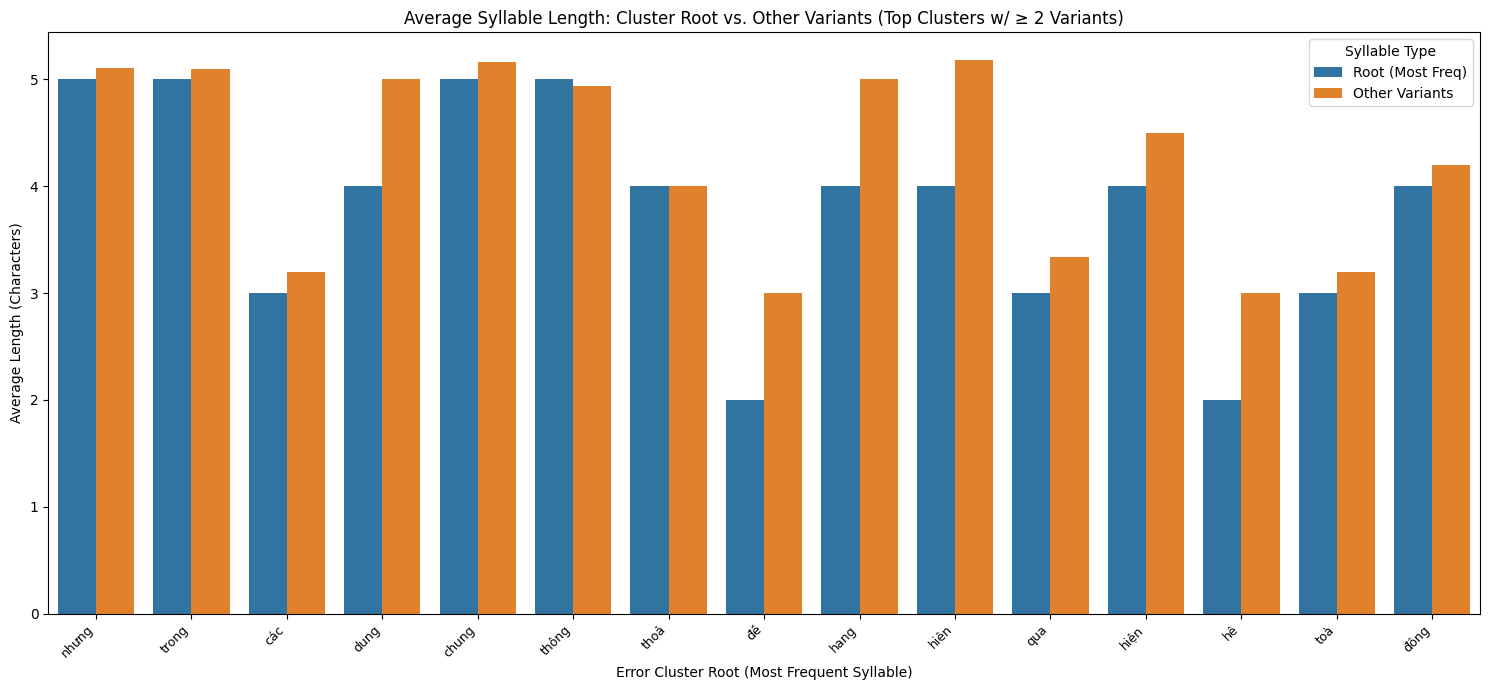

In [81]:
print("Generating Bar Chart for Error Length Comparison...")
try:
    len_comparison = []
    # Lọc các cụm có ít nhất MIN_CLUSTER_SIZE_FOR_STATS biến thể, và lấy top 15
    df_compare_len = df_clusters[df_clusters['num_variants'] >= MIN_CLUSTER_SIZE_FOR_STATS].head(15)

    for _, row in df_compare_len.iterrows():
        root = row['root']
        # Tính độ dài trung bình các biến thể (loại trừ root)
        avg_variant_len = np.mean([len(m) for m in row['members'] if m != root])
        len_comparison.append({'Cluster Root': root, 'Type': 'Root (Most Freq)', 'Avg Length': len(root)})
        len_comparison.append({'Cluster Root': root, 'Type': 'Other Variants', 'Avg Length': avg_variant_len})

    df_len_comp = pd.DataFrame(len_comparison)

    if not df_len_comp.empty:
        plt.figure(figsize=(15, 7))
        sns.barplot(data=df_len_comp, x='Cluster Root', y='Avg Length', hue='Type')
        plt.title('Average Syllable Length: Cluster Root vs. Other Variants (Top Clusters w/ ≥ {} Variants)'.format(MIN_CLUSTER_SIZE_FOR_STATS))
        plt.xlabel('Error Cluster Root (Most Frequent Syllable)')
        plt.ylabel('Average Length (Characters)')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.legend(title='Syllable Type')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "barchart_error_length_comparison.png"))
        print(f"Saved {PLOT_DIR}/barchart_error_length_comparison.png")
        plt.show()
    else:
        print("No clusters with enough variants for length comparison chart.")
except Exception as e:
    print(f"Error generating length comparison chart: {e}")

In [82]:
print("\n--- B. Repeating Error Sentence Patterns (N-grams) ---")
start_time_b = time.time()

# B.1 Trích xuất n-gram lỗi (syllable level)
print(f"B.1 Extracting syllable {NGRAM_SIZE}-grams around errors...")
error_ngrams = []
error_pos_in_ngram = []

for detail in all_error_details:
    ngram, error_pos = get_syllable_ngrams(detail['all_syllables_info'], detail['error_index'], n=NGRAM_SIZE)
    if 0 <= error_pos < len(ngram):
        ngram_with_err = list(ngram)
        ngram_with_err[error_pos] = "[ERR]"
        error_ngrams.append(tuple(ngram_with_err))
        error_pos_in_ngram.append(error_pos)

print(f"  → Extracted {len(error_ngrams)} n-grams (size={NGRAM_SIZE}) around errors.")

# B.2 Thống kê mẫu phổ biến
print("\nAnalyzing N-gram Patterns...")
if error_ngrams:
    ngram_freq = Counter(error_ngrams)
    top_patterns = ngram_freq.most_common(TOP_N_PATTERNS)

    print(f"- Top {TOP_N_PATTERNS} most frequent error n-gram patterns:")
    for pattern, count in top_patterns:
        print(f"  - {pattern}: {count} times")

    # B.3 Thống kê vị trí lỗi trong các mẫu phổ biến
    print("\n- Error position distribution within Top Patterns:")
    top_pattern_set = set(dict(top_patterns).keys())
    error_positions_in_top_patterns = defaultdict(Counter)

    for i, ngram in enumerate(error_ngrams):
        if ngram in top_pattern_set:
            pos = error_pos_in_ngram[i]
            error_positions_in_top_patterns[ngram][pos] += 1

    for pattern, pos_counts in error_positions_in_top_patterns.items():
        print(f"  - Pattern: {pattern}")
        total = sum(pos_counts.values())
        for pos, count in sorted(pos_counts.items()):
            percent = (count / total * 100) if total > 0 else 0
            print(f"    - Position {pos}: {count} times ({percent:.1f}%)")

else:
    print("No n-grams extracted.")


--- B. Repeating Error Sentence Patterns (N-grams) ---
B.1 Extracting syllable 5-grams around errors...
  → Extracted 11202 n-grams (size=5) around errors.

Analyzing N-gram Patterns...
- Top 15 most frequent error n-gram patterns:
  - ('[PAD]', '[PAD]', '[ERR]', '[ERR]', 'nhiên,'): 9 times
  - ('các', 'bài', '[ERR]', 'thực', 'tiễn'): 6 times
  - ('cán', '[ERR]', '[ERR]', 'Nông', 'dân'): 5 times
  - ('các', 'bài', '[ERR]', 'thực', 'tiễn?'): 4 times
  - ('[PAD]', '[PAD]', '[ERR]', 'ban', 'hành'): 4 times
  - ('[PAD]', '[PAD]', '[ERR]', '[ERR]', 'nhiên'): 4 times
  - ('người', 'tiêu', '[ERR]', '[PAD]', '[PAD]'): 4 times
  - ('dân', 'và', '[ERR]', 'ban', 'hành'): 4 times
  - ('[PAD]', '[PAD]', '[ERR]', '[ERR]', 'trò'): 3 times
  - ('[PAD]', '[ERR]', '[ERR]', 'trò', 'của'): 3 times
  - ('[PAD]', '[PAD]', '[ERR]', 'định', 'sự'): 3 times
  - ('[PAD]', '[PAD]', '[ERR]', 'xây', 'dựng'): 3 times
  - ('biện', 'pháp', '[ERR]', 'học', 'sinh'): 3 times
  - ('[PAD]', '[PAD]', '[ERR]', '[ERR]', 'các

Generating Optimized N-gram Network Graph...
  Calculating layout...
  Drawing graph...
Saved plots_error_patterns/ngram_network_graph.png


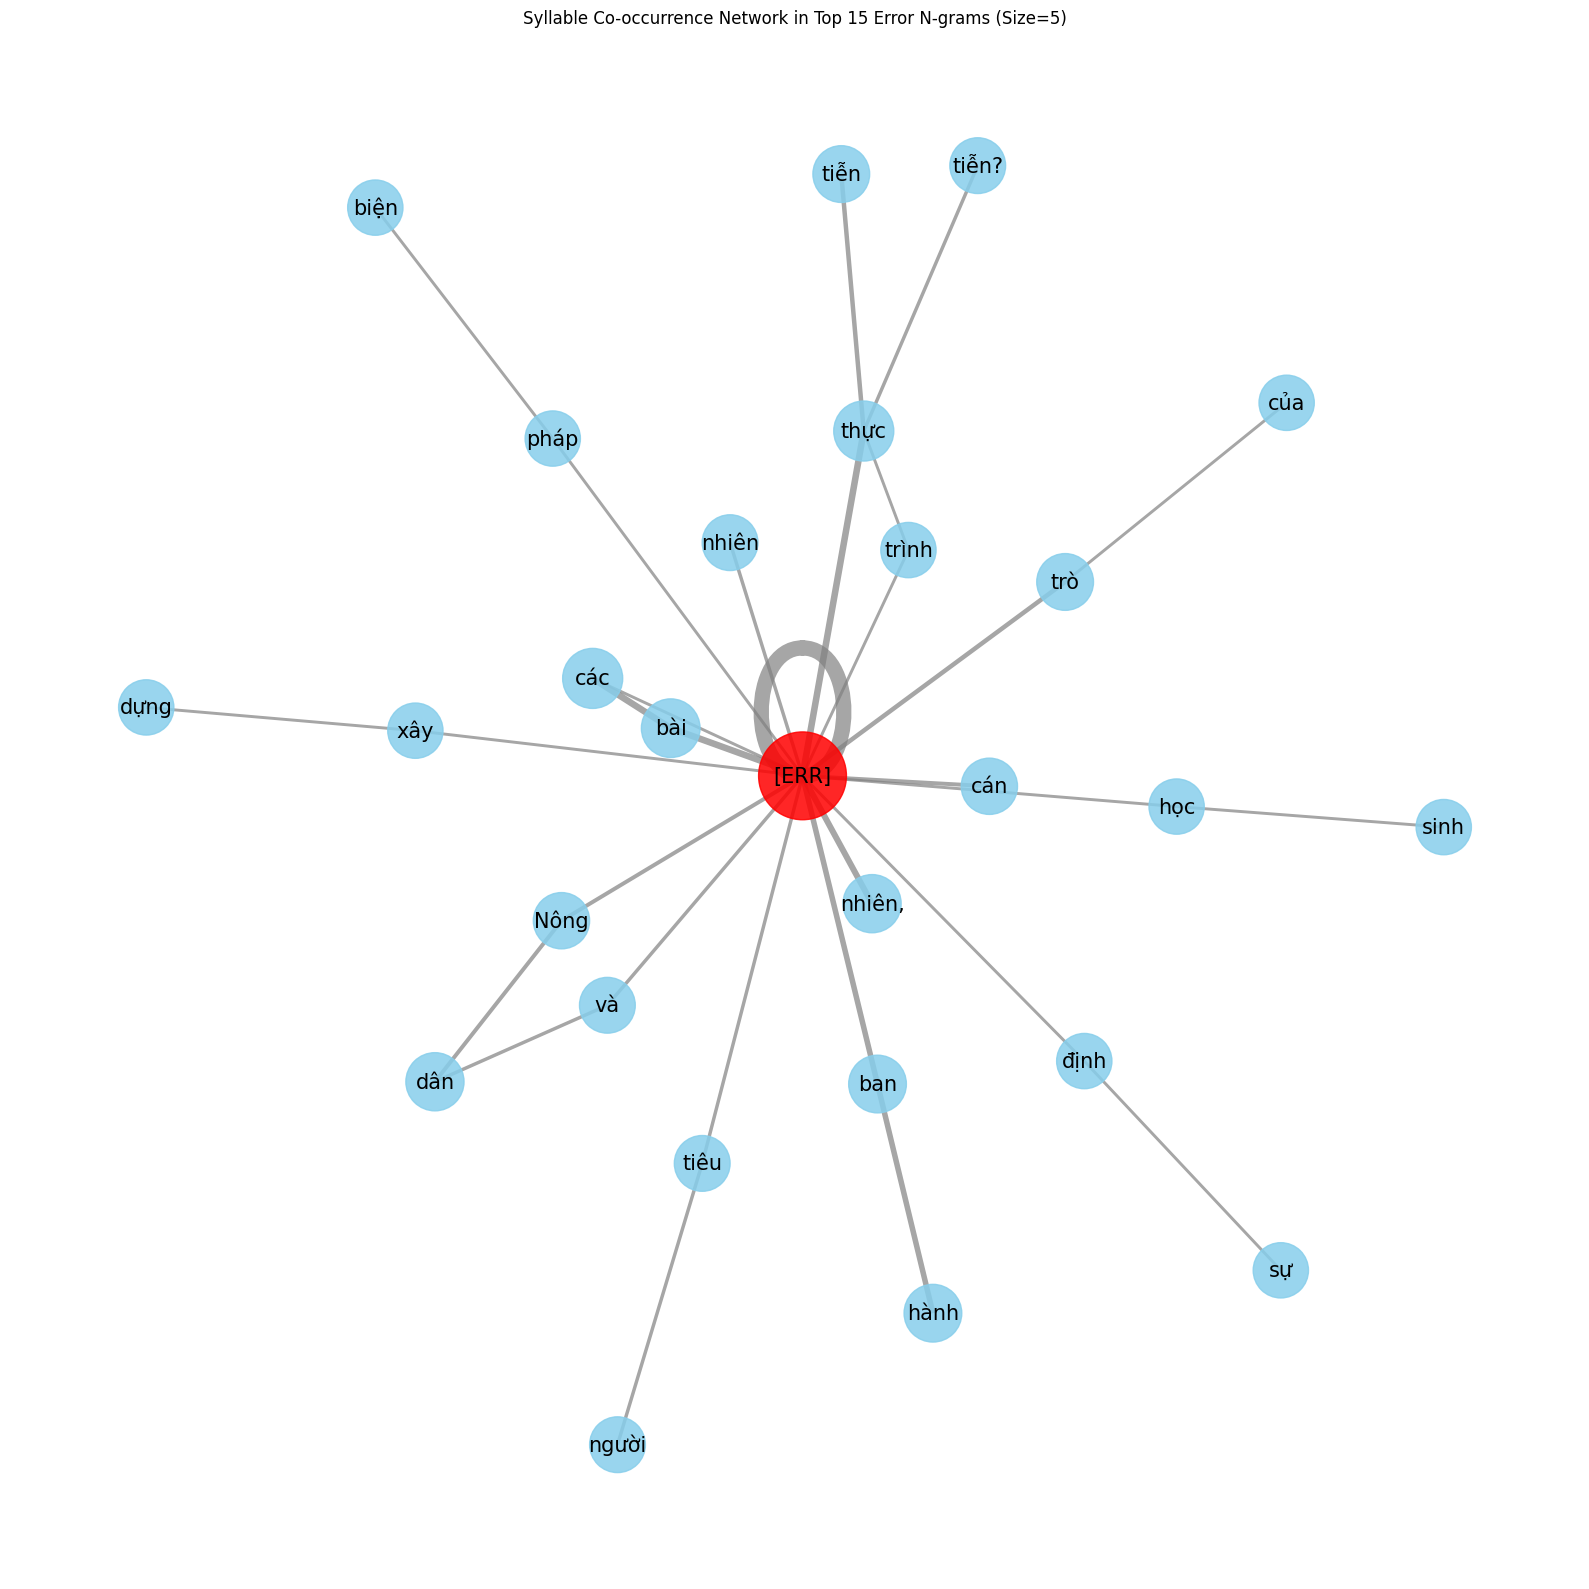

In [83]:
# Optimized Network Graph: combines weight accuracy and clarity from both versions
if nx is not None and top_patterns:
    print("Generating Optimized N-gram Network Graph...")
    plt.figure(figsize=(16, 16))
    G = nx.Graph()
    edge_weights = Counter()
    node_freq = Counter()

    # Build node and edge data from top patterns with actual counts
    for pattern, count in top_patterns:
        for i in range(len(pattern)):
            syl1 = pattern[i]
            if syl1 == '[PAD]': continue
            node_freq[syl1] += count
            if i < len(pattern) - 1:
                syl2 = pattern[i+1]
                if syl2 == '[PAD]': continue
                edge = tuple(sorted((syl1, syl2)))
                edge_weights[edge] += count

    # Add nodes with attributes
    max_node_freq = max(node_freq.values()) if node_freq else 1
    for syl, freq in node_freq.items():
        size = 1500 + (freq / max_node_freq) * 2500  # Increase node size
        color = 'red' if syl == '[ERR]' else 'skyblue'
        G.add_node(syl, size=size, color=color)

    # Add edges with weights
    max_edge_weight = max(edge_weights.values()) if edge_weights else 1
    for (syl1, syl2), weight in edge_weights.items():
        norm_weight = 1 + (weight / max_edge_weight) * 10  # Increase edge width
        G.add_edge(syl1, syl2, weight=norm_weight)

    if G.number_of_nodes() > 0:
        try:
            print("  Calculating layout...")
            pos = nx.spring_layout(G, k=0.9 / math.sqrt(G.number_of_nodes()), iterations=50, seed=42, weight='weight')
            edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
            node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
            node_colors = [G.nodes[n]['color'] for n in G.nodes()]

            print("  Drawing graph...")
            nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7)  # Adjusted opacity
            nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
            nx.draw_networkx_labels(G, pos, font_size=15)  # Increased font size

            plt.title(f'Syllable Co-occurrence Network in Top {TOP_N_PATTERNS} Error N-grams (Size={NGRAM_SIZE})')
            plt.axis('off'); plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, "ngram_network_graph.png"))
            print(f"Saved {PLOT_DIR}/ngram_network_graph.png")
            plt.show()
        except Exception as e:
            print(f"  Failed to draw network graph: {e}")
    else:
        print("  No nodes/edges to draw network graph.")
else:
    print("Skipping N-gram Network Graph (networkx not available or no top patterns).")

Generating N-gram Error Position Heatmap...
Saved plots_error_patterns/ngram_error_position_heatmap.png


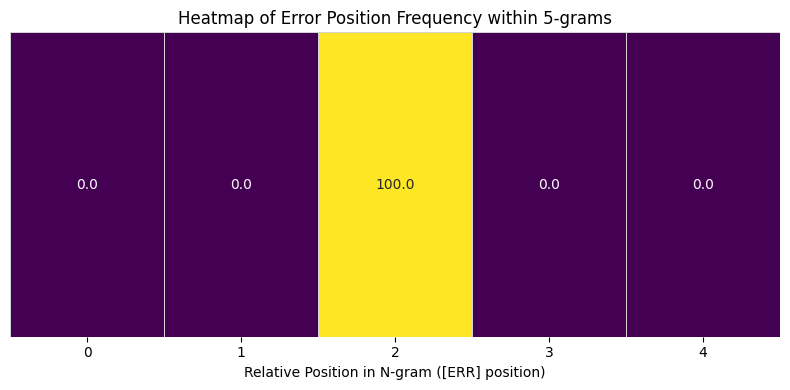

--- Finished (1.12s) ---


In [84]:
# Heatmap of error position within N-grams
if error_pos_in_ngram:
    print("Generating N-gram Error Position Heatmap...")
    plt.figure(figsize=(8, 4))
    # Count errors at each position 0 to NGRAM_SIZE-1
    pos_counts = Counter(error_pos_in_ngram)
    positions = range(NGRAM_SIZE)
    counts = [pos_counts.get(p, 0) for p in positions]
    df_heatmap = pd.DataFrame({'count': counts}, index=positions)
    # Normalize counts to percentage
    df_heatmap['percentage'] = (df_heatmap['count'] / sum(counts)) * 100

    sns.heatmap(df_heatmap[['percentage']].T, annot=True, fmt=".1f", cmap="viridis", cbar=False, linewidths=0.5, linecolor='lightgray')
    plt.title(f'Heatmap of Error Position Frequency within {NGRAM_SIZE}-grams')
    plt.xlabel('Relative Position in N-gram ([ERR] position)')
    plt.ylabel('')
    plt.yticks([]) # No y-axis label needed
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "ngram_error_position_heatmap.png"))
    print(f"Saved {PLOT_DIR}/ngram_error_position_heatmap.png")
    plt.show()
else: print("Skipping N-gram Error Position Heatmap (no n-gram data).")

print(f"--- Finished ({time.time() - start_time_b:.2f}s) ---")

In [85]:
print("\n--- Application to Model Training (Conceptual Code & Guidance) ---")
start_time_c = time.time()

# Negative Sample Generation
def generate_negatives_from_cluster(root_syllable, cluster_members, error_freq_lookup, n_samples=5, exclude_root=True):
    """Generates negative samples based on a cluster of variants, excluding the root."""
    neg_samples = []
    # Get variants excluding the root (most frequent)
    variants = [v for v in cluster_members if v != root_syllable] if exclude_root else list(cluster_members)
    if not variants: return []
    # Sample randomly, potentially weighted by frequency? For now, uniform.
    # Ensure variants list is not empty before sampling
    if variants:
         # Ensure n_samples is not larger than the number of available variants
        actual_n_samples = min(n_samples, len(variants))
        selected_variants = np.random.choice(variants, size=actual_n_samples, replace=False)
        return list(selected_variants)
    else:
        return []


print(" Negative Sample Generation (Example for Top 3 Clusters):")
if df_clusters is not None and not df_clusters.empty:
     for idx, row in df_clusters.head(3).iterrows():
         root = row['root']
         variants = row['members']
         # Pass the global error_freq counter
         neg_samples = generate_negatives_from_cluster(root, variants, error_freq, n_samples=NEGATIVE_SAMPLE_COUNT)
         print(f"\n  Cluster Root (Most Freq): '{root}' (Freq: {error_freq.get(root, 0)})")
         print(f"  Variants in cluster: {variants}")
         print(f"  Generated negative samples: {neg_samples}")
else: print("  - No error clusters found to demonstrate negative sampling.")

# Function to apply generation to a sentence (conceptual)
def create_training_examples(sentence_info, cluster_map, error_freq_lookup, n_neg_samples=3):
    """ Creates potential training pairs (correct_sent, incorrect_sent) """
    examples = []
    original_sentence = sentence_info['sentence'] # Assume sentence is reconstructed correctly
    syllables = original_sentence.split() # Simple split, ideally use tokens
    has_error_in_sentence = False

    new_incorrect_sentences = set() # Avoid duplicate generated sentences

    # Placeholder: Assume we have a way to map sentence syllables back to original annotations
    # This requires more complex alignment than currently implemented.
    # For demonstration, let's iterate through syllables and *if* it's a known error root, generate variants.

    possible_correct_indices = [] # Indices where we *could* inject a generated error

    # Simplified Demo: Find frequent correct words that are roots of error clusters
    for i, syl in enumerate(syllables):
        syl_lower = syl.lower()
        # Check if this syllable is a 'root' of a known error cluster
        if syl_lower in cluster_map.values() and syl_lower == cluster_map.get(syl_lower):
            possible_correct_indices.append(i)
            cluster_root = syl_lower
            # Find the cluster members for this root
            cluster_members = []
            for root, members in cluster_map.items(): # Inefficient search, better map needed
                if root == cluster_root:
                    cluster_members = members
                    break

            if cluster_members:
                neg_variants = generate_negatives_from_cluster(cluster_root, cluster_members, error_freq_lookup, n_neg_samples)
                for variant in neg_variants:
                    temp_syllables = list(syllables)
                    temp_syllables[i] = variant # Replace with a negative sample
                    new_incorrect_sentences.add(" ".join(temp_syllables))

    # Add original correct/incorrect pairs from VSEC data (assuming we can reconstruct)
    # This requires linking back to the original annotations and identifying the *actual* correct version
    # examples.append({'correct': reconstructed_correct_sent, 'incorrect': original_sentence_with_errors})

    # Add generated pairs
    for incorrect_sent in new_incorrect_sentences:
         examples.append({'correct': original_sentence, 'incorrect': incorrect_sent})

    return examples

# print("\nExample of creating training pairs (conceptual):")
# if not df_analysis.empty:
#     example_sentence_info = df_analysis.iloc[0] # Take first analyzed sentence
#     # We need error_to_cluster_root map from grouping function
#     training_pairs = create_training_examples(example_sentence_info, error_to_cluster_root, error_freq)
#     print(f"Generated {len(training_pairs)} potential training examples for the first sentence.")
#     # print(training_pairs[:2]) # Print a couple examples
# else:
#     print("No analyzed sentences to demonstrate training pair generation.")


# # C.2 Balancing Dataset (Guidance)
# print("\nC.2 Dataset Balancing Guidance:")
# print(f"  - Add generated negative samples strategically to the training data.")
# print(f"  - Monitor the ratio of synthetic vs. original data (e.g., keep synthetic <= 20%).")
# print(f"  - Focus on generating samples for the most frequent error clusters (Top {TOP_N_ERRORS} clusters cover {df_clusters['percentage'].head(TOP_N_ERRORS).sum():.1f}% of errors).")
# print(f"  - Consider upsampling original rare errors or downsampling very common correct patterns if needed.")

# # C.3 Evaluating Effectiveness (Guidance)
# print("\nC.3 Evaluating Effectiveness (Guidance):")
# print(f"  - Requires training separate models (baseline vs. augmented data).")
# print(f"  - Compare standard metrics (Accuracy, F1, CER, WER).")
# print(f"  - CRITICAL: Evaluate Recall specifically for the targeted error clusters/patterns.")
# print(f"    - Create a test subset containing only sentences with errors from the top clusters.")
# print(f"    - Measure how much recall improves on these specific errors.")

# # C.4 Visualization (Guidance)
# print("\nC.4 Visualization (Guidance - Requires Model Results):")
# print(f"  - Plot Precision-Recall Curves on the targeted error subset.")
# print(f"  - Create Bar Charts comparing Recall per error cluster (Baseline vs. Augmented Model).")

# print(f"--- Section C Finished ({time.time() - start_time_c:.2f}s) ---")


--- Application to Model Training (Conceptual Code & Guidance) ---
 Negative Sample Generation (Example for Top 3 Clusters):

  Cluster Root (Most Freq): 'nhưng' (Freq: 54)
  Variants in cluster: ['nhưng', 'hướng', 'hương', 'những', 'hưởng', 'nhứng', 'nhũng', 'hượng', 'nhung', 'chưng', 'hường', 'hưỡng', 'nhựng', 'nượng', 'nhưngi', 'nhừng', 'nhượn', 'nhưnghx', 'nưng']
  Generated negative samples: ['những', 'nhung', 'nhưngi', 'nhứng', 'hường', 'hượng', 'nhượn']

  Cluster Root (Most Freq): 'trong' (Freq: 54)
  Variants in cluster: ['trong', 'trang', 'trọng', 'tron', 'thong', 'tong', 'trog', 'trong,', 'trng', 'rong', 'trung', 'trông', 'trạng', 'tròng', 'tráng', 'ttrong', 'troong', 'trừng', 'trăng', 'trùng', 'trưng', 'tring', 'tong.', 'trongvỏ', 'toong', 'strong', 'trong.', 'trậng', 'tronmg', 'trộng', 'tróng', 'trẳng']
  Generated negative samples: ['tron', 'trng', 'trăng', 'rong', 'trông', 'trưng', 'trang']

  Cluster Root (Most Freq): 'các' (Freq: 80)
  Variants in cluster: ['các', 'cá

# Phân tích dạng lỗi cụ thể cho tiếng Việt

In [86]:
try:
    from underthesea import pos_tag, word_tokenize
    UNDERTHESEA_AVAILABLE = True
    print("OK: underthesea loaded.")
except ImportError:
    print("WARNING: underthesea not found. Install it: pip install underthesea")
    print("         POS tagging for tone errors (A.3) will be skipped.")
    UNDERTHESEA_AVAILABLE = False

OK: underthesea loaded.


In [87]:
PLOT_DIR = "plots_specific_errors"
TOP_N_TONE_ERRORS = 10
TOP_N_PUNCT_ERRORS = 5
CONTEXT_WINDOW_SIZE = 20 # Số ký tự context cho sequence plot

# --- Vietnamese Tone Characters (Unicode) ---
# Source: https://unicode-table.com/en/blocks/combining-diacritical-marks/
# Note: This includes precomposed characters directly
TONE_HOI = "ảẻỉỏủỷẩểỉổửỷ"
TONE_NGA = "ãẽĩõũỹẫễĩỗữỹ"
HOI_CHARS = set(list(TONE_HOI))
NGA_CHARS = set(list(TONE_NGA))

# --- Regex for Punctuation Errors (B.1) ---
REGEX_PUNC_NO_SPACE_AFTER = re.compile(r'(\w)([.,!?])(\w)') # Word -> Punc -> Word
REGEX_PUNC_SPACE_BEFORE = re.compile(r'(\s+)([.,!?])')     # Space -> Punc
REGEX_PUNC_DOUBLE = re.compile(r'([.,!?])\1{1,}')         # Repeated punc like ?? !! ,, .. (excluding ... intentionally?)
REGEX_PUNC_ELLIPSIS_WRONG = re.compile(r'\.{2}|\.{4,}') # Detects .. or ....+ (correct ellipsis is ...)

In [88]:
HOMOPHONES = {
    'dành': {'giành'}, 'giành': {'dành'},
    'sửa': {'sữa'}, 'sữa': {'sửa'},
    'chín': {'chính'}, 'chính': {'chín'},
    'lẽ': {'lẻ', 'lẻn'}, 'lẻ': {'lẽ', 'lẻn'}, 'lẻn': {'lẽ', 'lẻ'},
    'vô': {'vồ'}, 'vồ': {'vô'},
    'rồi': {'dồi'}, 'dồi': {'rồi'},
    'kiểm': {'kiếm'}, 'kiếm': {'kiểm'},
    'xử': {'sử'}, 'sử': {'xử'},
    'chung': {'trung'}, 'trung': {'chung'},
    'sát': {'xát'}, 'xát': {'sát'},
    'chuyện': {'truyện'}, 'truyện': {'chuyện'},
    'lữa': {'nữa'}, 'nữa': {'lữa'},
    'cổ': {'cũ'}, 'cũ': {'cổ'},
    'làng': {'làn'}, 'làn': {'làng'},
    'bàn': {'bàng'}, 'bàng': {'bàn'},
    'về': {'dề'}, 'dề': {'về'},
    'nói': {'nỗi'}, 'nỗi': {'nói'},
    'năm': {'nam'}, 'nam': {'năm'},
    'nước': {'nức'}, 'nức': {'nước'},
    'bổ': {'bộ'}, 'bộ': {'bổ'},
    'xong': {'song'}, 'song': {'xong'},
    'sang': {'xang'}, 'xang': {'sang'},
    'dụng': {'dũng'}, 'dũng': {'dụng'},
    'sang': {'xang'}, 'xang': {'sang'},
    'dậy': {'dạy'}, 'dạy': {'dậy'},
    'hòa': {'hoà'}, 'hoà': {'hòa'},
    'dự': {'giữ'}, 'giữ': {'dự'},
    'hành': {'hạnh'}, 'hạnh': {'hành'},
    'cảnh': {'cạnh'}, 'cạnh': {'cảnh'},
    'kỷ': {'kĩ'}, 'kĩ': {'kỷ'},
    'thẻ': {'thé'}, 'thé': {'thẻ'},
    'hành': {'hàng'}, 'hàng': {'hành'},
    'bảo': {'bạo'}, 'bạo': {'bảo'},
    'mở': {'mợ'}, 'mợ': {'mở'},
    'nghĩa': {'nghỉa'}, 'nghỉa': {'nghĩa'},
}
# Create a flat set of all words involved in homophone pairs for quick checking
ALL_HOMOPHONE_WORDS = set(HOMOPHONES.keys()).union(*(HOMOPHONES.values()))

# Ensure plot directory exists
os.makedirs(PLOT_DIR, exist_ok=True)

In [89]:
def reconstruct_text_with_error_map(annotations):
    # (Same as previous version - reconstructs text and creates syllable map)
    if not annotations: return "", {}, 0, 0
    text = ""; syllable_map = {}; current_char_index = 0; error_count = 0
    for i, ann in enumerate(annotations):
        syllable = ann.get('current_syllable', ''); is_correct = ann.get('is_correct', True)
        syllable_strip = syllable.strip()
        if not is_correct: error_count += 1
        start_char = current_char_index; end_char = start_char + len(syllable)
        syllable_map[i] = {'text': syllable_strip, 'is_correct': is_correct, 'start_char': start_char, 'end_char': end_char, 'original_syllable': syllable}
        if i > 0 and text and not text.endswith(' ') and syllable and not re.match(r'^[\s,.!?]+', syllable):
            text += " "; current_char_index += 1
        text += syllable; current_char_index += len(syllable)
    text_clean = re.sub(r'\s+', ' ', text).strip()
    text_clean = re.sub(r'\s+([,.!?])', r'\1', text_clean); text_clean = re.sub(r'([({[])\s+', r'\1', text_clean); text_clean = re.sub(r'\s+([)}\]])', r'\1', text_clean)
    return text_clean, syllable_map, error_count, len(annotations)


def get_pos_tag(word):
    """Get POS tag for a single word/syllable using underthesea."""
    if not UNDERTHESEA_AVAILABLE or not word or not isinstance(word, str): return "UNK"
    try:
        tagged = pos_tag(word)
        # Return first tag, or UNK if none found
        return tagged[0][1] if tagged else "UNK"
    except Exception: return "UNK" # Fallback

def get_error_context(text, match_start, match_end, window=20): # Increased window
    """Extracts context around a regex match, highlighting the match."""
    start = max(0, match_start - window)
    end = min(len(text), match_end + window)
    pre_context = text[start:match_start]
    match_text = text[match_start:match_end]
    post_context = text[match_end:end]
    # Using markdown bold for highlighting
    return f"{pre_context}**{match_text}**{post_context}"

In [90]:
all_analysis_data = [] # Stores results for each entry
total_error_count = 0
# *** Initialize context_examples HERE ***
context_examples = defaultdict(list) # {error_type_code: [context_str,...]}
limit_examples_per_type = 5 # Max examples to store per type

start_time_pre = time.time()
for i, entry in enumerate(data):
    annotations = entry.get('annotations', [])
    if not annotations: continue

    text_block, syllable_map, block_error_count, block_syllable_count = reconstruct_text_with_error_map(annotations)
    if not text_block: continue
    total_error_count += block_error_count

    # Extract specific errors
    tone_hoi_errors = []
    tone_nga_errors = []
    homophone_errors_found = []

    for syl_idx, ann_data in syllable_map.items():
        syllable_text = ann_data['text']
        original_syllable = ann_data['original_syllable']
        is_correct = ann_data['is_correct']

        if not is_correct and syllable_text:
            syllable_lower = syllable_text.lower()
            # A.1 Check for tone errors
            original_lower_nfc = unicodedata.normalize('NFC', original_syllable.lower())
            has_hoi = any(c in HOI_CHARS for c in original_lower_nfc)
            has_nga = any(c in NGA_CHARS for c in original_lower_nfc)
            pos_tag_result = get_pos_tag(original_syllable) # Get POS tag once

            if has_hoi:
                tone_hoi_errors.append({'error': original_syllable, 'pos': pos_tag_result})
            if has_nga:
                tone_nga_errors.append({'error': original_syllable, 'pos': pos_tag_result})

            # C.1 Check for homophone errors
            if syllable_lower in ALL_HOMOPHONE_WORDS:
                 possible_intended = HOMOPHONES.get(syllable_lower, set())
                 homophone_errors_found.append({'error': original_syllable, 'possible_correct': possible_intended})

    # B.1 Check for punctuation errors using regex and collect context examples
    punc_no_space_after = []
    for m in REGEX_PUNC_NO_SPACE_AFTER.finditer(text_block):
        punc_no_space_after.append((m.group(0), m.start(), m.end(), m.group(2))) # Store full match, start, end, punc
        if len(context_examples['NSA']) < limit_examples_per_type:
             # Get context around the punctuation mark itself (group 2)
             context_examples['NSA'].append(get_error_context(text_block, m.start(2), m.end(2), CONTEXT_WINDOW_SIZE))

    punc_space_before = []
    for m in REGEX_PUNC_SPACE_BEFORE.finditer(text_block):
        punc_space_before.append((m.group(0), m.start(), m.end(), m.group(2)))
        if len(context_examples['SB']) < limit_examples_per_type:
             context_examples['SB'].append(get_error_context(text_block, m.start(2), m.end(2), CONTEXT_WINDOW_SIZE))

    punc_double = []
    for m in REGEX_PUNC_DOUBLE.finditer(text_block):
        punc_double.append((m.group(0), m.start(), m.end(), m.group(1))) # group 1 is the repeated punc
        if len(context_examples['DP']) < limit_examples_per_type:
             context_examples['DP'].append(get_error_context(text_block, m.start(), m.end(), CONTEXT_WINDOW_SIZE))

    punc_ellipsis = []
    for m in REGEX_PUNC_ELLIPSIS_WRONG.finditer(text_block):
        punc_ellipsis.append((m.group(0), m.start(), m.end(), '.')) # Treat as '.' error
        if len(context_examples['WE']) < limit_examples_per_type:
             context_examples['WE'].append(get_error_context(text_block, m.start(), m.end(), CONTEXT_WINDOW_SIZE))

    # Store all data for the entry
    all_analysis_data.append({
        'text_block': text_block, 'total_syllables': block_syllable_count, 'total_errors': block_error_count,
        'tone_hoi_errors': tone_hoi_errors, 'tone_nga_errors': tone_nga_errors,
        'punc_no_space_after': punc_no_space_after, 'punc_space_before': punc_space_before,
        'punc_double': punc_double, 'punc_ellipsis': punc_ellipsis,
        'homophone_errors': homophone_errors_found
    })

    if (i + 1) % 2000 == 0: print(f"  Processed {i+1}/{len(data)} entries...")

print(f"Preprocessing finished ({time.time() - start_time_pre:.2f}s). Total errors counted: {total_error_count}")
if total_error_count == 0: print("Warning: No errors found."); exit()

  Processed 2000/9341 entries...
  Processed 4000/9341 entries...
  Processed 6000/9341 entries...
  Processed 8000/9341 entries...
Preprocessing finished (4.45s). Total errors counted: 11202


In [91]:
print("\n--- Vietnamese Tone Errors (Hỏi/Ngã) ---")
start_time_a = time.time()

# Aggregate all tone errors
all_hoi_errors_detailed = [err for entry in all_analysis_data for err in entry['tone_hoi_errors']]
all_nga_errors_detailed = [err for entry in all_analysis_data for err in entry['tone_nga_errors']]
hoi_error_count = len(all_hoi_errors_detailed)
nga_error_count = len(all_nga_errors_detailed)
total_tone_errors = hoi_error_count + nga_error_count

print("Statistics:")
print(f"- Total Incorrect Syllables with Hỏi tone: {hoi_error_count}")
print(f"- Total Incorrect Syllables with Ngã tone: {nga_error_count}")
print(f"- Percentage of Tone Errors (Hỏi/Ngã) among all errors: {total_tone_errors / total_error_count:.2%}")

hoi_error_freq = Counter(err['error'] for err in all_hoi_errors_detailed)
nga_error_freq = Counter(err['error'] for err in all_nga_errors_detailed)

print(f"\n- Top {TOP_N_TONE_ERRORS} most frequent incorrect syllables with Hỏi tone:")
if hoi_error_freq:
    for syl, count in hoi_error_freq.most_common(TOP_N_TONE_ERRORS): print(f"  - '{syl}': {count}")
else: print("  - None found.")

print(f"\n- Top {TOP_N_TONE_ERRORS} most frequent incorrect syllables with Ngã tone:")
if nga_error_freq:
    for syl, count in nga_error_freq.most_common(TOP_N_TONE_ERRORS): print(f"  - '{syl}': {count}")
else: print("  - None found.")
print("\n- Region-based analysis: Skipped (no metadata).")


--- Vietnamese Tone Errors (Hỏi/Ngã) ---
Statistics:
- Total Incorrect Syllables with Hỏi tone: 1502
- Total Incorrect Syllables with Ngã tone: 515
- Percentage of Tone Errors (Hỏi/Ngã) among all errors: 18.01%

- Top 10 most frequent incorrect syllables with Hỏi tone:
  - 'thoả': 64
  - 'để': 44
  - 'khoẻ': 42
  - 'Uỷ': 38
  - 'nổ': 34
  - 'thể': 32
  - 'hiểu': 27
  - 'điểu': 26
  - 'thuỷ': 26
  - 'cuả': 26

- Top 10 most frequent incorrect syllables with Ngã tone:
  - 'cũng': 22
  - 'sẽ': 20
  - 'thõa': 19
  - 'vẫn': 17
  - 'những': 14
  - 'triễn': 14
  - 'đã': 13
  - 'luỹ': 13
  - 'dữ': 11
  - 'mỗi': 11

- Region-based analysis: Skipped (no metadata).


  - Generating Stacked Bar Chart with POS tags...


/tmp/ipykernel_19/1618796366.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Saved plots_specific_errors/tone_error_distribution_stacked.png


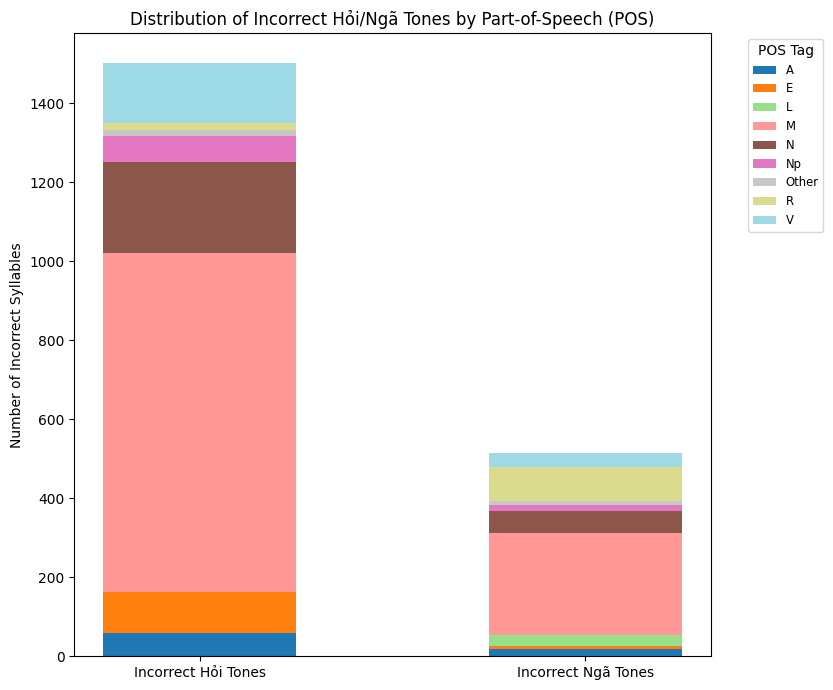

In [92]:
pos_counts_hoi = Counter(err['pos'] for err in all_hoi_errors_detailed)
pos_counts_nga = Counter(err['pos'] for err in all_nga_errors_detailed)
plt.figure(figsize=(10, 7))
index_a = np.array([0, 1]); bar_width = 0.5

if UNDERTHESEA_AVAILABLE and (pos_counts_hoi or pos_counts_nga):
    print("  - Generating Stacked Bar Chart with POS tags...")
    all_pos_tags = sorted(list(set(pos_counts_hoi.keys()) | set(pos_counts_nga.keys())))
    pos_threshold = max(1, int(total_tone_errors * 0.01)) # Min count threshold
    main_pos_tags = [tag for tag in all_pos_tags if pos_counts_hoi.get(tag,0) + pos_counts_nga.get(tag,0) >= pos_threshold and tag != 'UNK']
    pos_map = {tag: tag for tag in main_pos_tags}
    pos_map.update({tag: 'Other' for tag in all_pos_tags if tag not in main_pos_tags})
    pos_map['UNK'] = 'Unknown'
    grouped_pos_hoi = Counter(); grouped_pos_nga = Counter()
    for err in all_hoi_errors_detailed: grouped_pos_hoi[pos_map.get(err['pos'], 'Unknown')] += 1
    for err in all_nga_errors_detailed: grouped_pos_nga[pos_map.get(err['pos'], 'Unknown')] += 1
    plot_tags = sorted(list(set(grouped_pos_hoi.keys()) | set(grouped_pos_nga.keys())))
    colors = plt.cm.get_cmap('tab20', len(plot_tags))
    bottom_hoi, bottom_nga = 0, 0
    for i, tag in enumerate(plot_tags):
        hoi_val = grouped_pos_hoi.get(tag, 0); nga_val = grouped_pos_nga.get(tag, 0)
        plt.bar(index_a[0], hoi_val, bar_width, bottom=bottom_hoi, label=f'{tag}', color=colors(i % len(plot_tags))) # Use modulo for color index safety
        plt.bar(index_a[1], nga_val, bar_width, bottom=bottom_nga, color=colors(i % len(plot_tags)))
        bottom_hoi += hoi_val; bottom_nga += nga_val
    plt.ylabel('Number of Incorrect Syllables'); plt.title('Distribution of Incorrect Hỏi/Ngã Tones by Part-of-Speech (POS)')
    plt.xticks(index_a, ['Incorrect Hỏi Tones', 'Incorrect Ngã Tones']); plt.legend(title="POS Tag", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
else:
    # Simple bar chart if POS tagging skipped or failed
    print("  - Generating simple Bar Chart (POS tagging skipped)...")
    plt.bar(['Incorrect Hỏi Tones', 'Incorrect Ngã Tones'], [hoi_error_count, nga_error_count], color=['skyblue', 'salmon'], width=bar_width)
    plt.ylabel('Number of Incorrect Syllables'); plt.title('Count of Incorrect Hỏi vs. Ngã Tones')
    plt.tight_layout()

plt.savefig(os.path.join(PLOT_DIR, "tone_error_distribution_stacked.png"))
print(f"Saved {PLOT_DIR}/tone_error_distribution_stacked.png")
plt.show()

In [93]:
print("\n- Frequency Table (Top Combined Incorrect Tone Syllables):")
combined_tone_errors_freq = hoi_error_freq + nga_error_freq
df_tone_freq = pd.DataFrame(combined_tone_errors_freq.most_common(TOP_N_TONE_ERRORS * 2), columns=['Incorrect Syllable', 'Frequency'])
df_tone_freq['Likely Tone Type'] = df_tone_freq['Incorrect Syllable'].apply(lambda x: 'Hỏi' if any(c in HOI_CHARS for c in unicodedata.normalize('NFC', x.lower())) else ('Ngã' if any(c in NGA_CHARS for c in unicodedata.normalize('NFC', x.lower())) else 'Other'))
print(df_tone_freq.head(15).to_markdown(index=False))
print(f"--- Section A Finished ({time.time() - start_time_a:.2f}s) ---")


- Frequency Table (Top Combined Incorrect Tone Syllables):
| Incorrect Syllable   |   Frequency | Likely Tone Type   |
|:---------------------|------------:|:-------------------|
| thoả                 |          64 | Hỏi                |
| để                   |          44 | Hỏi                |
| khoẻ                 |          42 | Hỏi                |
| Uỷ                   |          38 | Hỏi                |
| nổ                   |          34 | Hỏi                |
| thể                  |          32 | Hỏi                |
| hiểu                 |          27 | Hỏi                |
| điểu                 |          26 | Hỏi                |
| thuỷ                 |          26 | Hỏi                |
| cuả                  |          26 | Hỏi                |
| sử                   |          24 | Hỏi                |
| của                  |          23 | Hỏi                |
| bản                  |          22 | Hỏi                |
| cũng                 |          22 | N

In [94]:
print("\n--- Vietnamese Punctuation Errors ---")
start_time_b = time.time()

# Aggregate counts from pre-processing results
punc_errors_agg_b = defaultdict(Counter)
total_punc_matches_b = 0
sentences_with_punc_error_len_b = []
unique_entries_with_punc_error_b = set()

for i, entry in enumerate(all_analysis_data):
    has_punc_error_entry = False
    # NSA
    matches = entry['punc_no_space_after']
    if matches:
        has_punc_error_entry = True
        for _, _, _, punc in matches: punc_errors_agg_b['NSA'][punc] += 1
        total_punc_matches_b += len(matches)
    # SB
    matches = entry['punc_space_before']
    if matches:
        has_punc_error_entry = True
        for _, _, _, punc in matches: punc_errors_agg_b['SB'][punc] += 1
        total_punc_matches_b += len(matches)
    # DP
    matches = entry['punc_double']
    if matches:
        has_punc_error_entry = True
        for pattern, _, _, punc in matches: punc_errors_agg_b['DP'][pattern] += 1 # Count full pattern
        total_punc_matches_b += len(matches)
    # WE
    matches = entry['punc_ellipsis']
    if matches:
        has_punc_error_entry = True
        for pattern, _, _, _ in matches: punc_errors_agg_b['WE'][pattern] += 1
        total_punc_matches_b += len(matches)

    if has_punc_error_entry:
        unique_entries_with_punc_error_b.add(i)
        sentences_with_punc_error_len_b.append(len(entry['text_block'].split())) # Approx length

print("\n Punctuation Error Statistics:")
if total_punc_matches_b > 0:
    print("- Distribution of Punctuation Error Types (% of total matches):")
    error_type_map_b = {'NSA': 'No Space After', 'SB': 'Space Before', 'DP': 'Double Punc', 'WE': 'Wrong Ellipsis'}
    for err_type, counts in punc_errors_agg_b.items():
        type_total = sum(counts.values())
        print(f"  - {error_type_map_b.get(err_type, err_type)}: {type_total} matches ({type_total/total_punc_matches_b:.1%})")

    all_involved_punc_b = Counter()
    for punc, count in punc_errors_agg_b['NSA'].items(): all_involved_punc_b[punc] += count
    for punc, count in punc_errors_agg_b['SB'].items(): all_involved_punc_b[punc] += count
    for pattern, count in punc_errors_agg_b['DP'].items():
        if pattern: all_involved_punc_b[pattern[0]] += count # Base punc
    for pattern, count in punc_errors_agg_b['WE'].items(): all_involved_punc_b['.'] += count

    print(f"\n- Top {TOP_N_PUNCT_ERRORS} most frequent punctuation marks involved:")
    if all_involved_punc_b:
        for punc, count in all_involved_punc_b.most_common(TOP_N_PUNCT_ERRORS): print(f"  - '{punc}': {count}")
    else: print("  - None found.")

    avg_len_punc_err_sent = np.mean(sentences_with_punc_error_len_b) if sentences_with_punc_error_len_b else 0
    print(f"\n- Average Length (approx words) of text blocks containing punctuation errors: {avg_len_punc_err_sent:.1f}")
else: print("- No punctuation errors detected by regex patterns.")


--- Vietnamese Punctuation Errors ---

 Punctuation Error Statistics:
- Distribution of Punctuation Error Types (% of total matches):
  - No Space After: 575 matches (65.3%)
  - Double Punc: 153 matches (17.4%)
  - Wrong Ellipsis: 152 matches (17.3%)

- Top 5 most frequent punctuation marks involved:
  - '.': 631
  - ',': 248
  - '?': 1

- Average Length (approx words) of text blocks containing punctuation errors: 31.4



🔍 Punctuation Error Visualizations (Grouped by Punctuation Type):
  Generating Heatmap of Punctuation Error Position...


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



Saved plots_specific_errors/heatmap_punctuation_error_position.png


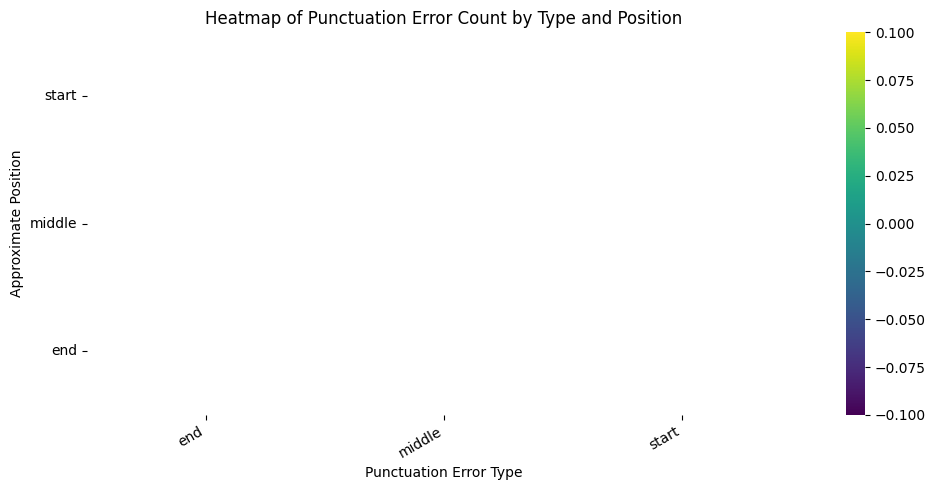

In [95]:
print("\n🔍 Punctuation Error Visualizations (Grouped by Punctuation Type):")
# Heatmap: Vị trí lỗi dấu câu sai
print("  Generating Heatmap of Punctuation Error Position...")
pos_punc_errors_b = defaultdict(lambda: defaultdict(int))
error_type_map_b = {'NSA': 'No Space After', 'SB': 'Space Before', 'DP': 'Double Punc', 'WE': 'Wrong Ellipsis'}
punc_map = {'.': '.', ',': ',', '?': '?', '!': '!'}

for i, entry in enumerate(all_analysis_data):
    text = entry['text_block']; text_len = len(text)
    if text_len == 0: continue
    def get_pos_cat(char_index, length):
        if length == 0: return 'middle'
        rel_pos = char_index / length
        if rel_pos < 0.2: return 'start'
        elif rel_pos > 0.8: return 'end'
        else: return 'middle'

    # Populate heatmap data based on stored match info
    for _, start, _, punc in entry['punc_no_space_after']: pos_punc_errors_b[get_pos_cat(start, text_len)][f"{punc_map.get(punc, '?')} (NSA)"] += 1
    for _, start, _, punc in entry['punc_space_before']: pos_punc_errors_b[get_pos_cat(start, text_len)][f"{punc_map.get(punc, '?')} (SB)"] += 1
    for pattern, start, _, punc in entry['punc_double']: pos_punc_errors_b[get_pos_cat(start, text_len)][f"{punc_map.get(punc, '?')} (DP)"] += 1
    for pattern, start, _, _ in entry['punc_ellipsis']: pos_punc_errors_b[get_pos_cat(start, text_len)]["... (WE)"] += 1

df_heatmap_punc_b = pd.DataFrame(pos_punc_errors_b).fillna(0).astype(int)
if not df_heatmap_punc_b.empty:
    df_heatmap_punc_b = df_heatmap_punc_b.reindex(['start', 'middle', 'end'])
    df_heatmap_punc_b = df_heatmap_punc_b.sort_index(axis=1) # Sort columns (error types) alphabetically

    plt.figure(figsize=(max(10, len(df_heatmap_punc_b.columns)*0.8), 5))
    sns.heatmap(df_heatmap_punc_b, annot=True, fmt="d", cmap="viridis", linewidths=.5, annot_kws={"size": 9})
    plt.title('Heatmap of Punctuation Error Count by Type and Position'); plt.xlabel('Punctuation Error Type'); plt.ylabel('Approximate Position')
    plt.xticks(rotation=30, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "heatmap_punctuation_error_position.png"))
    print(f"Saved {PLOT_DIR}/heatmap_punctuation_error_position.png")
    # plt.show()
else: print("  No data for punctuation error heatmap.")

In [96]:
print("\n  Sequence Plot Examples (Context around errors):")
print("    ( **[...]** marks the detected error pattern )")
if context_examples: # Check if dictionary is not empty
    for err_type_code, examples in context_examples.items():
        err_type_name = error_type_map_b.get(err_type_code, err_type_code)
        print(f"      {err_type_name}:")
        if examples:
            for ex in examples: print(f"        ...{ex}...")
        else: print("        (No examples found for this type)")
else:
    print("     (No context examples were collected during processing)")


print(f"--- Finished ({time.time() - start_time_b:.2f}s) ---")


  Sequence Plot Examples (Context around errors):
    ( **[...]** marks the detected error pattern )
      No Space After:
        ...lượng sạch và vô tận**,**đang được ưu tiên, đ...
        ... lượng còn trống 180**.**15 GB....
        ...S(1**,**2,5,6) và T(4): Mở r...
        ...S(1,2,5**,**6) và T(4): Mở rộng ...
        ...h vụ 24 đơn, chiếm 9**,**20%....
      Double Punc:
        ...y và trò, trò và trò**...**...
        ...ỹ thuât, năng khiếu,**...** của trẻ....
        ...ng thiết bị, kho bãi**..**...
        ... La với Chiếu dời đô**...**...
        ...áo trên tổng chi phí**...**...
      Wrong Ellipsis:
        ...y và trò, trò và trò**..**....
        ...ỹ thuât, năng khiếu,**..**. của trẻ....
        ...ng thiết bị, kho bãi**..**...
        ... La với Chiếu dời đô**..**....
        ...áo trên tổng chi phí**..**....
--- Finished (0.74s) ---


In [97]:
print("\n--- Homophone Errors ---")
start_time_c = time.time()

# C.2 Phân tích lỗi
print("Analyzing homophone errors...")
homophone_error_pairs_found = Counter() # Count actual confusion instances found
homophone_error_freq_c = Counter() # Count frequency of individual words appearing as errors
total_homophone_error_instances = 0

for entry in all_analysis_data:
    errors = entry['homophone_errors'] # List of {'error': syl, 'possible_correct': set()}
    for err_info in errors:
        err_syl = err_info['error'].lower()
        homophone_error_freq_c[err_syl] += 1
        total_homophone_error_instances += 1
        # Check predefined pairs
        if err_syl in HOMOPHONES:
            possible_corrects = HOMOPHONES[err_syl]
            # Increment count for pairs where this error occurred
            for correct_alt in possible_corrects:
                 pair = tuple(sorted((err_syl, correct_alt))) # Canonical pair order
                 homophone_error_pairs_found[pair] += 1

print(f"- Total instances of errors involving words in predefined homophone list: {total_homophone_error_instances}")
print(f"- Top {TOP_N_TONE_ERRORS} homophone syllables appearing as errors:")
if homophone_error_freq_c:
    for syl, count in homophone_error_freq_c.most_common(TOP_N_TONE_ERRORS): print(f"  - '{syl}': {count}")
else: print("  - None found.")

print(f"\n- Frequency of confusion between predefined homophone pairs (based on error occurrences):")
if homophone_error_pairs_found:
    for pair, count in homophone_error_pairs_found.most_common(15): print(f"  - {pair}: {count} times")
else: print("  - No confusion between predefined pairs detected.")
print("\n- Contextual disambiguation analysis: Skipped.")


--- Homophone Errors ---
Analyzing homophone errors...
- Total instances of errors involving words in predefined homophone list: 393
- Top 10 homophone syllables appearing as errors:
  - 'sang': 34
  - 'hoà': 31
  - 'dụng': 29
  - 'kiếm': 25
  - 'sử': 24
  - 'chung': 23
  - 'song': 19
  - 'năm': 16
  - 'về': 14
  - 'dự': 13

- Frequency of confusion between predefined homophone pairs (based on error occurrences):
  - ('sang', 'xang'): 34 times
  - ('hoà', 'hòa'): 31 times
  - ('dũng', 'dụng'): 30 times
  - ('sử', 'xử'): 28 times
  - ('kiếm', 'kiểm'): 27 times
  - ('chung', 'trung'): 27 times
  - ('dự', 'giữ'): 23 times
  - ('song', 'xong'): 20 times
  - ('dề', 'về'): 17 times
  - ('nam', 'năm'): 16 times
  - ('sửa', 'sữa'): 13 times
  - ('bàn', 'bàng'): 13 times
  - ('bạo', 'bảo'): 12 times
  - ('dành', 'giành'): 12 times
  - ('hàng', 'hành'): 10 times

- Contextual disambiguation analysis: Skipped.


  Generating Homophone Network Graph...
Saved plots_specific_errors/homophone_network_graph.png

  Word Embedding Projection: Skipped (Requires pre-trained embeddings and setup).
--- Finished (0.71s) ---


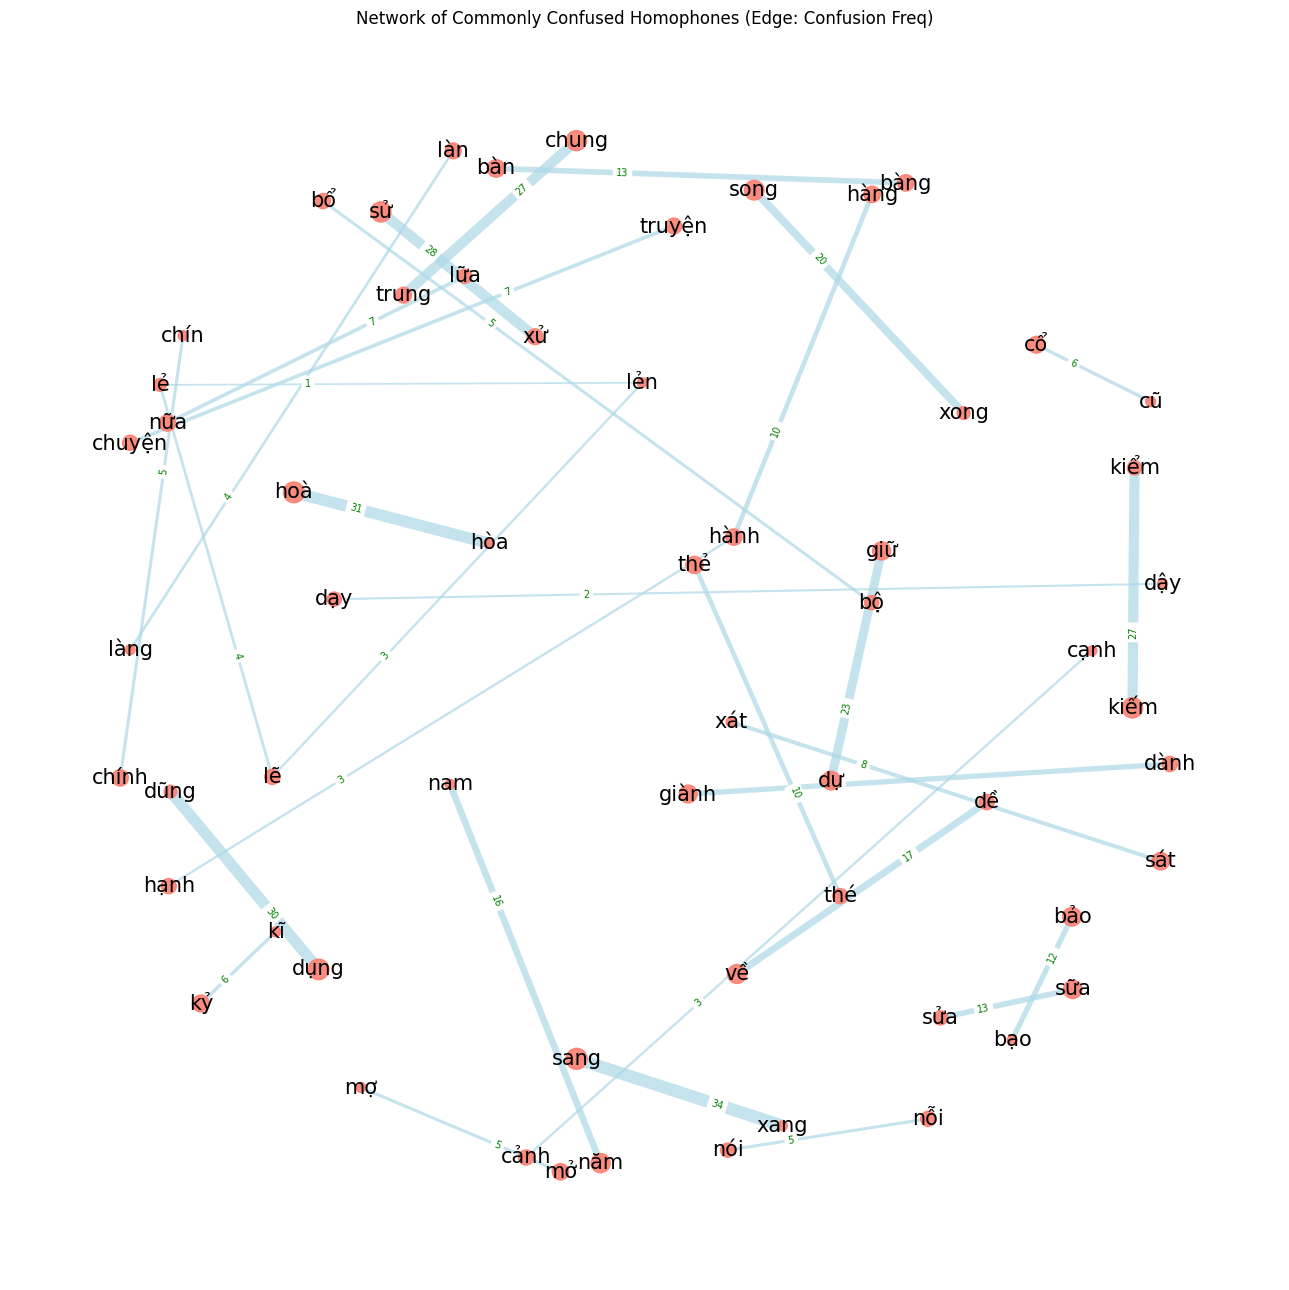

In [98]:
if nx is not None and homophone_error_pairs_found:
    print("  Generating Homophone Network Graph...")
    plt.figure(figsize=(13, 13)); G_homo = nx.Graph()
    # Use log scale for weights if counts vary widely? Or keep linear? Linear for now.
    max_weight_homo = max(homophone_error_pairs_found.values()) if homophone_error_pairs_found else 1

    all_homo_nodes_found = set(p[0] for p in homophone_error_pairs_found) | set(p[1] for p in homophone_error_pairs_found)
    for node in all_homo_nodes_found:
         node_size = 50 + math.log1p(homophone_error_freq_c.get(node, 0)) * 50 # Log scale size
         G_homo.add_node(node, size=node_size)

    edges_added_homo = set()
    for pair, count in homophone_error_pairs_found.items():
        if pair not in edges_added_homo:
            w1, w2 = pair
            # Ensure both nodes exist before adding edge (should always be true here)
            if w1 in G_homo and w2 in G_homo:
                 weight = 1 + (count / max_weight_homo) * 8
                 G_homo.add_edge(w1, w2, weight=weight, frequency=count)
                 edges_added_homo.add(pair)

    if G_homo.number_of_nodes() > 0:
        try:
            pos_homo = nx.spring_layout(G_homo, k=10.0/math.sqrt(G_homo.number_of_nodes()), iterations=50, seed=42)
            edge_widths_homo = [G_homo[u][v]['weight'] for u, v in G_homo.edges()]
            node_sizes_homo = [G_homo.nodes[n]['size'] for n in G_homo.nodes()]

            nx.draw_networkx_edges(G_homo, pos_homo, width=edge_widths_homo, edge_color='lightblue', alpha=0.7)
            nx.draw_networkx_nodes(G_homo, pos_homo, node_size=node_sizes_homo, node_color='salmon', alpha=0.9)
            nx.draw_networkx_labels(G_homo, pos_homo, font_size=15)
            edge_labels_homo = {(u,v): G_homo[u][v]['frequency'] for u,v in G_homo.edges()}
            nx.draw_networkx_edge_labels(G_homo, pos_homo, edge_labels=edge_labels_homo, font_size=7, font_color='green', label_pos=0.3)

            plt.title('Network of Commonly Confused Homophones (Edge: Confusion Freq)'); plt.axis('off'); plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, "homophone_network_graph.png"))
            print(f"Saved {PLOT_DIR}/homophone_network_graph.png")
            # plt.show()
        except Exception as e: print(f"  Failed to draw homophone network graph: {e}")
    else: print("  No nodes/edges for homophone graph.")
else: print("  Skipping Homophone Network Graph (networkx not available or no pairs found).")

# Word Embedding Projection - Skipped
print("\n  Word Embedding Projection: Skipped (Requires pre-trained embeddings and setup).")
print(f"--- Finished ({time.time() - start_time_c:.2f}s) ---")